In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import re

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pmdarima as pm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

import joblib as jb

from google.colab import drive
drive.mount('/content/drive')

pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [2]:
folder_path = '/content/drive/My Drive/Nhóm 8_KDTM_documents/'

In [3]:
stock = {}
stock['FPT'] = pd.read_csv(f"{folder_path}FPT Corp Stock Price History.csv")
stock['HPG'] = pd.read_csv(f"{folder_path}Hoa Phat Group JSC Stock Price History.csv")
stock['VCB'] = pd.read_csv(f"{folder_path}Vietcombank Stock Price History.csv")
stock['VNM'] = pd.read_csv(f"{folder_path}Vinamilk Stock Price History.csv")
stock['MWG'] = pd.read_csv(f"{folder_path}Mobile World Investment Corp Stock Price History.csv")
for key, item in stock.items():
    print(f"Giá cổ phiếu: {key}")
    print(item.head())

Giá cổ phiếu: FPT
         Date      Price       Open       High        Low   Vol. Change %
0  11/28/2024  139,500.0  138,900.0  140,000.0  132,000.0  1.45M   10.89%
1  11/27/2024  125,800.0  135,200.0  139,600.0  125,800.0  9.81M   -6.95%
2  11/26/2024  135,200.0  133,400.0  135,900.0  133,300.0  4.50M    0.97%
3  11/25/2024  133,900.0  134,000.0  134,000.0  133,200.0  6.64M    0.00%
4  11/22/2024  133,900.0  132,900.0  134,400.0  132,500.0  5.58M    0.68%
Giá cổ phiếu: HPG
         Date     Price      Open      High       Low    Vol. Change %
0  11/28/2024  26,550.0  24,500.0  26,750.0  24,500.0   5.09M   -5.18%
1  11/27/2024  28,000.0  26,350.0  28,100.0  25,430.0   7.97M    6.26%
2  11/26/2024  26,350.0  26,300.0  26,500.0  26,200.0  14.57M    0.19%
3  11/25/2024  26,300.0  26,100.0  26,300.0  26,050.0  18.87M    0.77%
4  11/22/2024  26,100.0  25,900.0  26,250.0  25,850.0  18.45M    0.97%
Giá cổ phiếu: VCB
         Date   Price    Open    High     Low     Vol. Change %
0  11/28/202

In [4]:
for key, item in stock.items():
    print(f"Giá cổ phiếu: {key}")
    print(item.tail())

Giá cổ phiếu: FPT
            Date     Price      Open      High       Low    Vol. Change %
2555  09/09/2014  13,872.3  14,622.2  14,622.2  13,622.4  12.04M   -5.13%
2556  09/08/2014  14,622.2  14,622.2  14,872.1  14,497.2   7.23M    0.86%
2557  09/05/2014  14,497.2  14,247.2  14,497.2  14,247.2   6.19M    1.75%
2558  09/04/2014  14,247.2  14,122.3  14,247.2  13,997.3   4.25M    0.00%
2559  09/03/2014  14,247.2  14,497.2  14,622.2  14,122.3   5.36M   -0.87%
Giá cổ phiếu: HPG
            Date    Price     Open     High      Low    Vol. Change %
2555  09/09/2014  5,083.4  5,169.5  5,212.6  4,997.2  17.11M   -3.28%
2556  09/08/2014  5,255.7  5,255.7  5,298.8  5,212.6   9.67M    0.00%
2557  09/05/2014  5,255.7  5,212.6  5,255.7  5,169.5   4.99M    0.00%
2558  09/04/2014  5,255.7  5,126.4  5,341.8  5,126.4  18.89M    2.52%
2559  09/03/2014  5,126.4  5,040.3  5,126.4  5,040.3  11.52M    2.59%
Giá cổ phiếu: VCB
            Date   Price    Open    High     Low     Vol. Change %
2555  09/09/201

In [5]:
for key, item in stock.items():
    print(f"Giá cổ phiếu: {key}")
    print(item.info())

Giá cổ phiếu: FPT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2560 non-null   object
 1   Price     2560 non-null   object
 2   Open      2560 non-null   object
 3   High      2560 non-null   object
 4   Low       2560 non-null   object
 5   Vol.      2559 non-null   object
 6   Change %  2560 non-null   object
dtypes: object(7)
memory usage: 140.1+ KB
None
Giá cổ phiếu: HPG
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2560 non-null   object
 1   Price     2560 non-null   object
 2   Open      2560 non-null   object
 3   High      2560 non-null   object
 4   Low       2560 non-null   object
 5   Vol.      2559 non-null   object
 6   Change %  2560 non-null   object
dtypes: object(7)
mem

In [6]:
full_date_range = pd.date_range(start='2014-09-03', end='2024-11-28')
date_length = len(full_date_range)
print(f"Số ngày: {date_length}")
for key,value in stock.items():
    print(f"Số ngày giao dịch cổ phiếu {key} bị thiếu: {date_length-len(stock[key]['Date'])}")

Số ngày: 3740
Số ngày giao dịch cổ phiếu FPT bị thiếu: 1180
Số ngày giao dịch cổ phiếu HPG bị thiếu: 1180
Số ngày giao dịch cổ phiếu VCB bị thiếu: 1180
Số ngày giao dịch cổ phiếu VNM bị thiếu: 1180
Số ngày giao dịch cổ phiếu MWG bị thiếu: 1180


Theo như bảng thông tin trên, tất cả các cột đều bị khuyết thiếu giá trị và các cột đều chưa đúng định dạng mà chúng nên có: tất cả đều có định dạng là object thay vì dạng datetime cho cột `Date` và dạng số cho các cột khác. Hơn nữa, còn rất nhiều ngày giao dịch bị thiếu trong bộ dữ liệu: cụ thể là 1180 ngày, những ngày này có thể là cuối tuần hoặc nghỉ lễ. Tuy nhiên, vẫn cần có thao tác xử lí các giá trị khuyết thiếu của các ngày này để đảm bảo tính liền mạch của dữ liệu

In [7]:
for key, value in stock.items():
    stock[key]['Date'] = pd.to_datetime(stock[key]['Date'])
    missing_dates = full_date_range.difference(stock[key]['Date'])
    print(f"Các ngày bị thiếu với cổ phiếu {key}:")
    print(missing_dates)

Các ngày bị thiếu với cổ phiếu FPT:
DatetimeIndex(['2014-09-06', '2014-09-07', '2014-09-13', '2014-09-14',
               '2014-09-20', '2014-09-21', '2014-09-27', '2014-09-28',
               '2014-10-04', '2014-10-05',
               ...
               '2024-10-26', '2024-10-27', '2024-11-02', '2024-11-03',
               '2024-11-09', '2024-11-10', '2024-11-16', '2024-11-17',
               '2024-11-23', '2024-11-24'],
              dtype='datetime64[ns]', length=1180, freq=None)
Các ngày bị thiếu với cổ phiếu HPG:
DatetimeIndex(['2014-09-06', '2014-09-07', '2014-09-13', '2014-09-14',
               '2014-09-20', '2014-09-21', '2014-09-27', '2014-09-28',
               '2014-10-04', '2014-10-05',
               ...
               '2024-10-26', '2024-10-27', '2024-11-02', '2024-11-03',
               '2024-11-09', '2024-11-10', '2024-11-16', '2024-11-17',
               '2024-11-23', '2024-11-24'],
              dtype='datetime64[ns]', length=1180, freq=None)
Các ngày bị thiếu với cổ

## Tiền xử lý dữ liệu

In [8]:
def transform_date(x):
    missing_dates = full_date_range.difference(x['Date'])
    missing_dates = pd.DataFrame({'Date': missing_dates})
    stock = pd.concat([x, missing_dates], ignore_index=True)
    stock['Date'] = pd.to_datetime(stock['Date'])
    stock = stock.sort_values(by='Date').reset_index(drop=True)
    return stock
for key, value in stock.items():
    stock[key] = transform_date(stock[key])
    print(f"Giá cổ phiếu: {key}")
    print(stock[key].head())
    print(stock[key].info())
    print(stock[key].isnull().sum())

Giá cổ phiếu: FPT
        Date     Price      Open      High       Low   Vol. Change %
0 2014-09-03  14,247.2  14,497.2  14,622.2  14,122.3  5.36M   -0.87%
1 2014-09-04  14,247.2  14,122.3  14,247.2  13,997.3  4.25M    0.00%
2 2014-09-05  14,497.2  14,247.2  14,497.2  14,247.2  6.19M    1.75%
3 2014-09-06       NaN       NaN       NaN       NaN    NaN      NaN
4 2014-09-07       NaN       NaN       NaN       NaN    NaN      NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3740 entries, 0 to 3739
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3740 non-null   datetime64[ns]
 1   Price     2560 non-null   object        
 2   Open      2560 non-null   object        
 3   High      2560 non-null   object        
 4   Low       2560 non-null   object        
 5   Vol.      2559 non-null   object        
 6   Change %  2560 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usag

Ở các `Price`, `Open`, `High`, `Low` các giá trị đều đang ở dạng object thay vì dạng số và các số chứa dấu `,` khiến chúng không thể ở dạng số. Vấn đề này cũng xảy ra tương tự với cột `Change %`, tuy nhiên ở cột này cần loại bỏ kí hiệu `%`

In [9]:
def object_to_numeric(x):
    price_col=['Price','Open','High','Low']
    x[price_col] = x[price_col].replace(',','',regex=True)
    x[price_col] = x[price_col].apply(pd.to_numeric)
    x['Change %'] = x['Change %'].replace('%','',regex=True)
    x['Change %'] = x['Change %'].apply(pd.to_numeric)
    return x
for key, value in stock.items():
    stock[key] = object_to_numeric(stock[key])
    print(f"Giá cổ phiếu: {key}")
    print(stock[key].head())
    print(stock[key].info())

Giá cổ phiếu: FPT
        Date     Price      Open      High       Low   Vol.  Change %
0 2014-09-03 14,247.20 14,497.20 14,622.20 14,122.30  5.36M     -0.87
1 2014-09-04 14,247.20 14,122.30 14,247.20 13,997.30  4.25M      0.00
2 2014-09-05 14,497.20 14,247.20 14,497.20 14,247.20  6.19M      1.75
3 2014-09-06       NaN       NaN       NaN       NaN    NaN       NaN
4 2014-09-07       NaN       NaN       NaN       NaN    NaN       NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3740 entries, 0 to 3739
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3740 non-null   datetime64[ns]
 1   Price     2560 non-null   float64       
 2   Open      2560 non-null   float64       
 3   High      2560 non-null   float64       
 4   Low       2560 non-null   float64       
 5   Vol.      2559 non-null   object        
 6   Change %  2560 non-null   float64       
dtypes: datetime64[ns](1), float64(5), obj

Cột cuối cùng không đúng định dạng là cột `Vol.`. Ở mỗi giá trị đều có đơn vị dạng chữ đi kèm nó. Việc đầu tiên là cần xem xét xem các đơn vị chữ gồm những đơn vị gì

In [10]:
def split_vol(vol):
    vol = str(vol)
    value = re.match(r"([\d\.]+)([A-Za-z]*)", vol)
    if value:
        number = float(value.group(1))
        unit = value.group(2)
    else:
        number, unit = None, None
    return number, unit
for k, v in stock.items():
    stock[k]['Vol.'], stock[k]['Unit'] = zip(*stock[k]['Vol.'].apply(split_vol))
    print(f"Giá cổ phiếu: {k}")
    print(v.head())

Giá cổ phiếu: FPT
        Date     Price      Open      High       Low  Vol.  Change %  Unit
0 2014-09-03 14,247.20 14,497.20 14,622.20 14,122.30  5.36     -0.87     M
1 2014-09-04 14,247.20 14,122.30 14,247.20 13,997.30  4.25      0.00     M
2 2014-09-05 14,497.20 14,247.20 14,497.20 14,247.20  6.19      1.75     M
3 2014-09-06       NaN       NaN       NaN       NaN   NaN       NaN  None
4 2014-09-07       NaN       NaN       NaN       NaN   NaN       NaN  None
Giá cổ phiếu: HPG
        Date    Price     Open     High      Low  Vol.  Change %  Unit
0 2014-09-03 5,126.40 5,040.30 5,126.40 5,040.30 11.52      2.59     M
1 2014-09-04 5,255.70 5,126.40 5,341.80 5,126.40 18.89      2.52     M
2 2014-09-05 5,255.70 5,212.60 5,255.70 5,169.50  4.99      0.00     M
3 2014-09-06      NaN      NaN      NaN      NaN   NaN       NaN  None
4 2014-09-07      NaN      NaN      NaN      NaN   NaN       NaN  None
Giá cổ phiếu: VCB
        Date     Price      Open      High       Low   Vol.  Change % 

In [11]:
for k, v in stock.items():
    print(f"Giá cổ phiếu: {k}")
    print("Đơn vị của khối lượng giao dịch:")
    print(v['Unit'].unique())

Giá cổ phiếu: FPT
Đơn vị của khối lượng giao dịch:
['M' None 'K']
Giá cổ phiếu: HPG
Đơn vị của khối lượng giao dịch:
['M' None 'K']
Giá cổ phiếu: VCB
Đơn vị của khối lượng giao dịch:
['K' 'M' None]
Giá cổ phiếu: VNM
Đơn vị của khối lượng giao dịch:
['K' None 'M']
Giá cổ phiếu: MWG
Đơn vị của khối lượng giao dịch:
['K' None 'M']


Như đã thấy, ở tất cả các bảng, đơn vị của khối lượng giao dịch `Vol.` chỉ có thể là M(1.000.000) và K(1.000) và None(không có đơn vị). Nhóm sẽ áp dụng nghiên tắc này để biến đổi giá trị của cột `Vol.` cho phù hợp

In [12]:
def convert(number,unit):
    unit_map={'K':1_000,'M':1_000_000}
    return number*unit_map.get(unit,1)
for k,v in stock.items():
    stock[k]['Vol.'] = v.apply(lambda row: convert(row['Vol.'],row['Unit']),axis=1)
    stock[k] = stock[k].drop(columns = 'Unit')
    print(f"Giá cổ phiếu: {k}")
    print(v.head())
    print(v.info())

Giá cổ phiếu: FPT
        Date     Price      Open      High       Low         Vol.  Change %  \
0 2014-09-03 14,247.20 14,497.20 14,622.20 14,122.30 5,360,000.00     -0.87   
1 2014-09-04 14,247.20 14,122.30 14,247.20 13,997.30 4,250,000.00      0.00   
2 2014-09-05 14,497.20 14,247.20 14,497.20 14,247.20 6,190,000.00      1.75   
3 2014-09-06       NaN       NaN       NaN       NaN          NaN       NaN   
4 2014-09-07       NaN       NaN       NaN       NaN          NaN       NaN   

   Unit  
0     M  
1     M  
2     M  
3  None  
4  None  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3740 entries, 0 to 3739
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3740 non-null   datetime64[ns]
 1   Price     2560 non-null   float64       
 2   Open      2560 non-null   float64       
 3   High      2560 non-null   float64       
 4   Low       2560 non-null   float64       
 5   Vol.      2559

Như vậy các cột đều đã được chuyển về định dạng chuẩn cho việc phân tích và dựng mô hình

In [13]:
for k,v in stock.items():
    stock[k] = v.set_index('Date')
    print(f"Giá cổ phiếu: {k}")
    print(stock[k].head())

Giá cổ phiếu: FPT
               Price      Open      High       Low         Vol.  Change %
Date                                                                     
2014-09-03 14,247.20 14,497.20 14,622.20 14,122.30 5,360,000.00     -0.87
2014-09-04 14,247.20 14,122.30 14,247.20 13,997.30 4,250,000.00      0.00
2014-09-05 14,497.20 14,247.20 14,497.20 14,247.20 6,190,000.00      1.75
2014-09-06       NaN       NaN       NaN       NaN          NaN       NaN
2014-09-07       NaN       NaN       NaN       NaN          NaN       NaN
Giá cổ phiếu: HPG
              Price     Open     High      Low          Vol.  Change %
Date                                                                  
2014-09-03 5,126.40 5,040.30 5,126.40 5,040.30 11,520,000.00      2.59
2014-09-04 5,255.70 5,126.40 5,341.80 5,126.40 18,890,000.00      2.52
2014-09-05 5,255.70 5,212.60 5,255.70 5,169.50  4,990,000.00      0.00
2014-09-06      NaN      NaN      NaN      NaN           NaN       NaN
2014-09-07      NaN 

Việc tiếp theo cần làm là điền các giá trị bị khuyết thiếu. Nhóm sẽ sử dụng các phương pháp điền giá trị khuyết thiếu khác nhau và sử dụng một mô hình Linear Regression để xem xét xem phương án nào hiệu quả nhất

In [14]:
def test_impute(x):
    test = {}
    # Loại bỏ giá trị null
    test['Del'] = x.dropna()
    # Điền giá trị trung bình
    test['Mean'] = x.fillna(x.mean())
    # Điền giá trị trung vị
    test['Median'] = x.fillna(x.median())
    # Điền giá trị mode
    test['Mode'] = x.fillna(x.mode().iloc[0])
    # Điền giá trị trước đó
    test['Ffill'] = x.fillna(method='ffill')
    test['Ffill'] = test['Ffill'].dropna()
    # Điền giá trị sau đó
    test['Bfill'] = x.fillna(method='bfill')
    test['Bfill'] = test['Bfill'].dropna()
    # Nội suy tuyến tính
    test['Interpolate'] = x.interpolate(method='linear')
    test['Interpolate'] = test['Interpolate'].dropna()
    result ={}
    for key, item in test.items():
        X = item.drop(columns = 'Price')
        y = item['Price']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        model_result = {
            'MSE': round(mean_squared_error(y_test, y_pred),2),
            'MAE': round(mean_absolute_error(y_test, y_pred),2),
            'R2': round(r2_score(y_test, y_pred),2)
        }
        result[key] = model_result
    return result

In [15]:
for key, value in stock.items():
    print(f"Cổ phiếu {key}")
    result = test_impute(value)
    result_df = pd.DataFrame(result).T
    print(result_df)

Cổ phiếu FPT
                   MSE    MAE   R2
Del         167,050.16 229.07 1.00
Mean         99,259.66 157.70 1.00
Median       99,448.38 164.62 1.00
Mode        133,647.75 245.10 1.00
Ffill       138,634.12 224.83 1.00
Bfill       154,738.81 233.02 1.00
Interpolate 117,982.74 209.00 1.00
Cổ phiếu HPG
                  MSE    MAE   R2
Del         20,172.89  91.48 1.00
Mean        12,180.31  60.73 1.00
Median      12,291.57  66.55 1.00
Mode        31,134.84 127.14 1.00
Ffill       16,375.50  85.30 1.00
Bfill       16,646.53  87.09 1.00
Interpolate 14,966.66  80.83 1.00
Cổ phiếu VCB
                   MSE    MAE   R2
Del         150,539.66 267.88 1.00
Mean        104,548.64 187.24 1.00
Median      104,683.88 201.27 1.00
Mode        332,032.96 310.59 1.00
Ffill       156,500.33 274.10 1.00
Bfill       156,817.77 273.65 1.00
Interpolate 136,585.20 255.51 1.00
Cổ phiếu VNM
                   MSE    MAE   R2
Del         405,835.19 340.45 1.00
Mean        156,803.83 232.61 1.00
Median     

Dựa vào các kết quả hiển thị ở trên, có thể khẳng định phương pháp điền giá trị khuyết thiếu bằng giá trị trung bình của các cột sẽ cho mô hình có kết quả tối ưu nhất (MSE và MAE thấp nhất và R2 cao nhất). Vậy nên nhóm quyết định lựa chọn phương pháp điền giá trị khuyết thiếu bằng giá trị trung bình

In [16]:
for key, value in stock.items():
    stock[key] = value.fillna(value.mean())
    print(f"Cổ phiếu {key}")
    print(stock[key].head())
    print(stock[key].info())

Cổ phiếu FPT
               Price      Open      High       Low         Vol.  Change %
Date                                                                     
2014-09-03 14,247.20 14,497.20 14,622.20 14,122.30 5,360,000.00     -0.87
2014-09-04 14,247.20 14,122.30 14,247.20 13,997.30 4,250,000.00      0.00
2014-09-05 14,497.20 14,247.20 14,497.20 14,247.20 6,190,000.00      1.75
2014-09-06 45,896.54 45,881.92 46,385.08 45,404.60 2,423,255.41      0.10
2014-09-07 45,896.54 45,881.92 46,385.08 45,404.60 2,423,255.41      0.10
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3740 entries, 2014-09-03 to 2024-11-28
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     3740 non-null   float64
 1   Open      3740 non-null   float64
 2   High      3740 non-null   float64
 3   Low       3740 non-null   float64
 4   Vol.      3740 non-null   float64
 5   Change %  3740 non-null   float64
dtypes: float64(6)
memory usage: 

Việc tiếp theo cần làm là kiểm tra xem bộ dữ liệu có giá trị ngoại lai (outlier) không

Cổ phiếu FPT


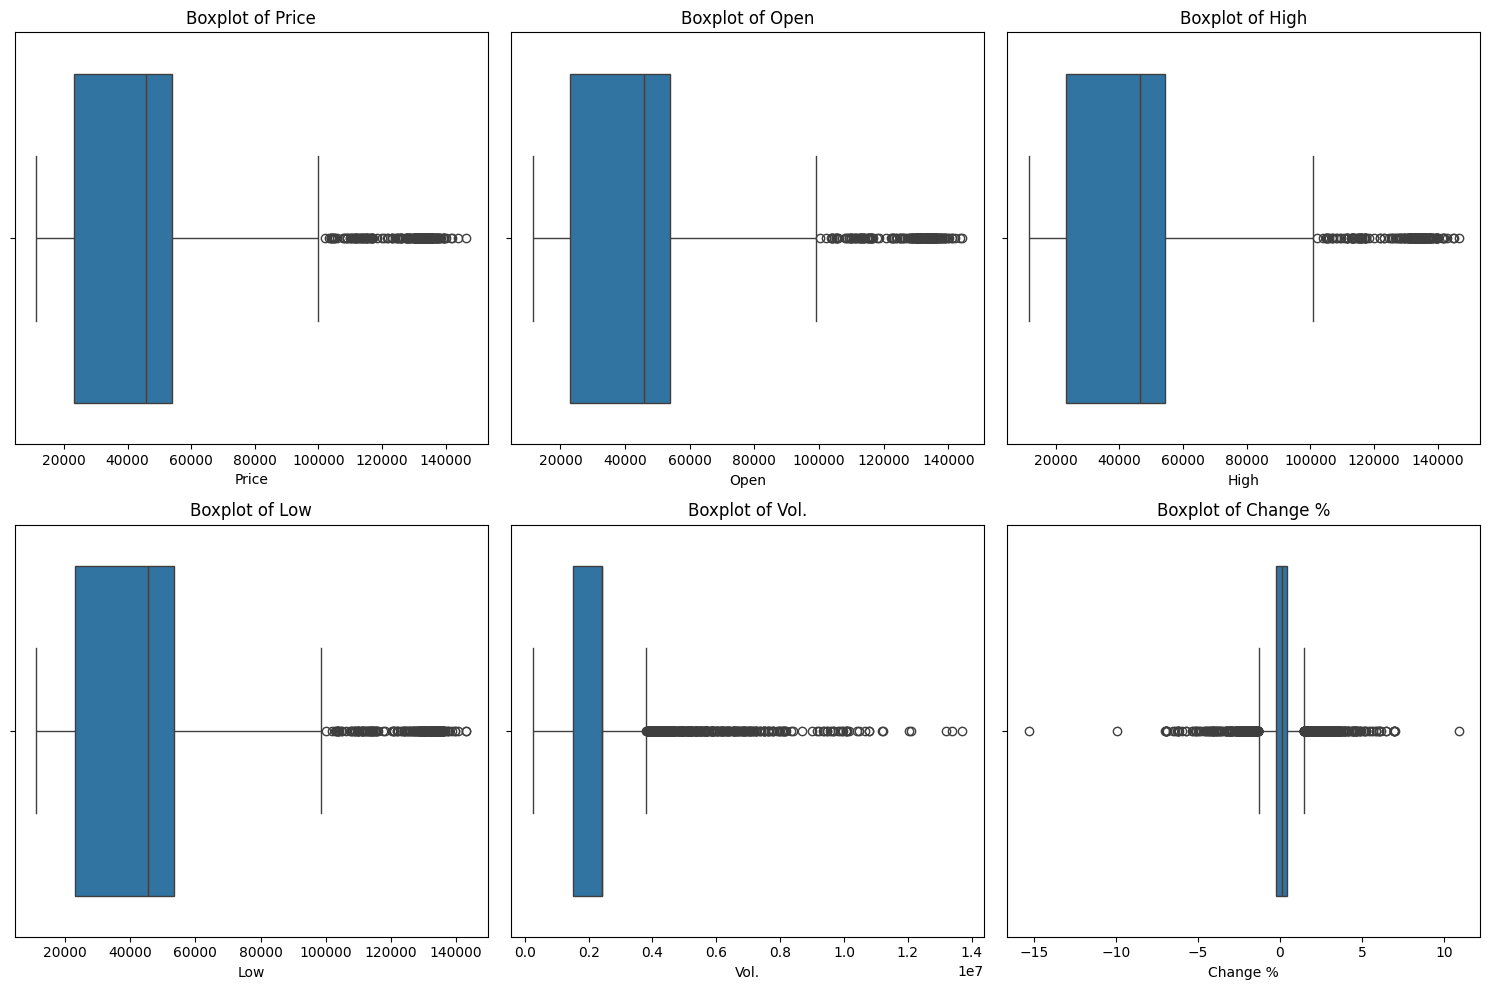

Cổ phiếu HPG


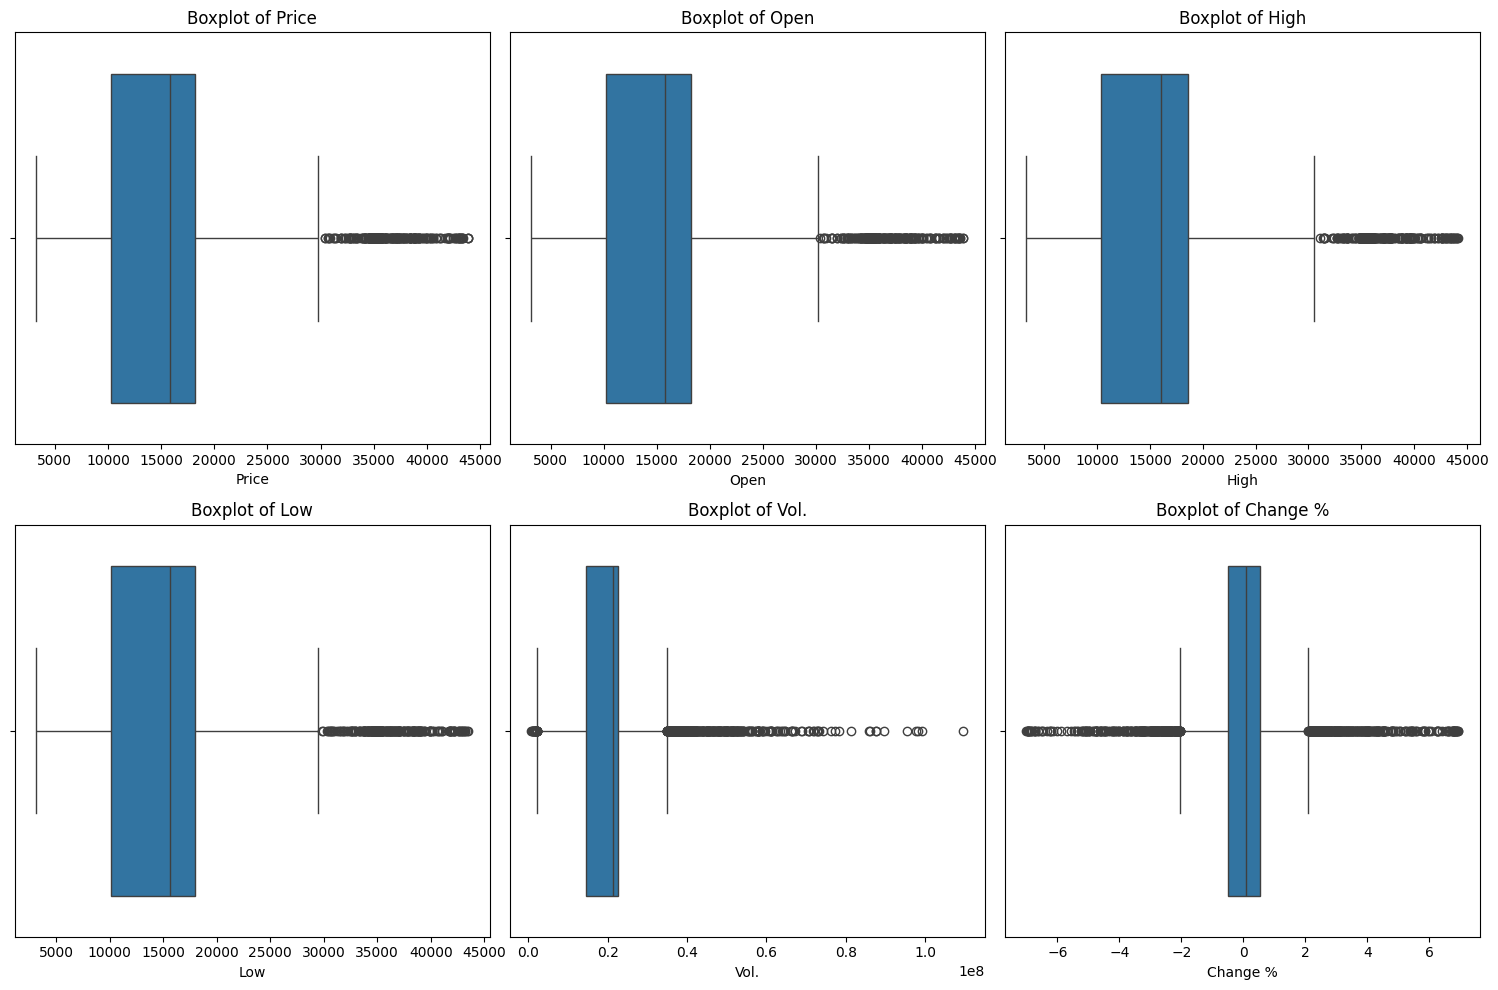

Cổ phiếu VCB


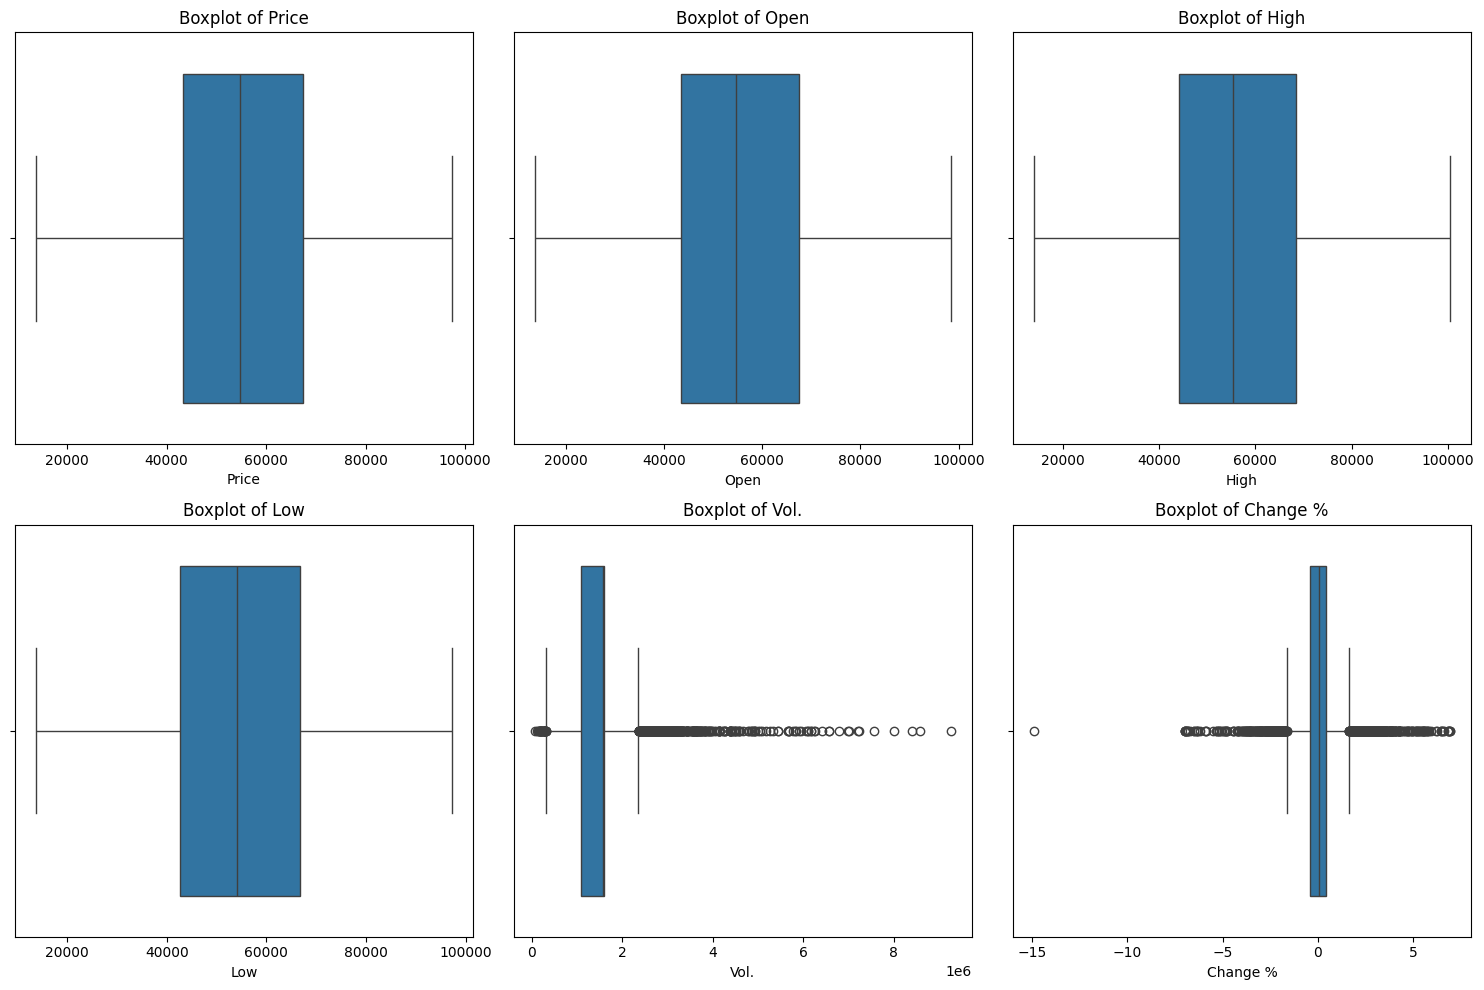

Cổ phiếu VNM


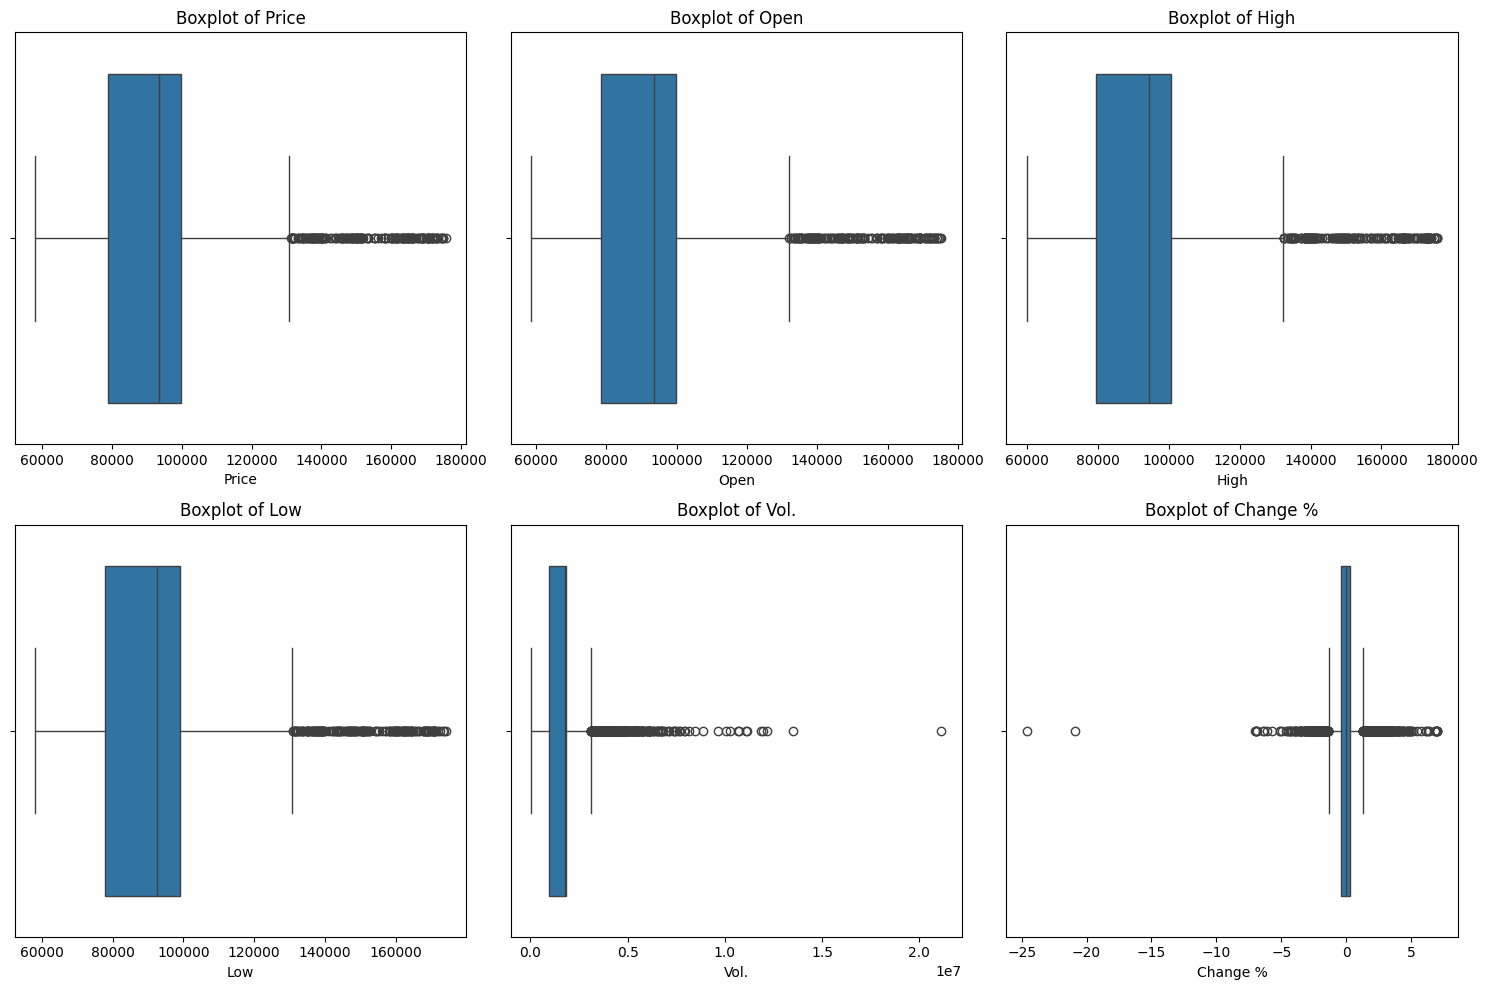

Cổ phiếu MWG


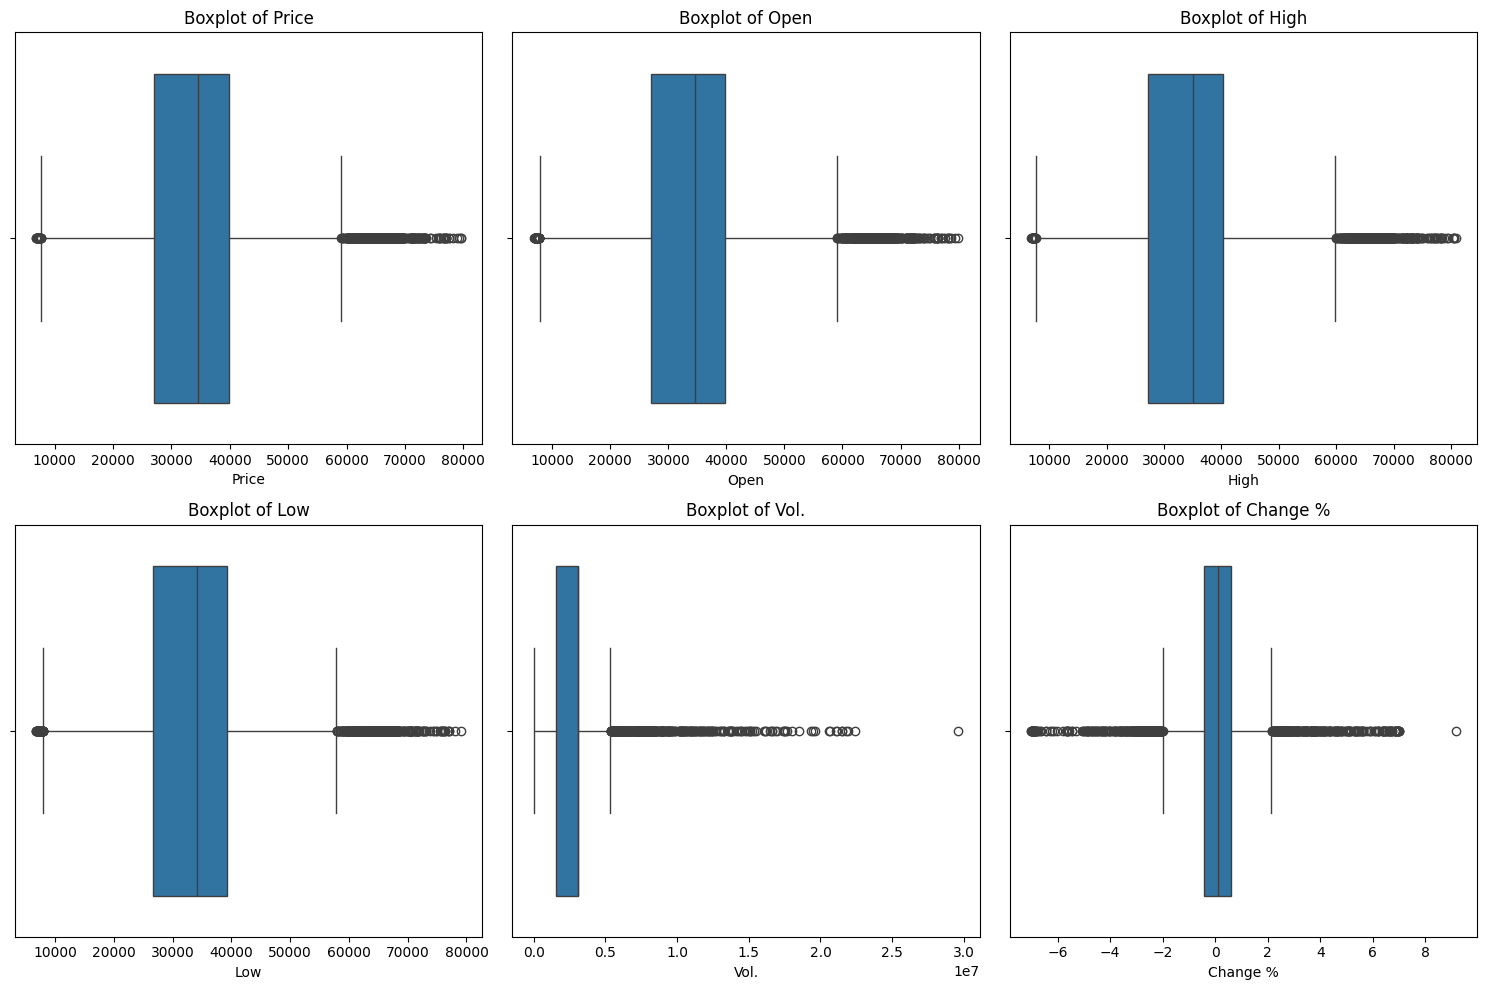

In [17]:
def box_plot(df):
    columns = df.columns.to_list()
    # Đặt số đồ thị mỗi hàng và số hàng
    num_cols = 3
    num_rows = int(len(columns)/num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, col in enumerate(columns):
        sns.boxplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()
for key, item in stock.items():
    print(f"Cổ phiếu {key}")
    box_plot(item)

Có thể thấy rằng bộ dữ liệu của 5 cổ phiếu bị lệch trái khá nhiều. Điều này có thể cho thấy có nhiều giá trị ngoại lai

# Exploratory Data Analysis

## 1. Mô tả sơ bộ về các cổ phiếu

In [18]:
for key,value in stock.items():
    print(f"Cổ phiếu {key}")
    print(value.describe())

Cổ phiếu FPT
           Price       Open       High        Low          Vol.  Change %
count   3,740.00   3,740.00   3,740.00   3,740.00      3,740.00  3,740.00
mean   45,896.54  45,881.92  46,385.08  45,404.60  2,423,255.41      0.10
std    28,808.90  28,794.35  29,122.48  28,461.54  1,473,753.86      1.35
min    11,297.80  11,372.80  11,572.80  11,197.80    241,980.00    -15.31
25%    23,042.80  23,016.70  23,244.78  22,905.90  1,500,000.00     -0.26
50%    45,896.54  45,881.92  46,385.08  45,404.60  2,423,255.41      0.10
75%    53,809.40  53,756.75  54,441.70  53,405.50  2,423,255.41      0.43
max   146,500.00 144,300.00 146,500.00 143,100.00 13,710,000.00     10.89
Cổ phiếu HPG
          Price      Open      High       Low           Vol.  Change %
count  3,740.00  3,740.00  3,740.00  3,740.00       3,740.00  3,740.00
mean  15,792.35 15,797.75 16,010.80 15,592.51  21,298,868.31      0.09
std    8,466.93  8,481.50  8,588.52  8,368.26  11,625,007.15      1.73
min    3,280.00  3,187.4

### 1. **Cổ phiếu FPT**
- **Giá trị trung bình**: 45,896 VNĐ, với mức giá cao nhất là **146,500 VNĐ** và thấp nhất là **11,298 VNĐ**.
- **Biến động lớn**: Độ lệch chuẩn khá cao (**28,809 VNĐ**), cho thấy cổ phiếu này có mức độ biến động đáng kể.
- **Thay đổi phần trăm nhỏ**: Trung bình thay đổi **0.10%**, với biên độ dao động từ **-15.31%** đến **10.89%**.
- **Khối lượng giao dịch trung bình**: ~2.4 triệu cổ phiếu mỗi phiên, với phiên cao nhất đạt hơn 13.7 triệu.

### 2. **Cổ phiếu HPG**
- **Giá trị trung bình**: 15,792 VNĐ, mức cao nhất là **43,896 VNĐ** và thấp nhất là **3,280 VNĐ**.
- **Biến động giá vừa phải**: Độ lệch chuẩn (**8,467 VNĐ**) cho thấy mức biến động thấp hơn rất nhiều so với FPT.
- **Khối lượng giao dịch lớn**: Trung bình hơn 21 triệu cổ phiếu mỗi phiên, cao nhất đạt **109.6 triệu** cổ phiếu.
- **Thay đổi phần trăm**: Trung bình **0.09%**, dao động từ **-7.00%** đến **6.94%**.

### 3. **Cổ phiếu VCB**
- **Giá trị trung bình**: 54,797 VNĐ, mức cao nhất là **97,400 VNĐ** và thấp nhất là **13,710 VNĐ**.
- **Biến động thấp hơn**: Độ lệch chuẩn (**20,385 VNĐ**) vừa phải.
- **Thay đổi phần trăm nhỏ**: Trung bình **0.09%**, dao động từ **-14.92%** đến **6.95%**.
- **Khối lượng giao dịch trung bình**: ~1.6 triệu cổ phiếu mỗi phiên.

### 4. **Cổ phiếu VNM**
- **Giá trị trung bình**: 93,442 VNĐ, cao nhất **175,578 VNĐ** và thấp nhất **58,115 VNĐ**.
- **Biến động thấp**: Độ lệch chuẩn (**20,445 VNĐ**) và thay đổi trung bình **0.01%** cho thấy tính ổn định cao.
- **Khối lượng giao dịch trung bình**: ~1.75 triệu cổ phiếu, thấp hơn so với các cổ phiếu khác.

### 5. **Cổ phiếu MWG**
- **Giá trị trung bình**: 34,626 VNĐ, mức cao nhất là **79,582 VNĐ** và thấp nhất là **6,799 VNĐ**.
- **Biến động giá vừa phải**: Độ lệch chuẩn (**15,603 VNĐ**) tương đối hợp lý.
- **Khối lượng giao dịch trung bình**: ~3 triệu cổ phiếu mỗi phiên, thanh khoản tốt.
- **Thay đổi phần trăm trung bình**: **0.11%**, dao động từ **-7.00%** đến **9.17%**.

## 2. Biến động giá của các cổ phiếu

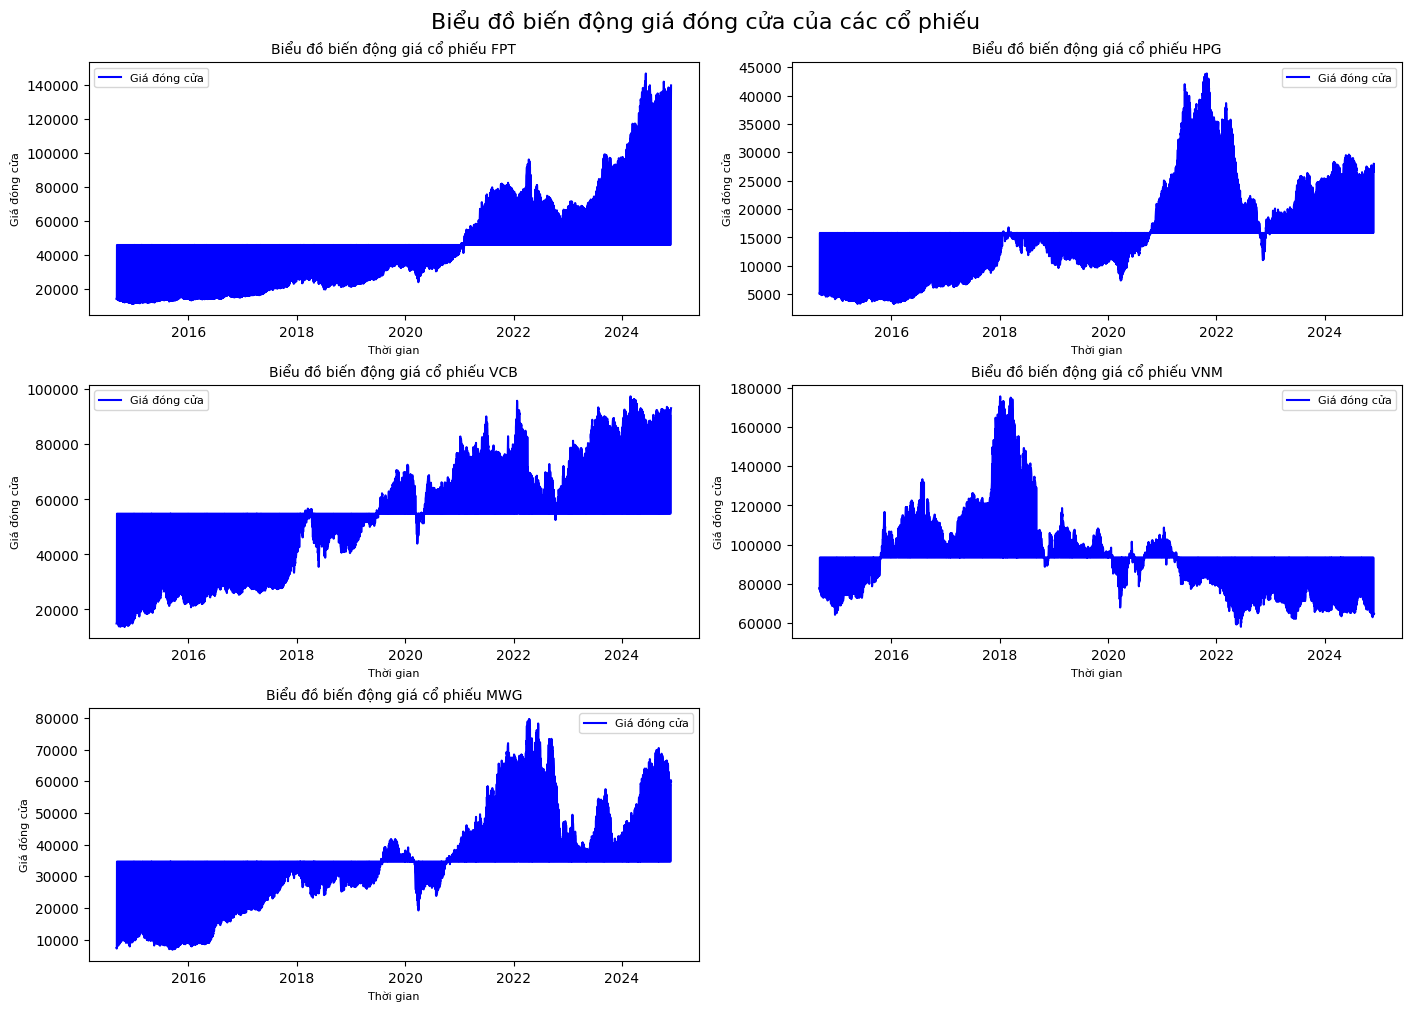

In [19]:
def price_change(stock, pic_name):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10), constrained_layout=True)
    axes = axes.flatten()
    # Vẽ biểu đồ
    for idx, (key, value) in enumerate(stock.items()):
        ax = axes[idx]
        ax.plot(value['Price'], label='Giá đóng cửa', color='blue')
        ax.set_title(f"Biểu đồ biến động giá cổ phiếu {key}", fontsize=10)
        ax.set_xlabel('Thời gian', fontsize=8)
        ax.set_ylabel('Giá đóng cửa', fontsize=8)
        ax.legend(fontsize=8)
    # Xóa subplot trống
    for j in range(len(stock), len(axes)):
        fig.delaxes(axes[j])
    # Tiêu đề chính
    fig.suptitle("Biểu đồ biến động giá đóng cửa của các cổ phiếu", fontsize=16)
    # Lưu biểu đồ
    plt.savefig(pic_name, format="png", dpi=300)
    plt.show()

price_change(stock, "/content/drive/My Drive/Nhóm 8_KDTM_documents/Biểu đồ biến động giá đóng cửa.png")

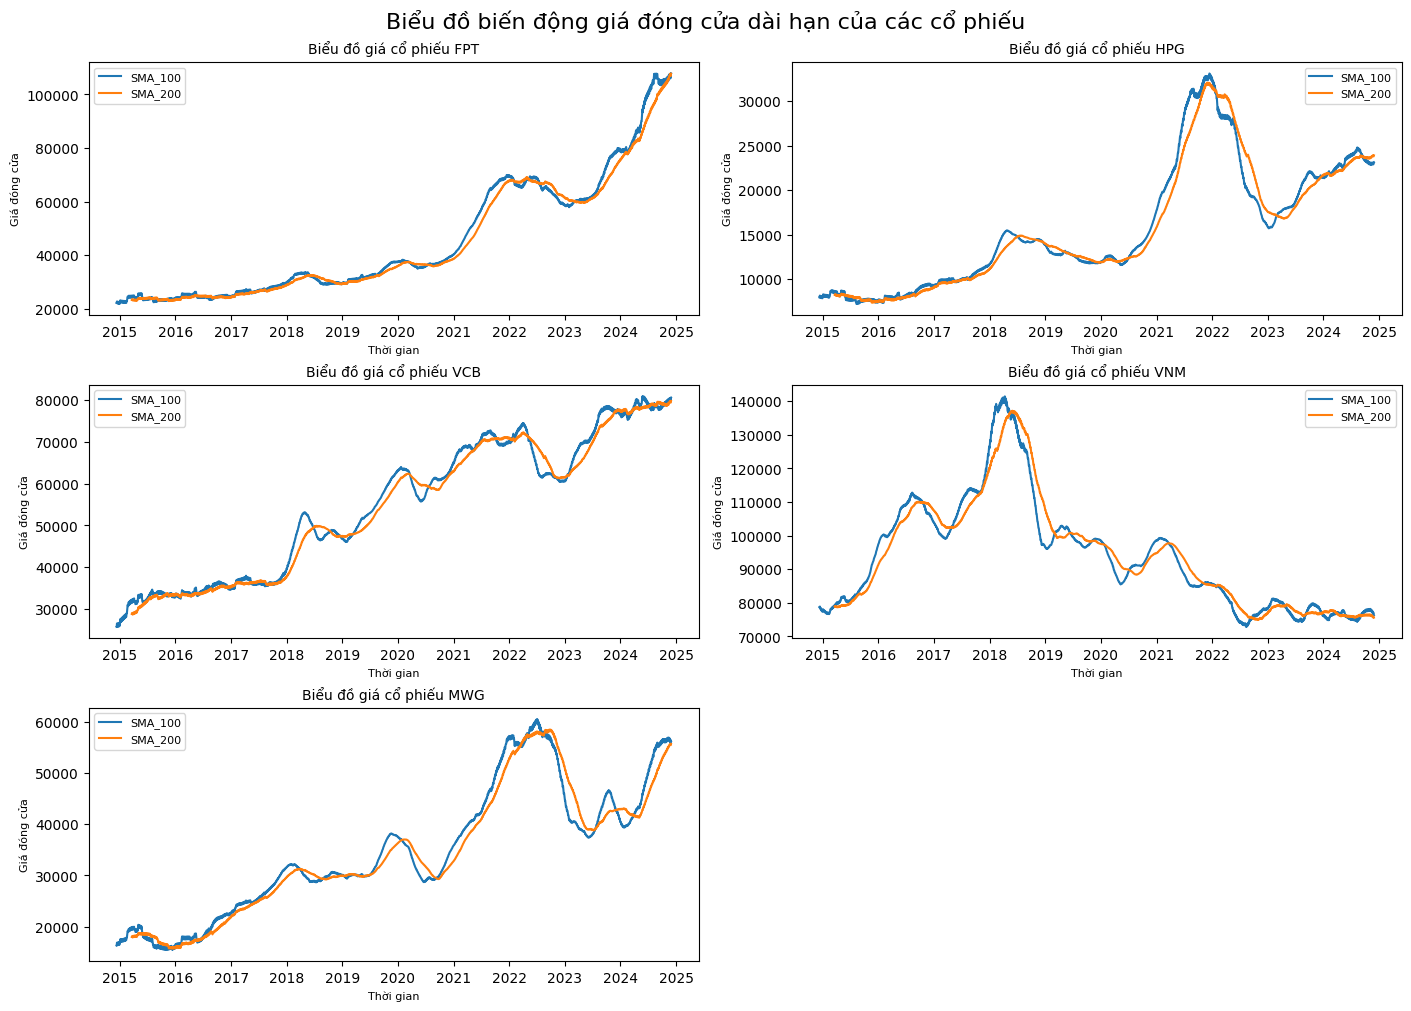

In [20]:
def MA_price_graph(stock,pic_name):
    fig,axes = plt.subplots(nrows=3, ncols=2, figsize=(14,10), constrained_layout=True)
    axes = axes.flatten()
    for idx,(key, value) in enumerate(stock.items()):
        ax = axes[idx]
        for i in [100,200]:
            ax.plot(value['Price'].rolling(window=i).mean(), label=f"SMA_{i}")
        ax.set_title(f"Biểu đồ giá cổ phiếu {key}", fontsize=10)
        ax.set_xlabel('Thời gian', fontsize=8)
        ax.set_ylabel('Giá đóng cửa', fontsize=8)
        ax.legend(fontsize=8)
    for j in range(len(stock), len(axes)):
        fig.delaxes(axes[j])
    # Tên biểu đồ
    fig.suptitle("Biểu đồ biến động giá đóng cửa dài hạn của các cổ phiếu", fontsize=16)
    # Lưu biểu đồ
    plt.savefig(pic_name, format="png", dpi=300)
    plt.show()

MA_price_graph(stock, "/content/drive/My Drive/Nhóm 8_KDTM_documents/Biểu đồ giá đóng cửa trong dài hạn.png")

1. **Cổ phiếu FPT**:
   - Giá đóng cửa tăng trưởng ổn định trong dài hạn, đặc biệt rõ ràng từ năm 2020 đến 2024.
   - SMA 100 nằm sát SMA 200, phản ánh xu hướng dài hạn tích cực và ổn định.
   - Giai đoạn cuối năm 2023 và đầu năm 2024 có xu hướng tăng mạnh.

2. **Cổ phiếu HPG**:
   - Giá tăng mạnh từ năm 2020 đến 2021, đạt đỉnh vào khoảng cuối 2021 đến đầu năm 2022.
   - SMA 100 cắt xuống SMA 200 vào các giai đoạn giảm giá.
   - Xu hướng hiện tại cho thấy sự ổn định nhưng chưa có tín hiệu tăng mạnh.

3. **Cổ phiếu VCB**:
   - Giá tăng trưởng đều đặn trong dài hạn, với ít giai đoạn giảm mạnh.
   - SMA 100 luôn duy trì trên SMA 200, cho thấy xu hướng dài hạn tích cực và ổn định.
   - Giai đoạn gần đây tiếp tục cho thấy sự ổn định và khả năng tăng trưởng.

4. **Cổ phiếu VNM**:
   - Giá đóng cửa có sự biến động lớn, với đỉnh cao vào khoảng năm 2018 và suy giảm sau đó.
   - Sau năm 2021, giá có xu hướng đi ngang hoặc giảm nhẹ.
   - SMA 100 và SMA 200 giao cắt thường xuyên, cho thấy xu hướng không ổn định.

5. **Cổ phiếu MWG**:
   - Giá tăng trưởng mạnh từ năm 2015 đến đầu năm 2022, đạt đỉnh vào cuối năm 2022.
   - Xu hướng phục hồi vào năm 2023, nhưng giá vẫn chưa đạt lại đỉnh cũ.
   - SMA 100 và SMA 200 thể hiện xu hướng khá đồng nhất, tuy nhiên có các giai đoạn giao cắt, phản ánh sự biến động.

### Tổng quát:
- Các cổ phiếu FPT và VCB có xu hướng tăng trưởng ổn định và bền vững.
- Cổ phiếu VNM và HPG thể hiện sự biến động lớn và cần theo dõi kỹ để nhận định xu hướng.
- Cổ phiếu MWG cho thấy khả năng phục hồi nhưng cần thêm thời gian để quay lại đỉnh cũ.

## 3. Biến động khối lượng giao dịch của các cổ phiếu

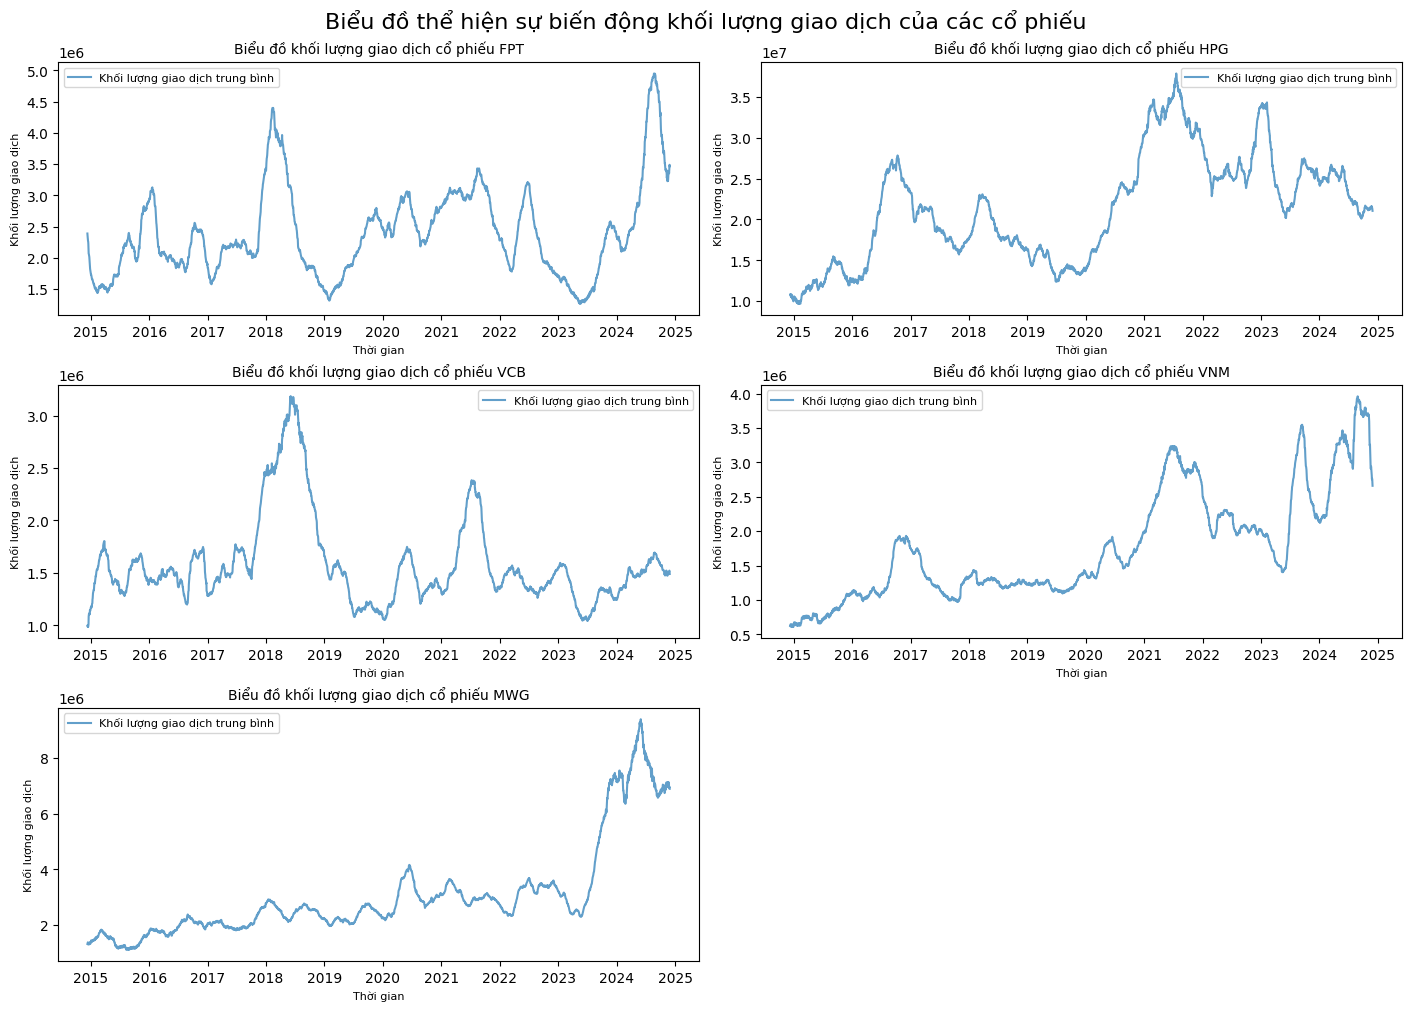

In [21]:
def volume_change(stock, pic_name):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10), constrained_layout=True)
    axes = axes.flatten()
    for idx, (key, value) in enumerate(stock.items()):
        ax = axes[idx]
        ax.plot(value['Vol.'].rolling(window=100).mean(), label='Khối lượng giao dịch trung bình', alpha=0.7)
        ax.set_title(f"Biểu đồ khối lượng giao dịch cổ phiếu {key}", fontsize=10)
        ax.set_xlabel('Thời gian', fontsize=8)
        ax.set_ylabel('Khối lượng giao dịch', fontsize=8)
        ax.legend(fontsize=8)

    for j in range(len(stock), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Biểu đồ thể hiện sự biến động khối lượng giao dịch của các cổ phiếu", fontsize=16)

    plt.savefig(pic_name, format="png", dpi=300)

    plt.show()

volume_change(stock, "/content/drive/My Drive/Nhóm 8_KDTM_documents/Biểu đồ biến động khối lượng giao dịch.png")

1. **Cổ phiếu FPT**
- **Xu hướng khối lượng giao dịch**:
  - Giao dịch dao động ở mức trung bình (1.5-3.5 triệu cổ phiếu/ngày).
  - Khối lượng giao dịch đạt đỉnh 2 lần lần lượt ở khoảng năm 2018 với khoảng 4.5 triệu cổ phiếu/ngày và cuối năm 2024 với khoảng 5 triệu cổ phiếu/ngày.
  - Giai đoạn từ 2020, khối lượng giao dịch trung bình cao hơn so với giai đoạn trước năm 2020.
- **Nhận xét**:
  - Sự gia tăng khối lượng giao dịch từ 2020 có thể phản ánh sự tăng trưởng của doanh nghiệp trong lĩnh vực công nghệ.
  - Khối lượng giao dịch ổn định hơn so với HPG hay MWG, cho thấy đây là cổ phiếu có sự tin cậy từ nhà đầu tư dài hạn.

2. **Cổ phiếu HPG**
- **Xu hướng khối lượng giao dịch**:
  - Khối lượng giao dịch trung bình nhiều nhất trong cả 5 cổ phiếu
  - Khối lượng tăng trưởng mạnh từ năm 2015 đến 2021, đạt đỉnh cao vào cuối năm 2021 với hơn 35 triệu cổ phiếu/ngày.
  - Sau năm 2021, khối lượng giảm nhưng vẫn duy trì ở mức cao (trên 10 triệu cổ phiếu/ngày).
- **Nhận xét**:
  - HPG là cổ phiếu có tính thanh khoản cao, với khối lượng giao dịch lớn nhất trong 5 cổ phiếu.
  - Đỉnh khối lượng năm 2021 trùng với giai đoạn giá cổ phiếu tăng mạnh, cho thấy sự quan tâm lớn của nhà đầu tư trong giai đoạn này.

3. **Cổ phiếu VCB**
- **Xu hướng khối lượng giao dịch**:
  - Giai đoạn 2015-2017: Khối lượng giao dịch ổn định ở mức thấp (khoảng 1-1.5 triệu cổ phiếu/ngày).
  - Khối lượng giao dịch đạt đỉnh năm 2018 với khối lượng tăng mạnh (hơn 3 triệu cổ phiếu/ngày), sau đó giảm trở lại và duy trì mức thấp hơn từ năm 2019 đến 2024.
- **Nhận xét**:
  - Khối lượng giao dịch của VCB không có sự tăng trưởng đều như giá cổ phiếu, cho thấy đây là một cổ phiếu an toàn, thường được nhà đầu tư dài hạn nắm giữ, ít biến động.

4. **Cổ phiếu VNM**
- **Xu hướng khối lượng giao dịch**:
  - Giai đoạn 2016-2020: Giao dịch tương đối ổn định, khối lượng dao động quanh mức 1-2 triệu cổ phiếu/ngày.
  - Giai đoạn 2020-2024: Khối lượng tăng đáng kể, đạt đỉnh vào nửa cuối năm 2021, đầu năm 2022 với hơn 3 triệu cổ phiếu/ngày và nửa cuối năm 2024 với 4 triệu cổ phiếu/ngày.
- **Nhận xét**:
  - Sự tăng khối lượng giao dịch vào các năm 2021 và 2023 có thể do nhà đầu tư kỳ vọng vào sự phục hồi hoặc tái cấu trúc của doanh nghiệp, đặc biệt có thể đến từ việc công ty đổi bao bì sản phẩm khiến cho doanh số tăng, từ đó tạo được niềm tin nơi nhà đầu tư.
  - Tuy nhiên, khối lượng giao dịch không ổn định, cho thấy tâm lý nhà đầu tư có phần dao động.

5. **Cổ phiếu MWG**
- **Xu hướng khối lượng giao dịch**:
  - Khối lượng giao dịch tương đối thấp trong giai đoạn 2015-2019 (2-4 triệu cổ phiếu/ngày).
  - Bắt đầu tăng mạnh từ năm 2020 và đạt đỉnh vào năm 2024 với hơn 8 triệu cổ phiếu/ngày.
  - Sau đó, khối lượng giảm nhẹ nhưng vẫn cao hơn nhiều so với giai đoạn trước 2020.
- **Nhận xét**:
  - Sự tăng khối lượng từ năm 2020 có thể phản ánh sự mở rộng của doanh nghiệp hoặc sự quan tâm từ nhà đầu tư trong bối cảnh kinh tế thuận lợi.
  - Tuy nhiên, việc khối lượng giảm từ 2022 cho thấy nhà đầu tư có phần thận trọng hơn.

### **Nhận xét tổng quát**
1. **Cổ phiếu thanh khoản cao**:
   - **HPG** và **MWG** có khối lượng giao dịch lớn, thể hiện tính thanh khoản cao và sự hấp dẫn đối với nhà đầu tư ngắn hạn.
   - Đặc biệt, **HPG** có khối lượng giao dịch vượt trội, phù hợp với nhà đầu tư yêu thích sự sôi động.

2. **Cổ phiếu giao dịch ổn định**:
   - **VCB**, **VNM**, và **FPT** có khối lượng giao dịch thấp hơn, ổn định hơn, phản ánh sự phù hợp với nhà đầu tư dài hạn.

3. **Tâm lý nhà đầu tư**:
   - Các đỉnh cao về khối lượng giao dịch thường đi kèm với những giai đoạn tăng giá hoặc kỳ vọng tích cực từ thị trường.
   - Sau những giai đoạn đỉnh cao, khối lượng giao dịch giảm có thể phản ánh sự điều chỉnh tâm lý của nhà đầu tư.

## 4. Biến động về lợi nhuận hàng ngày các cổ phiếu mang lại

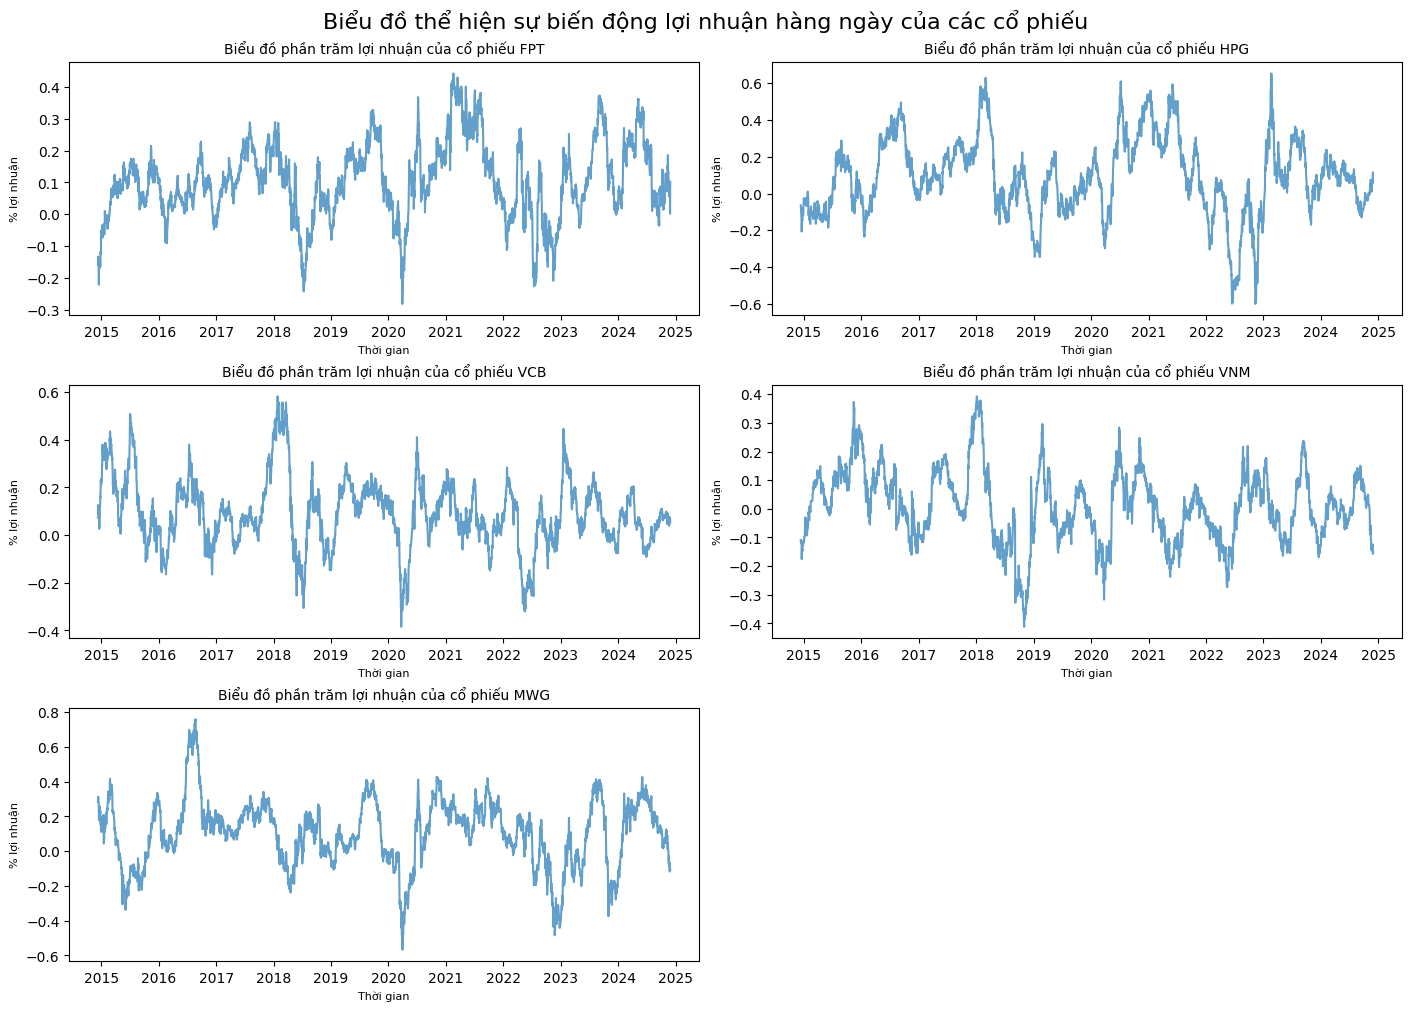

In [22]:
def profit_change(stock, pic_name):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10), constrained_layout=True)
    axes = axes.flatten()

    for idx, (key, value) in enumerate(stock.items()):
        ax = axes[idx]
        ax.plot(value['Change %'].rolling(window=100).mean(), alpha=0.7)
        ax.set_title(f"Biểu đồ phần trăm lợi nhuận của cổ phiếu {key}", fontsize=10)
        ax.set_xlabel('Thời gian', fontsize=8)
        ax.set_ylabel('% lợi nhuận', fontsize=8)

    for j in range(len(stock), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Biểu đồ thể hiện sự biến động lợi nhuận hàng ngày của các cổ phiếu", fontsize=16)

    plt.savefig(pic_name, format="png", dpi=300)

    plt.show()

profit_change(stock, "/content/drive/My Drive/Nhóm 8_KDTM_documents/Biểu đồ biến động sự biến động lợi nhuận.png")

Lợi nhuận hàng ngày của các cổ phiếu được tính bằng phần trăm chênh lệch giá đóng cửa của các cổ phiếu mỗi ngày.
1. **Cổ phiếu FPT**
- **Biến động**:
  - Dao động trong khoảng từ -0.3% đến 0.4%.
  - Tương đối ổn định, với ít giai đoạn biến động bất thường.
- **Nhận xét**:
  - FPT là cổ phiếu ổn định với mức biến động thấp hơn HPG hay MWG, phù hợp với nhà đầu tư dài hạn và trung hạn.

2. **Cổ phiếu HPG**
- **Biến động**:
  - Lợi nhuận dao động rộng hơn, từ -0.6% đến 0.6%.
  - Có nhiều giai đoạn xuất hiện các đỉnh cao hoặc đáy sâu, đặc biệt trong các năm 2020-2021.
- **Nhận xét**:
  - HPG là cổ phiếu có độ rủi ro cao hơn do biên độ dao động lớn, phù hợp với nhà đầu tư chấp nhận rủi ro để tìm kiếm cơ hội lợi nhuận lớn.

3. **Cổ phiếu VCB**
- **Biến động**:
  - Lợi nhuận dao động trong khoảng từ -0.4% đến 0.4% trong suốt giai đoạn.
  - Biến động khá ổn định, không xuất hiện các đợt dao động mạnh bất thường.
- **Nhận xét**:
  - Lợi nhuận hàng ngày của VCB ít biến động, cho thấy đây là cổ phiếu tương đối ổn định và an toàn, phù hợp với nhà đầu tư có khẩu vị rủi ro thấp.

4. **Cổ phiếu VNM**
- **Biến động**:
  - Biên độ dao động nhỏ hơn, từ -0.4% đến 0.4%.
  - Không xuất hiện các giai đoạn biến động đột ngột hay bất thường.
- **Nhận xét**:
  - Cổ phiếu VNM cũng là một lựa chọn ổn định, với lợi nhuận hàng ngày ít biến động. Điều này phù hợp với danh tiếng của VNM là cổ phiếu phòng thủ.

5. **Cổ phiếu MWG**
- **Biến động**:
  - Lợi nhuận dao động mạnh nhất trong số các cổ phiếu, từ -0.6% đến 0.8%.
  - Có nhiều đợt biến động mạnh, lợi nhuận âm nhiều, đặc biệt trong các năm 2020 và 2023.
- **Nhận xét**:
  - MWG là cổ phiếu mang tính chu kỳ và phản ứng mạnh với các yếu tố thị trường, do đó lợi nhuận hàng ngày biến động lớn, phù hợp với nhà đầu tư ngắn hạn.

### **Nhận xét tổng quan**
1. **Cổ phiếu ổn định**:
   - **VCB, VNM, và FPT** có biên độ dao động lợi nhuận hàng ngày thấp, phù hợp với nhà đầu tư ưu tiên sự an toàn và ổn định.
2. **Cổ phiếu rủi ro cao hơn**:
   - **HPG và MWG** có mức biến động lợi nhuận hàng ngày lớn hơn, cho thấy rủi ro cao hơn nhưng cũng có cơ hội mang lại lợi nhuận lớn cho nhà đầu tư.
3. **Thời điểm biến động mạnh**:
   - Giai đoạn 2020-2021 chứng kiến nhiều biến động lớn (đỉnh và đáy) trên các cổ phiếu, có thể do ảnh hưởng từ các yếu tố kinh tế vĩ mô (như dịch COVID-19) và tâm lý thị trường.

# Feature Engineering

Trước tiên nhóm xem xét mối quan hệ giữa các feature có sẵn trong dataset

Cổ phiếu FPT


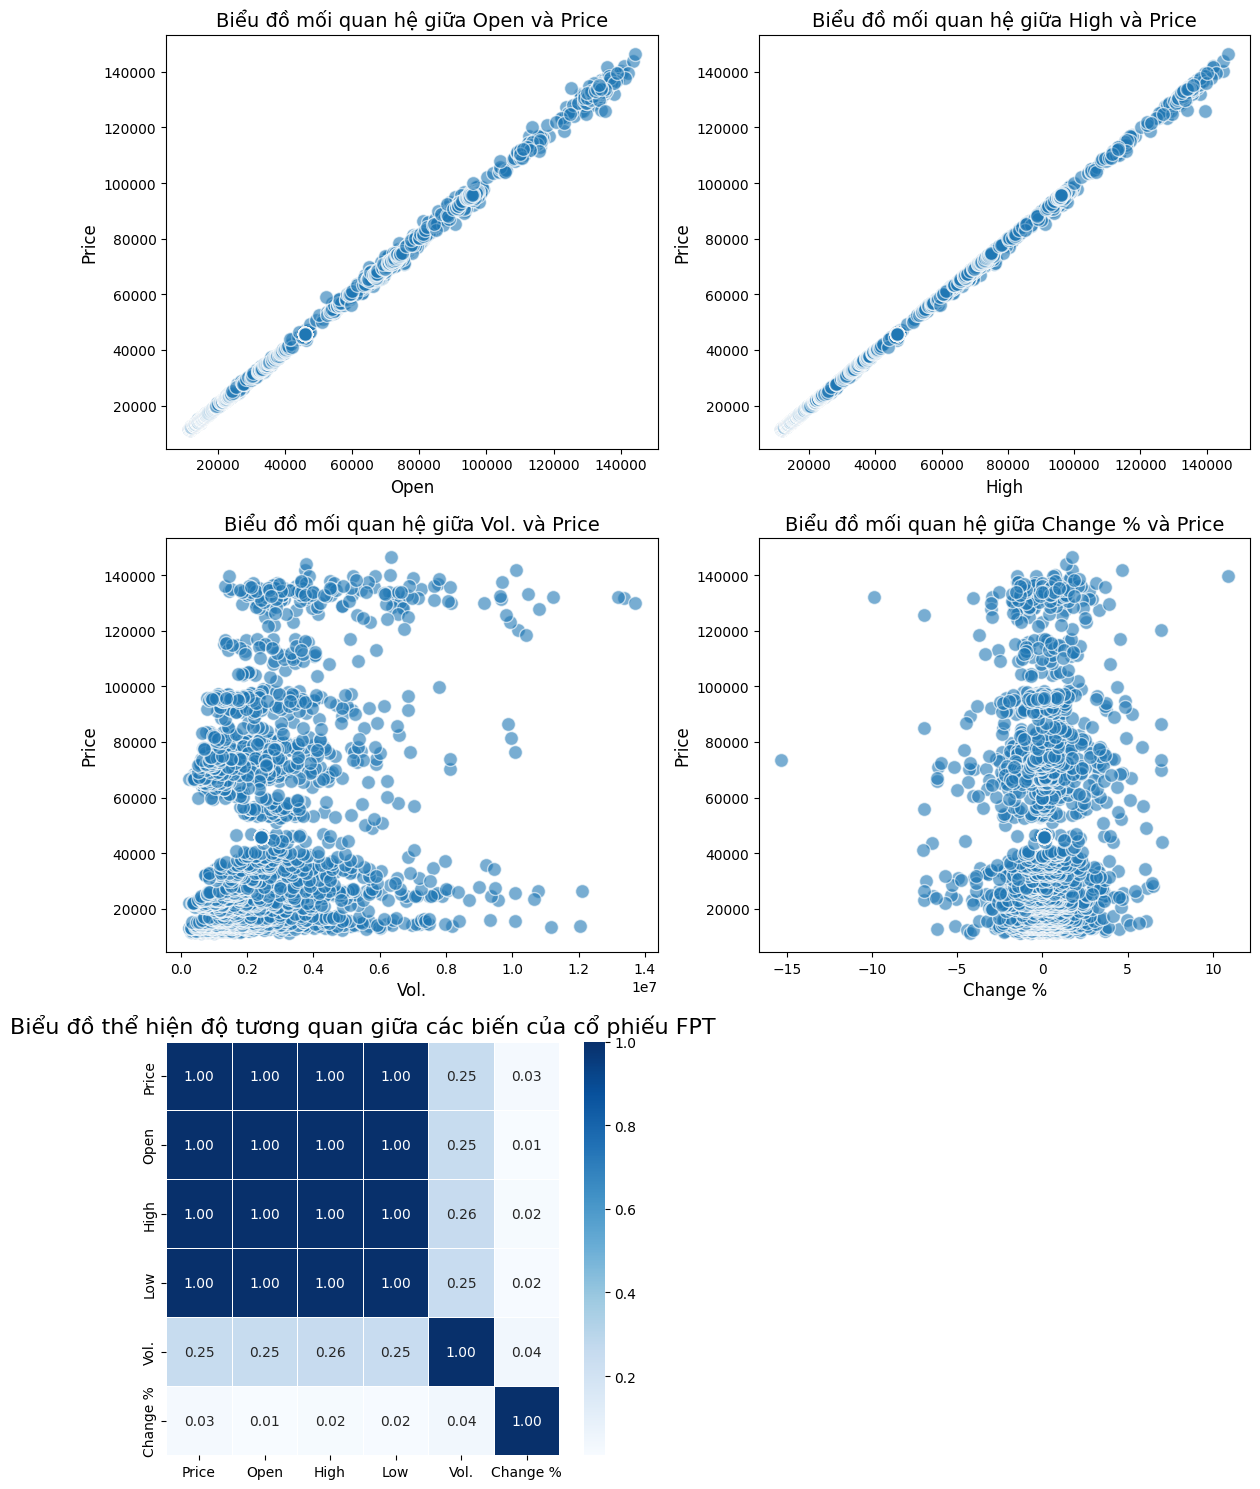

Cổ phiếu HPG


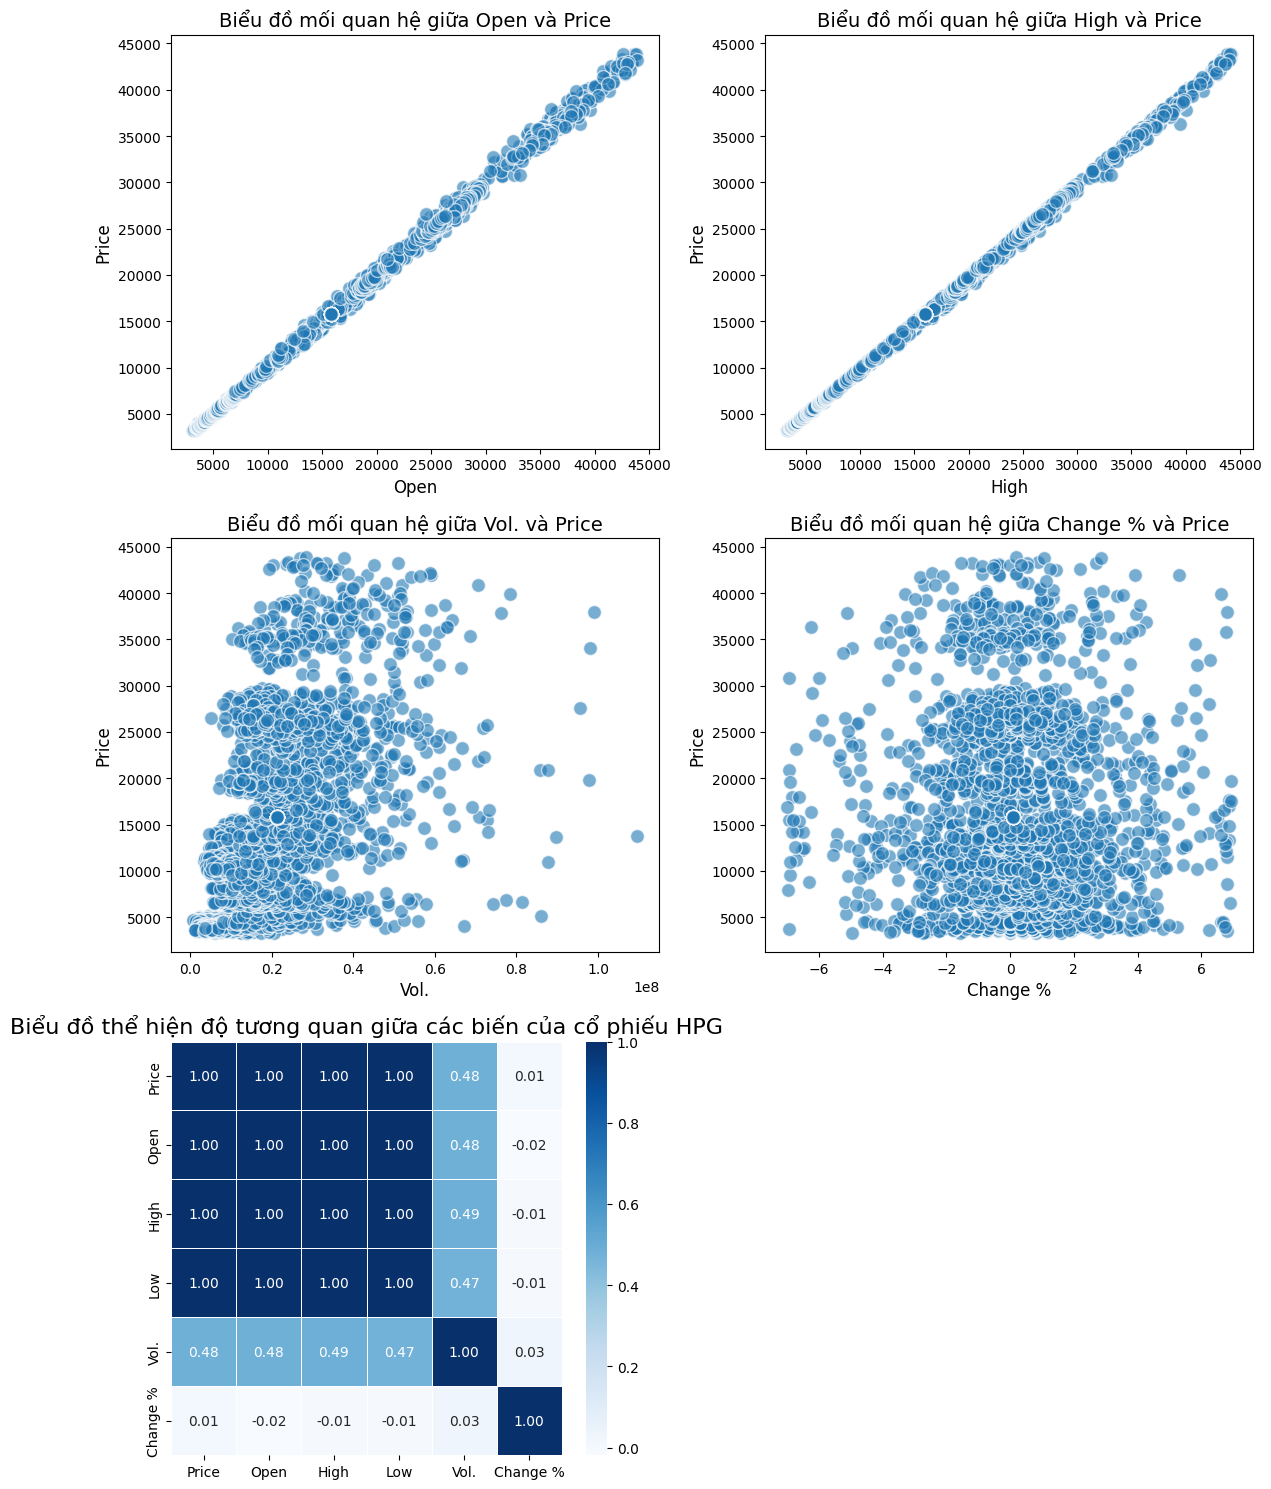

Cổ phiếu VCB


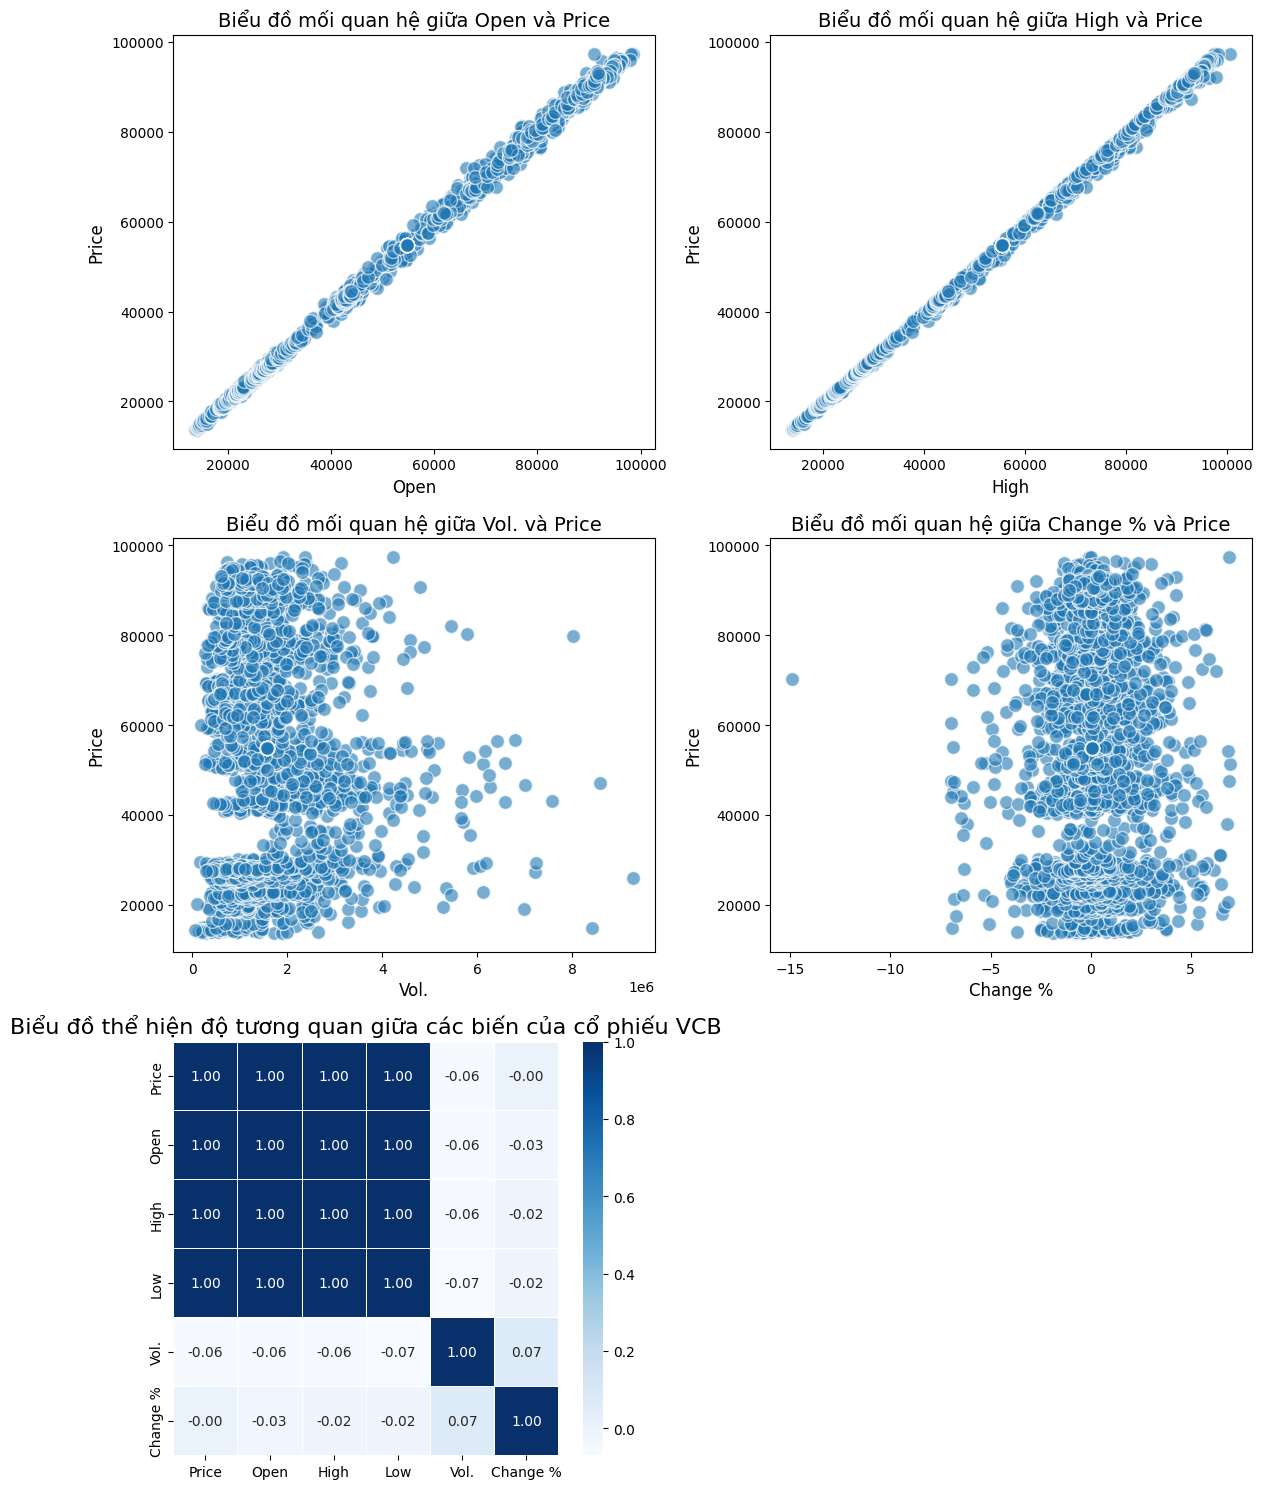

Cổ phiếu VNM


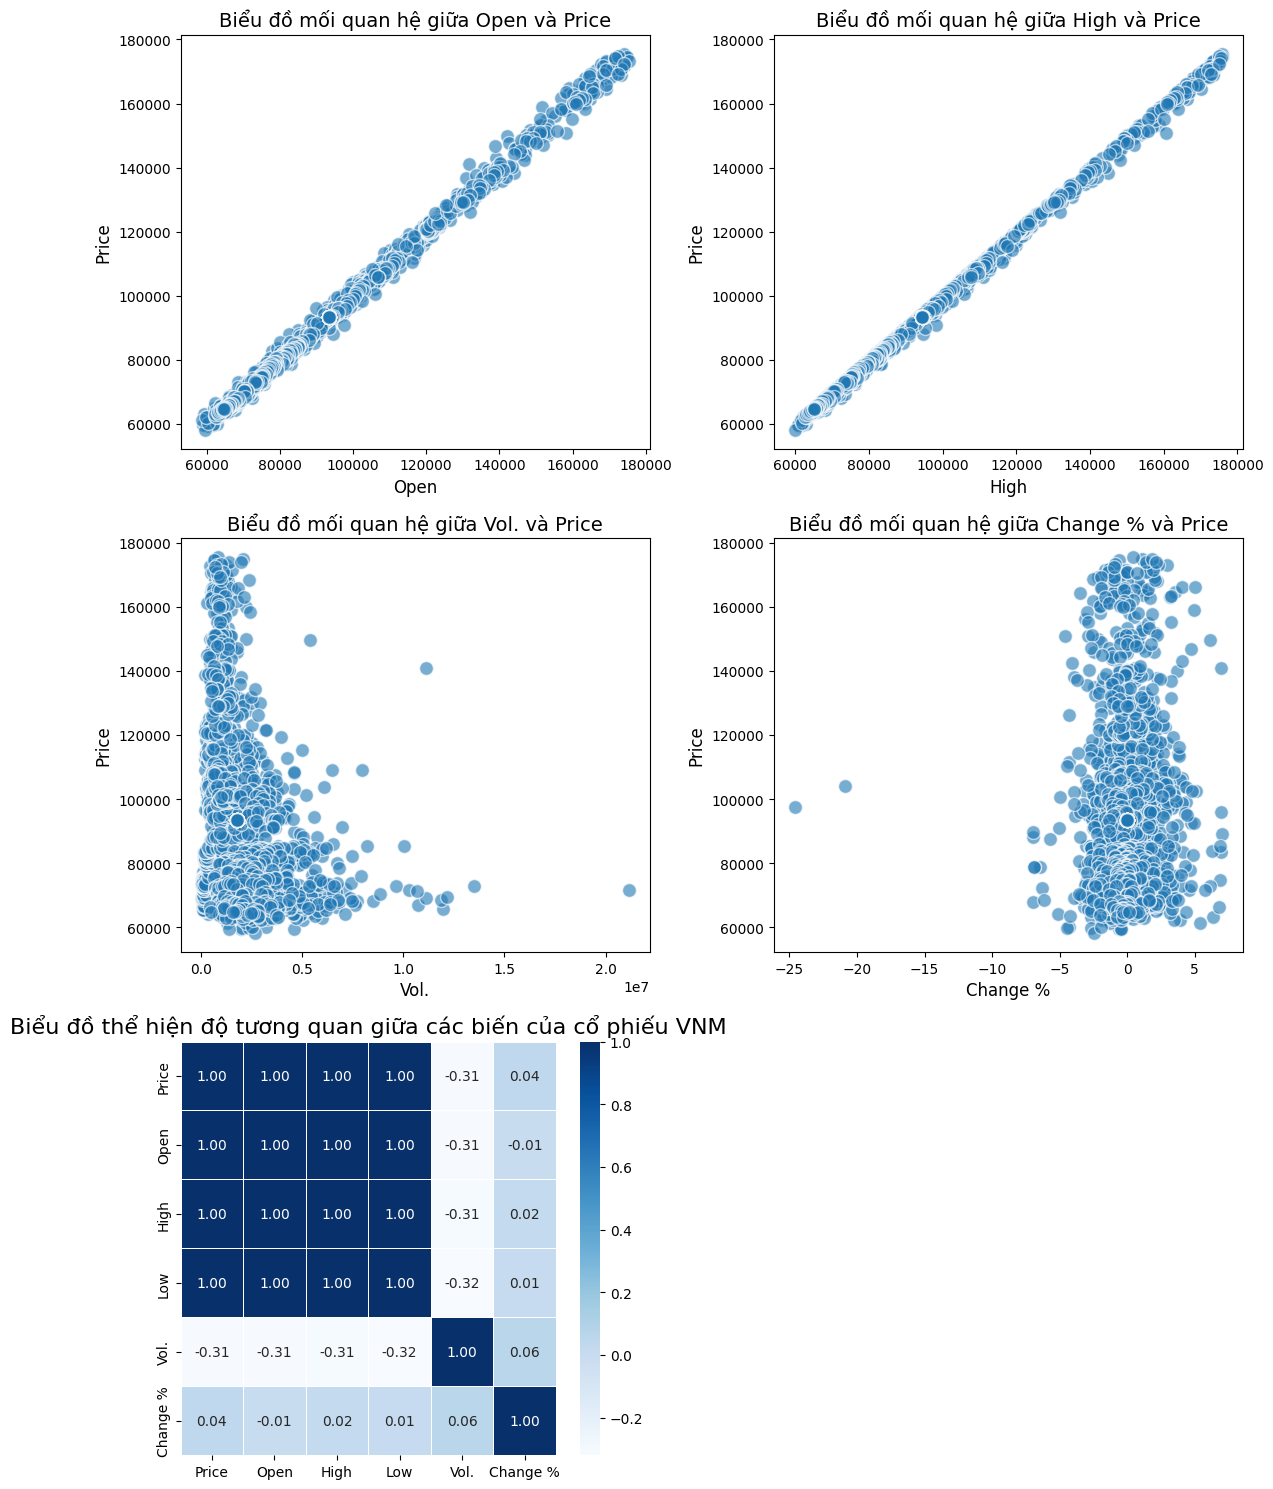

Cổ phiếu MWG


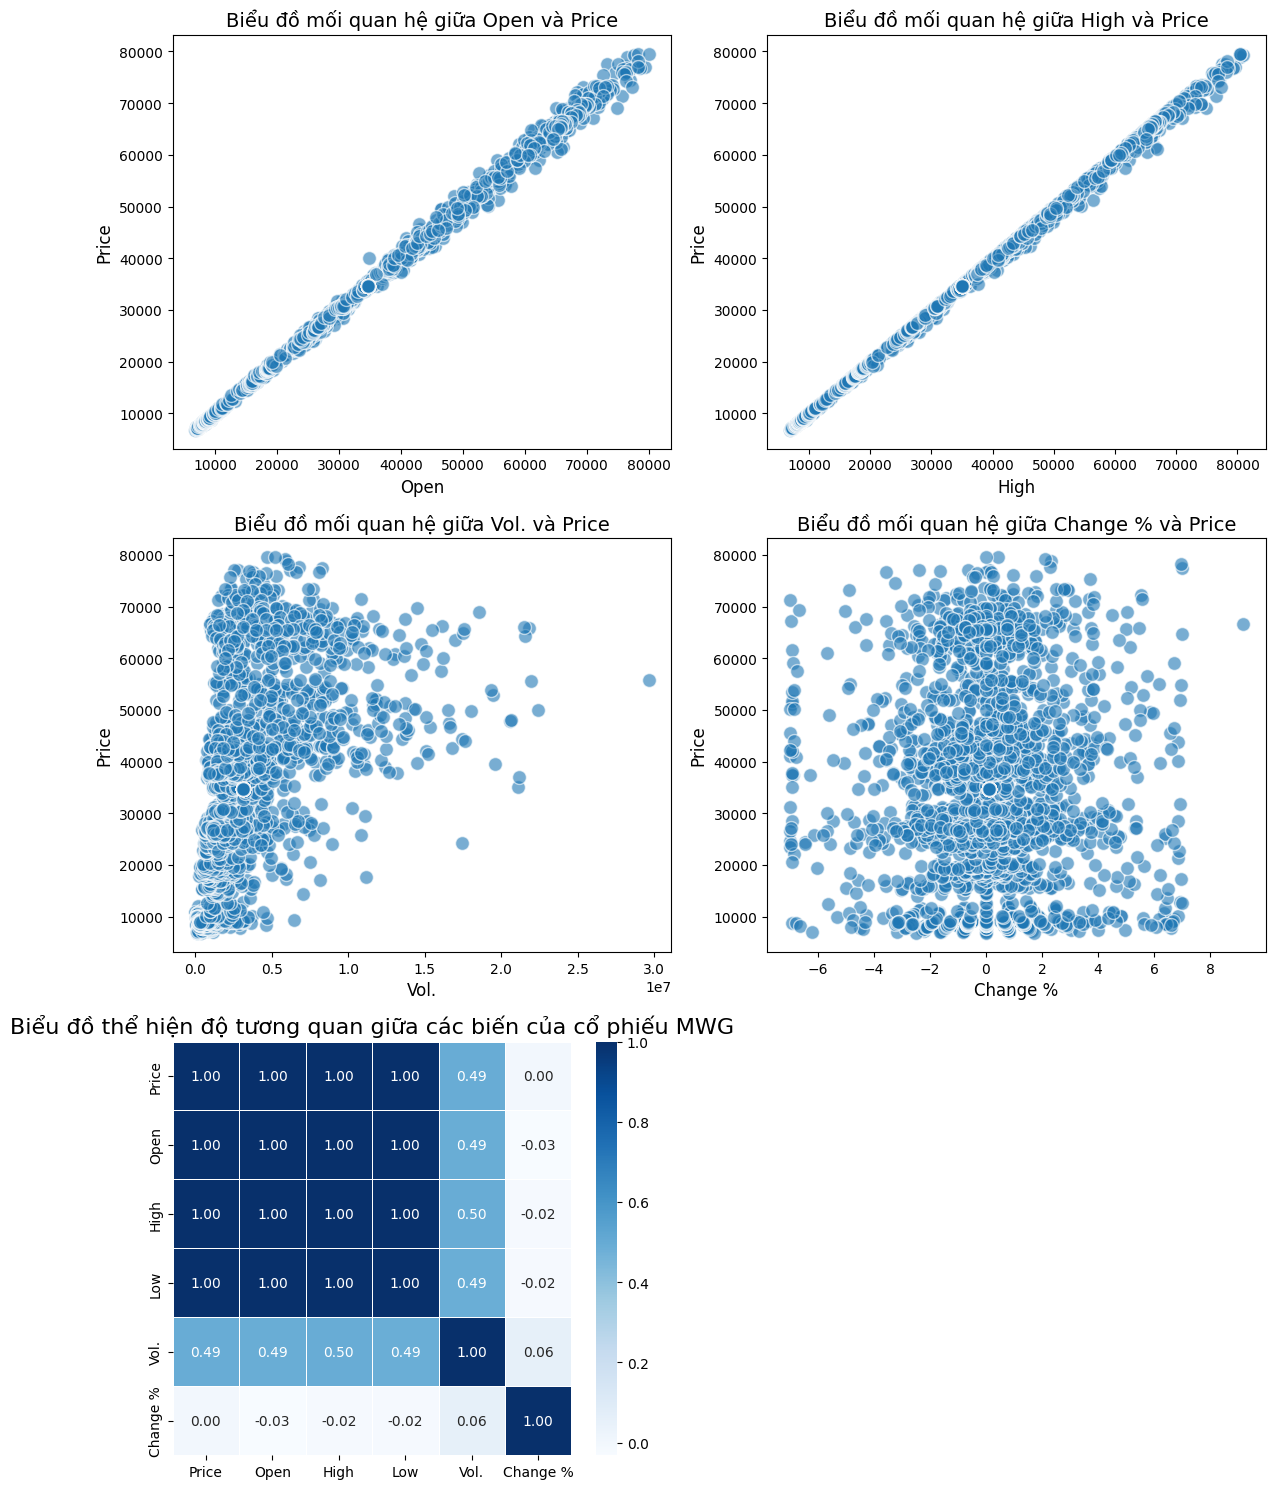

In [23]:
def relationship_plot(key, value):
    print(f"Cổ phiếu {key}")
    x_columns=['Open','High','Vol.','Change %']
    y_col='Price'
    # Tạo 1 ma trận 2x2 cho các scatter plots và 1 biểu đồ heatmap ở dưới cùng
    fig,axes=plt.subplots(3,2,figsize=(12, 15))  # 3 hàng: 2 scatter plots mỗi hàng + 1 hàng heatmap
    fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Điều chỉnh khoảng cách giữa các plot
    # Tạo scatter plots thể hiện mối quan hệ giữa các biến độc lập và biến phụ thuộc
    for i, col in enumerate(x_columns):
        i_row,i_col = divmod(i,2)  # Xác định chỉ số hàng và cột nơi đặt scatter plot
        axes[i_row, i_col].scatter(value[col], value[y_col], alpha=0.6, edgecolors='w', s=100)
        axes[i_row, i_col].set_title(f"Biểu đồ mối quan hệ giữa {col} và {y_col}", fontsize=14)
        axes[i_row, i_col].set_xlabel(col, fontsize=12)
        axes[i_row, i_col].set_ylabel(y_col, fontsize=12)
    # Tạo heatmap
    value_corr = value.corr()
    ax2 = axes[2,0]
    sns.heatmap(value_corr, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, ax=ax2)
    ax2.set_title(f"Biểu đồ thể hiện độ tương quan giữa các biến của cổ phiếu {key}", fontsize=16)
    # Tắt ô đồ thị không dùng đến
    axes[2, 1].axis('off')
    plt.tight_layout()
    plt.savefig(f"/content/drive/My Drive/Nhóm 8_KDTM_documents/Biểu đồ mối quan hệ của cổ phiếu {key}.png", format="png", dpi=300)
    plt.show()

for key, value in stock.items():
    relationship_plot(key, value)

Từ các biểu đồ trên, có thể thấy ở cả 5 cổ phiếu, biến `Vol.` và `Change %` đều không có sự tương quan đáng kể đến biến phụ thuộc là `Price` nên chúng hoàn toàn có thể bị loại bỏ

In [24]:
for key,value in stock.items():
    stock[key].drop(columns=['Vol.','Change %'],inplace=True)
    print(f"Cổ phiếu {key}")
    print(stock[key].head())

Cổ phiếu FPT
               Price      Open      High       Low
Date                                              
2014-09-03 14,247.20 14,497.20 14,622.20 14,122.30
2014-09-04 14,247.20 14,122.30 14,247.20 13,997.30
2014-09-05 14,497.20 14,247.20 14,497.20 14,247.20
2014-09-06 45,896.54 45,881.92 46,385.08 45,404.60
2014-09-07 45,896.54 45,881.92 46,385.08 45,404.60
Cổ phiếu HPG
               Price      Open      High       Low
Date                                              
2014-09-03  5,126.40  5,040.30  5,126.40  5,040.30
2014-09-04  5,255.70  5,126.40  5,341.80  5,126.40
2014-09-05  5,255.70  5,212.60  5,255.70  5,169.50
2014-09-06 15,792.35 15,797.75 16,010.80 15,592.51
2014-09-07 15,792.35 15,797.75 16,010.80 15,592.51
Cổ phiếu VCB
               Price      Open      High       Low
Date                                              
2014-09-03 14,923.00 14,765.00 15,029.00 14,765.00
2014-09-04 15,187.00 14,818.00 15,187.00 14,660.00
2014-09-05 15,451.00 15,187.00 15,503.00 15

Tiếp theo cần kiểm tra xem giá cổ phiếu ở hiện tại có độ tương quan nhất định nào với chính nó ở quá khứ không. Nói cách khác, cần tìm hiểu xem giá cổ phiếu ở quá khứ có tác động gì về mặt thống kê với giá cổ phiếu ở hiện tại không

Cổ phiếu FPT


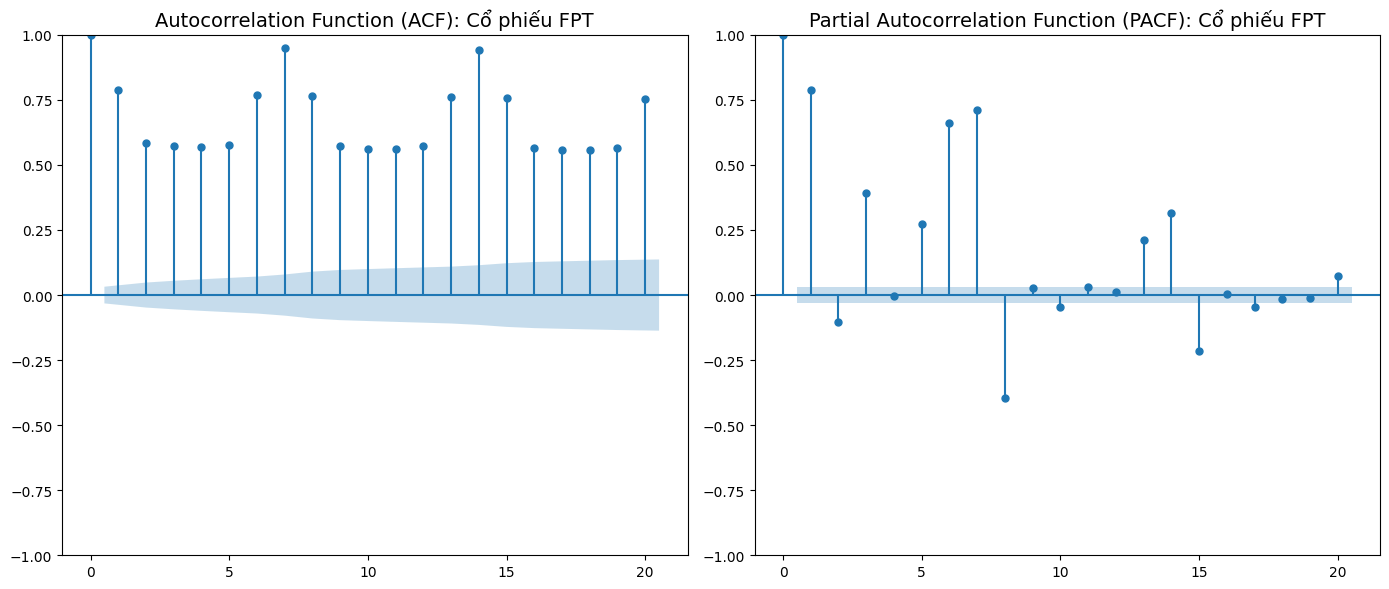

Cổ phiếu HPG


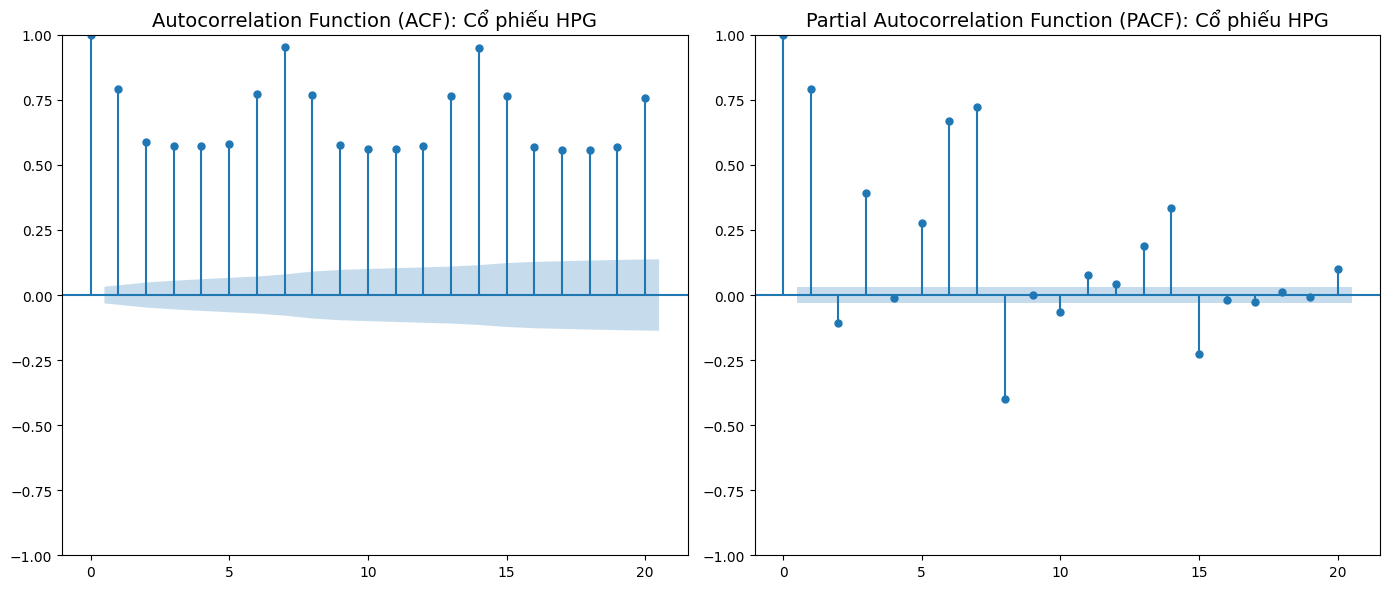

Cổ phiếu VCB


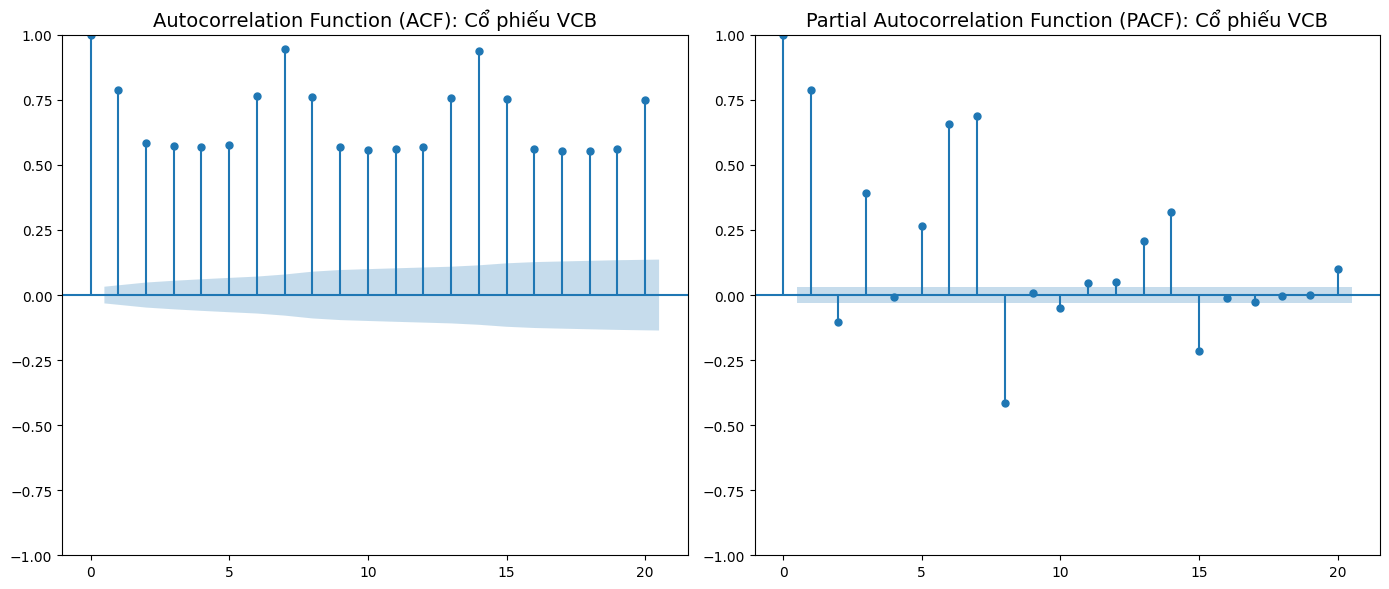

Cổ phiếu VNM


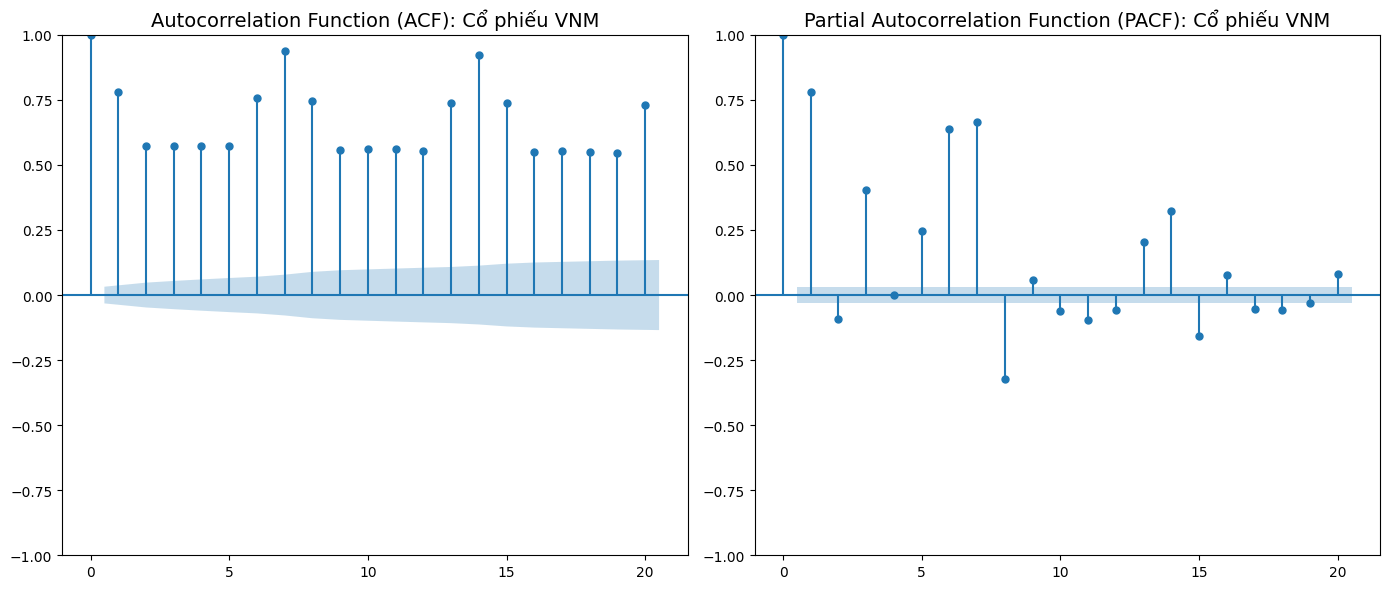

Cổ phiếu MWG


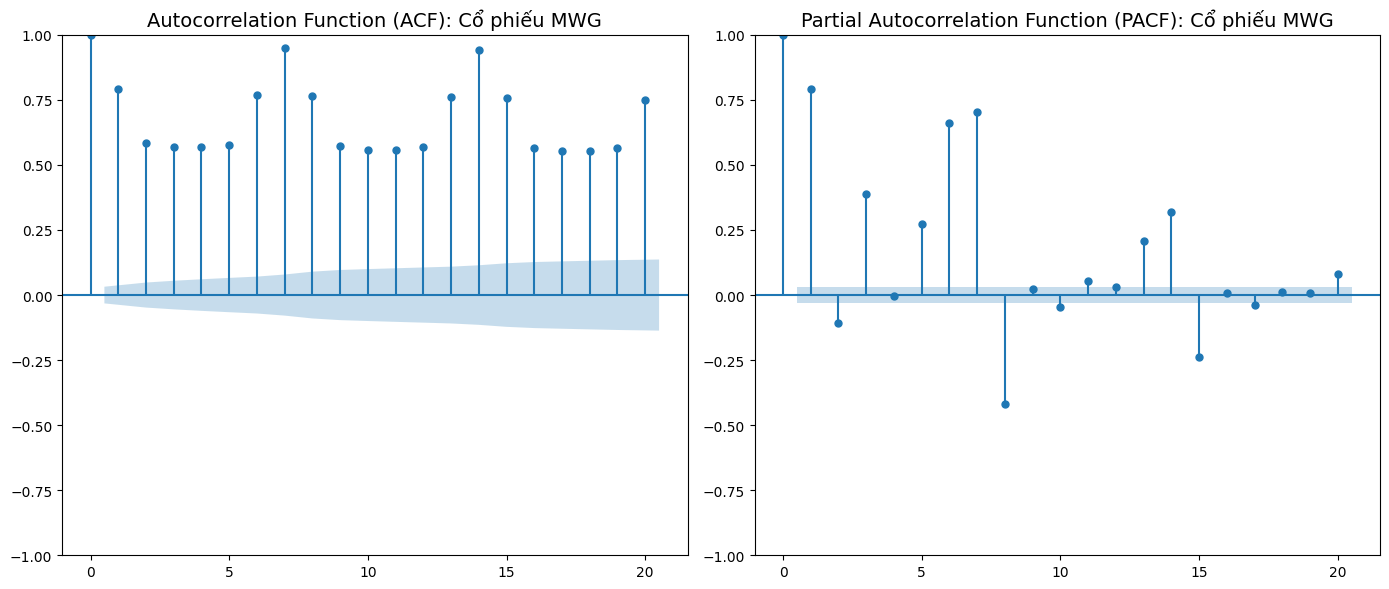

In [25]:
def acf_pacf(stock, n_lags, pic_name):
    for key, value in stock.items():
        print(f"Cổ phiếu {key}")
        price = value['Price']
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 hàng, 2 cột (ACF và PACF)
        # Vẽ ACF
        plot_acf(price, ax=axes[0], lags=n_lags)
        axes[0].set_title(f'Autocorrelation Function (ACF): Cổ phiếu {key}', fontsize=14)
        # Vẽ PACF
        plot_pacf(price, ax=axes[1], lags=n_lags)
        axes[1].set_title(f'Partial Autocorrelation Function (PACF): Cổ phiếu {key}', fontsize=14)

        plt.tight_layout()
        plt.savefig(f"{pic_name}_{key}.png", format="png", dpi=300)
        plt.show()

acf_pacf(stock, 20, "/content/drive/My Drive/Nhóm 8_KDTM_documents/Acf_pacf")

### Từ các đồ thị này có thể rút ra kết luận:

Từ đồ thị ACF và PACF ở trên, có thể thấy các giá trị tương quan của giá quá khứ với giá hiện tại lặp lại sau mỗi chu kỳ 7 ngày (chu kỳ 1 tuần). Tức là sau mỗi 7 ngày, giá trị tương quan sẽ đạt đỉnh. Thêm nữa, giá trị độ trễ ngay trước và ngay sau đó 1 ngày cũng có độ tương quan cao (lớn hơn 0.75). Vậy nên nhóm quyết định sẽ tạo ra các giá trị giá ở quá khứ chu kỳ 7 ngày để dự đoán giá hiện tại. Tuy nhiên nhóm quyết định sẽ chỉ lùi tối đa 60 ngày do mô hình của nhóm chỉ có mục đích dự đoán giá cổ phiếu trong ngắn hạn, không phải dài hạn

In [26]:
past_days = range(1,61)
for key,value in stock.items():
    for i in past_days:
        stock[key][f"Price past {i} days"] = value['Price'].shift(i)
    print(f"Cổ phiếu {key}")
    print(stock[key].head(10))

Cổ phiếu FPT
               Price      Open      High       Low  Price past 1 days  \
Date                                                                    
2014-09-03 14,247.20 14,497.20 14,622.20 14,122.30                NaN   
2014-09-04 14,247.20 14,122.30 14,247.20 13,997.30          14,247.20   
2014-09-05 14,497.20 14,247.20 14,497.20 14,247.20          14,247.20   
2014-09-06 45,896.54 45,881.92 46,385.08 45,404.60          14,497.20   
2014-09-07 45,896.54 45,881.92 46,385.08 45,404.60          45,896.54   
2014-09-08 14,622.20 14,622.20 14,872.10 14,497.20          45,896.54   
2014-09-09 13,872.30 14,622.20 14,622.20 13,622.40          14,622.20   
2014-09-10 13,997.30 13,872.30 14,122.30 13,622.40          13,872.30   
2014-09-11 13,872.30 13,997.30 14,122.30 13,872.30          13,997.30   
2014-09-12 13,997.30 13,997.30 14,122.30 13,747.30          13,872.30   

            Price past 2 days  Price past 3 days  Price past 4 days  \
Date                                   

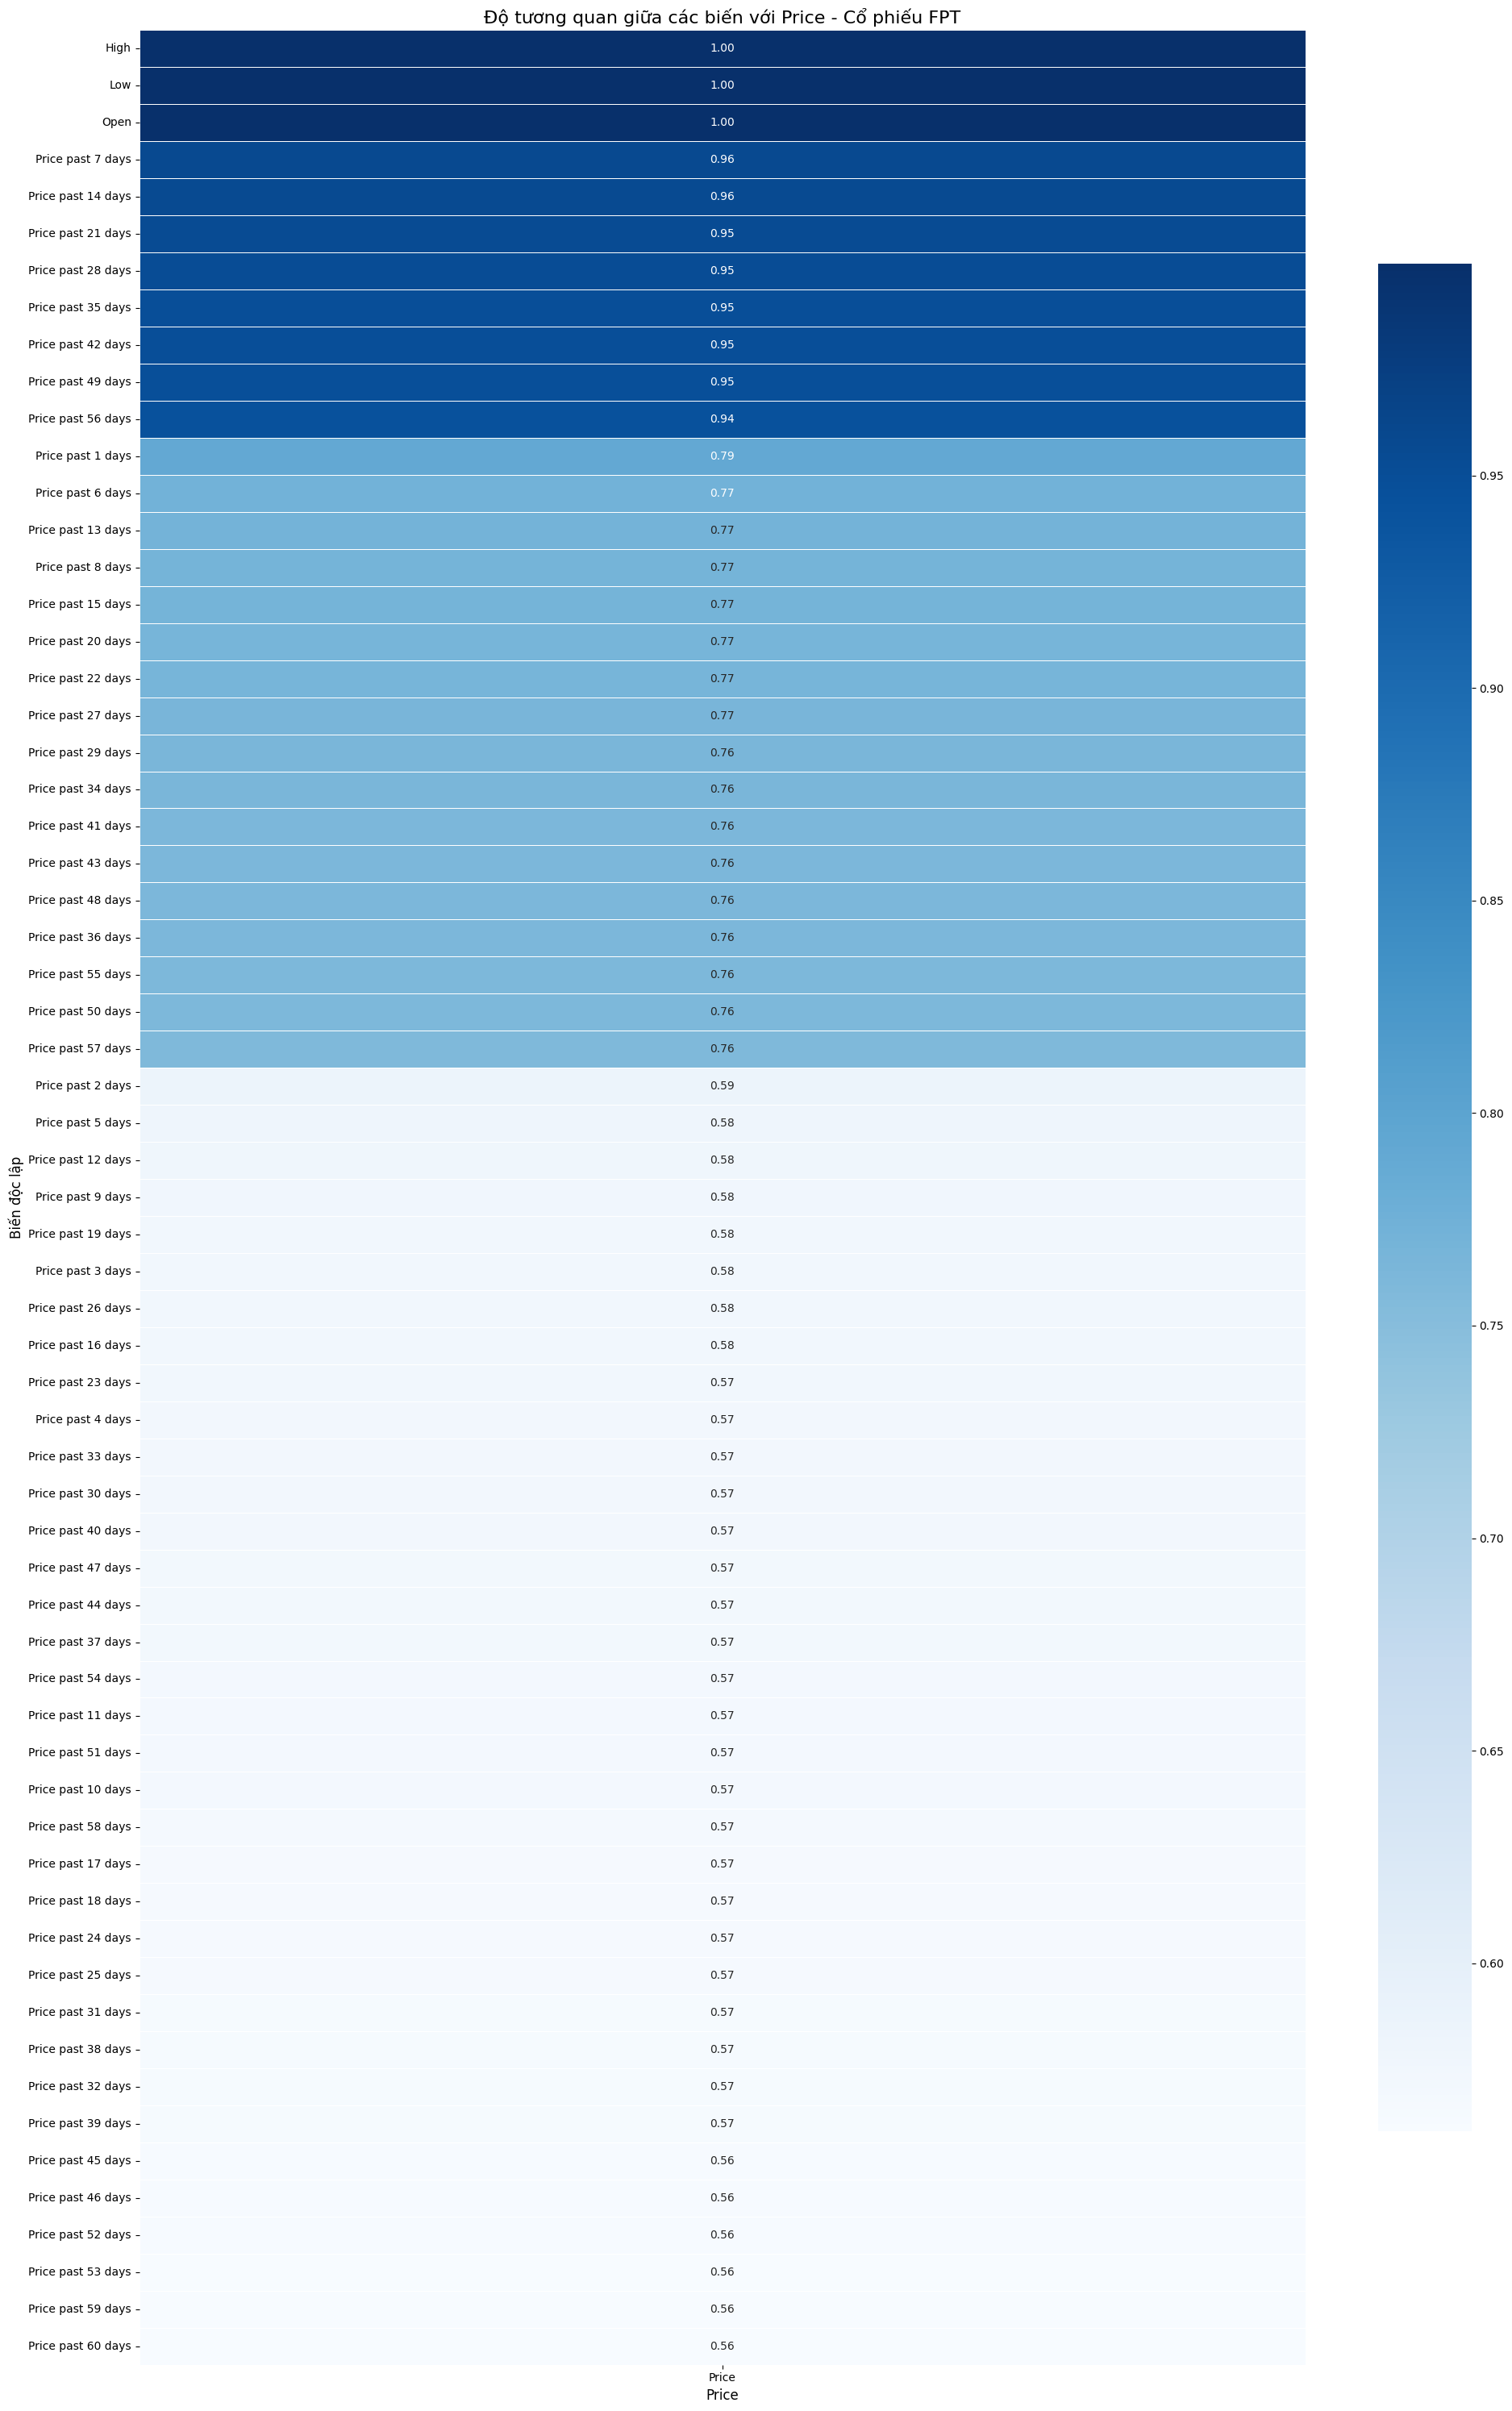

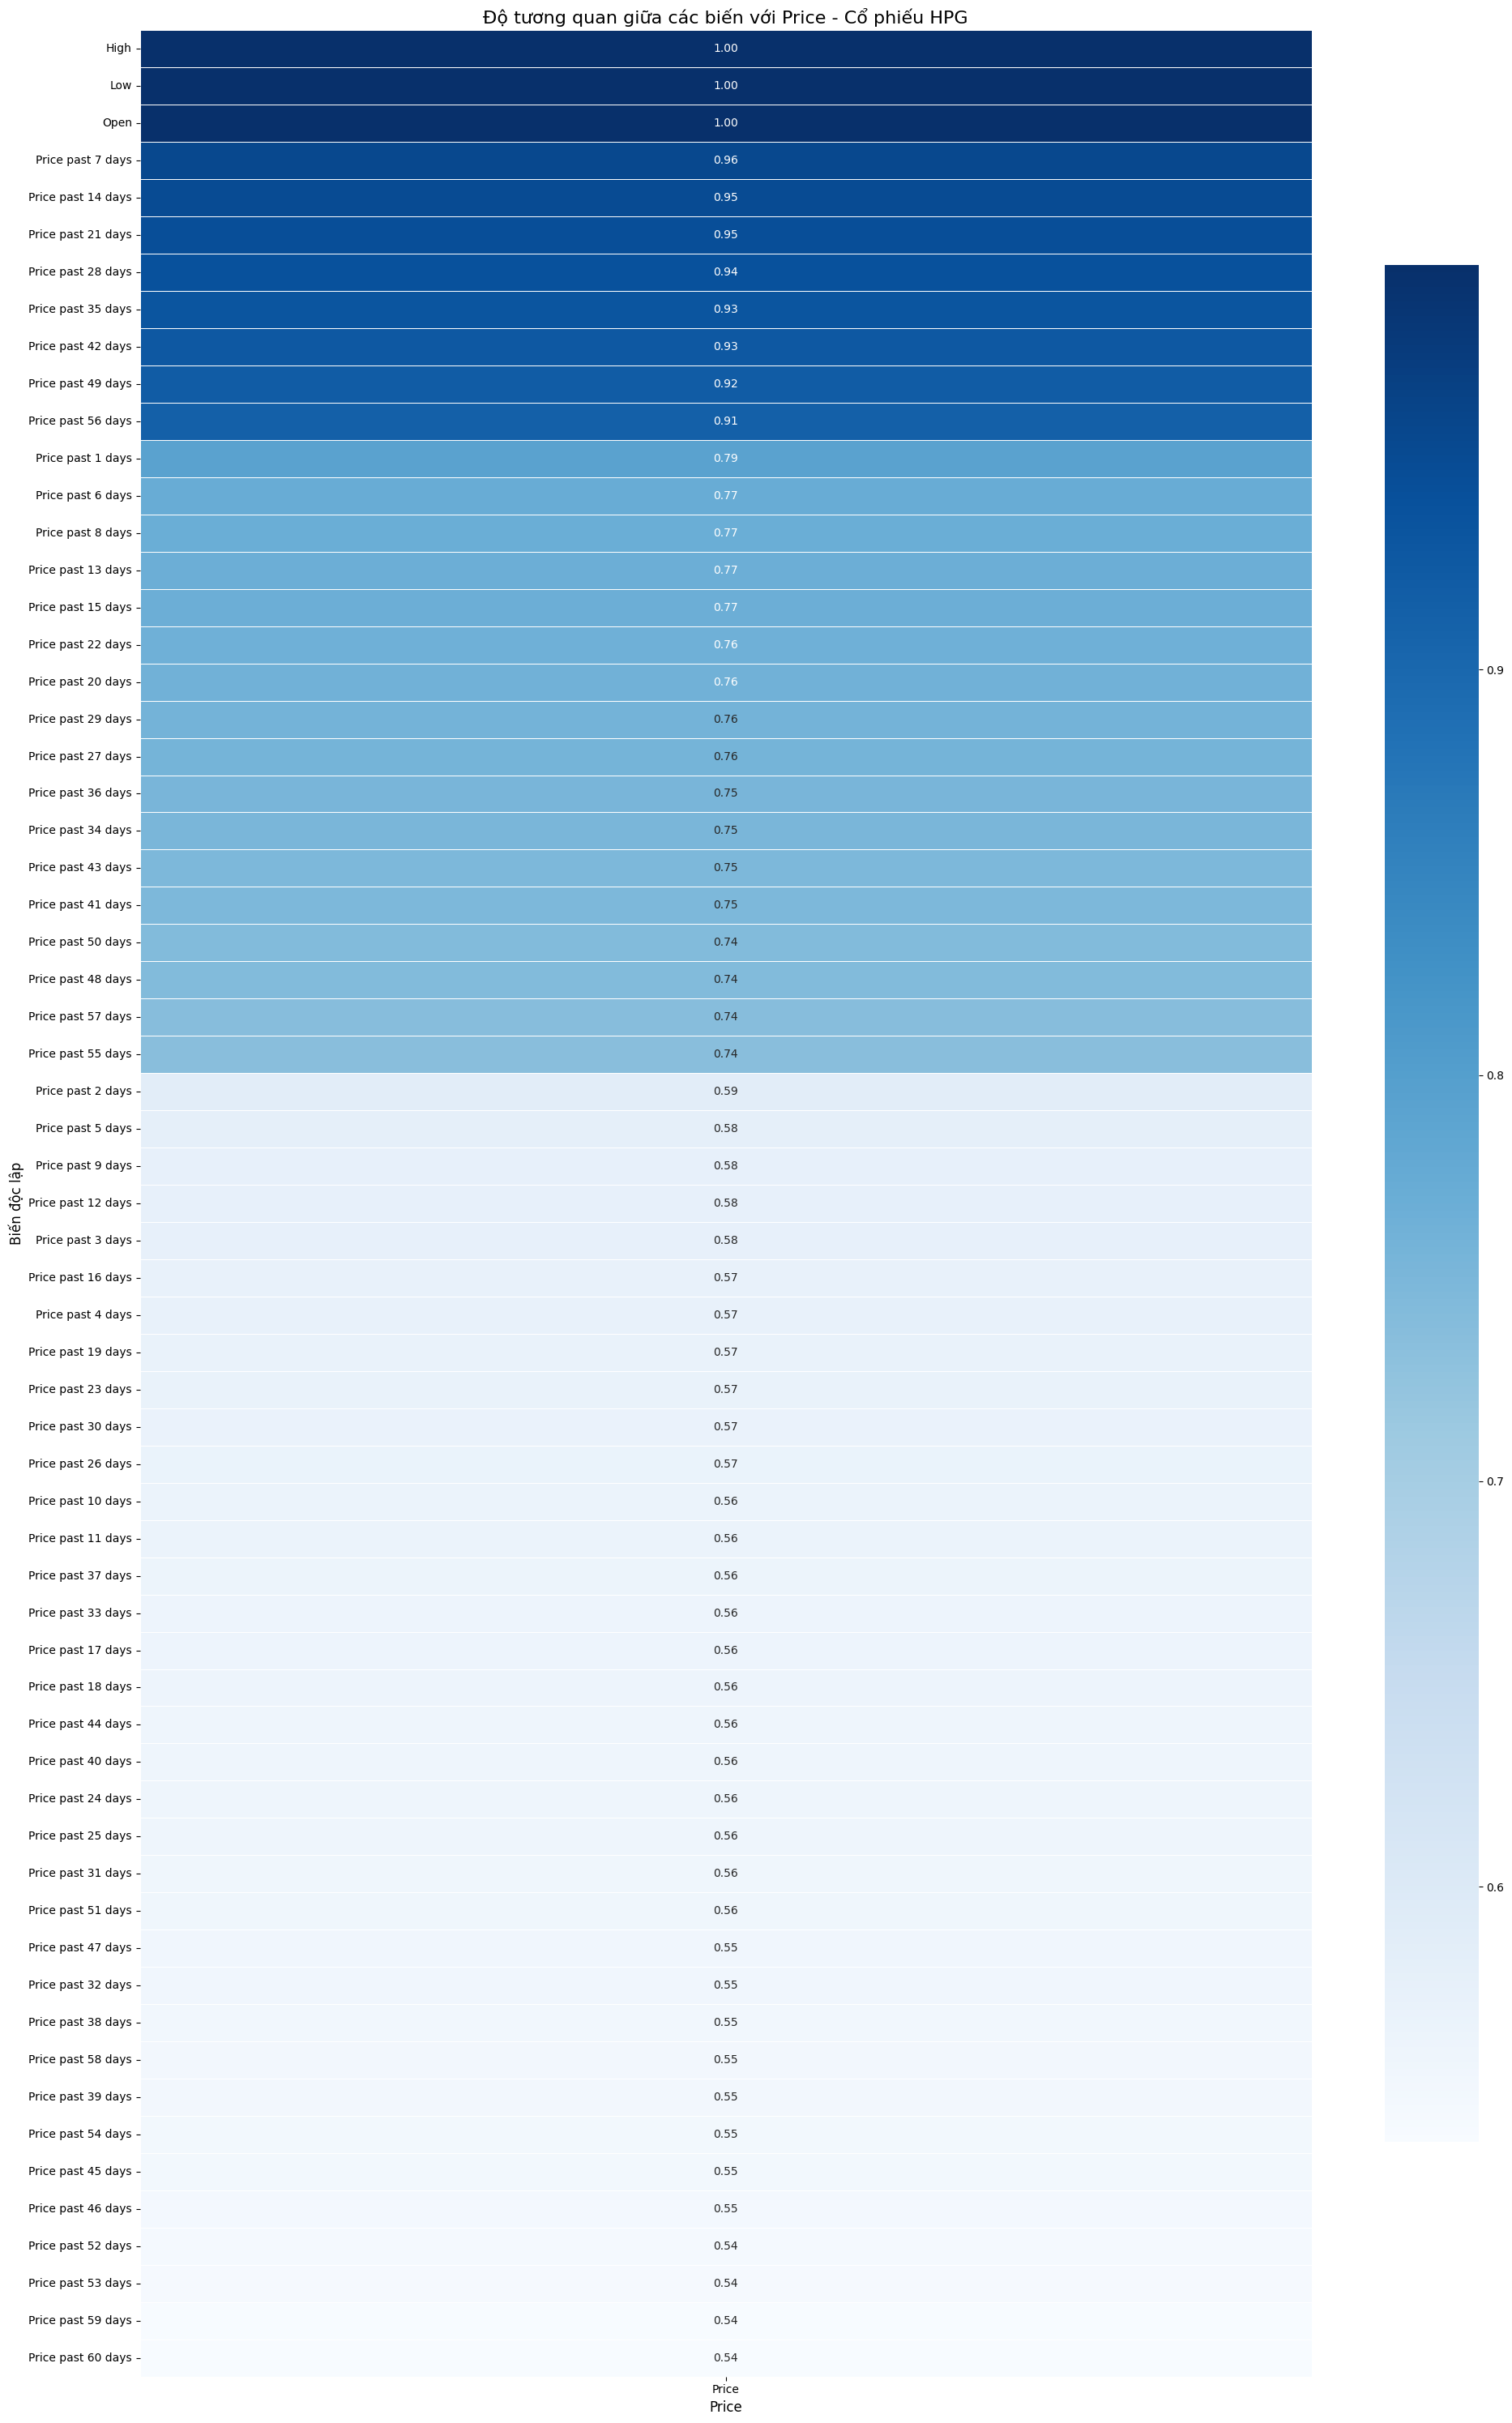

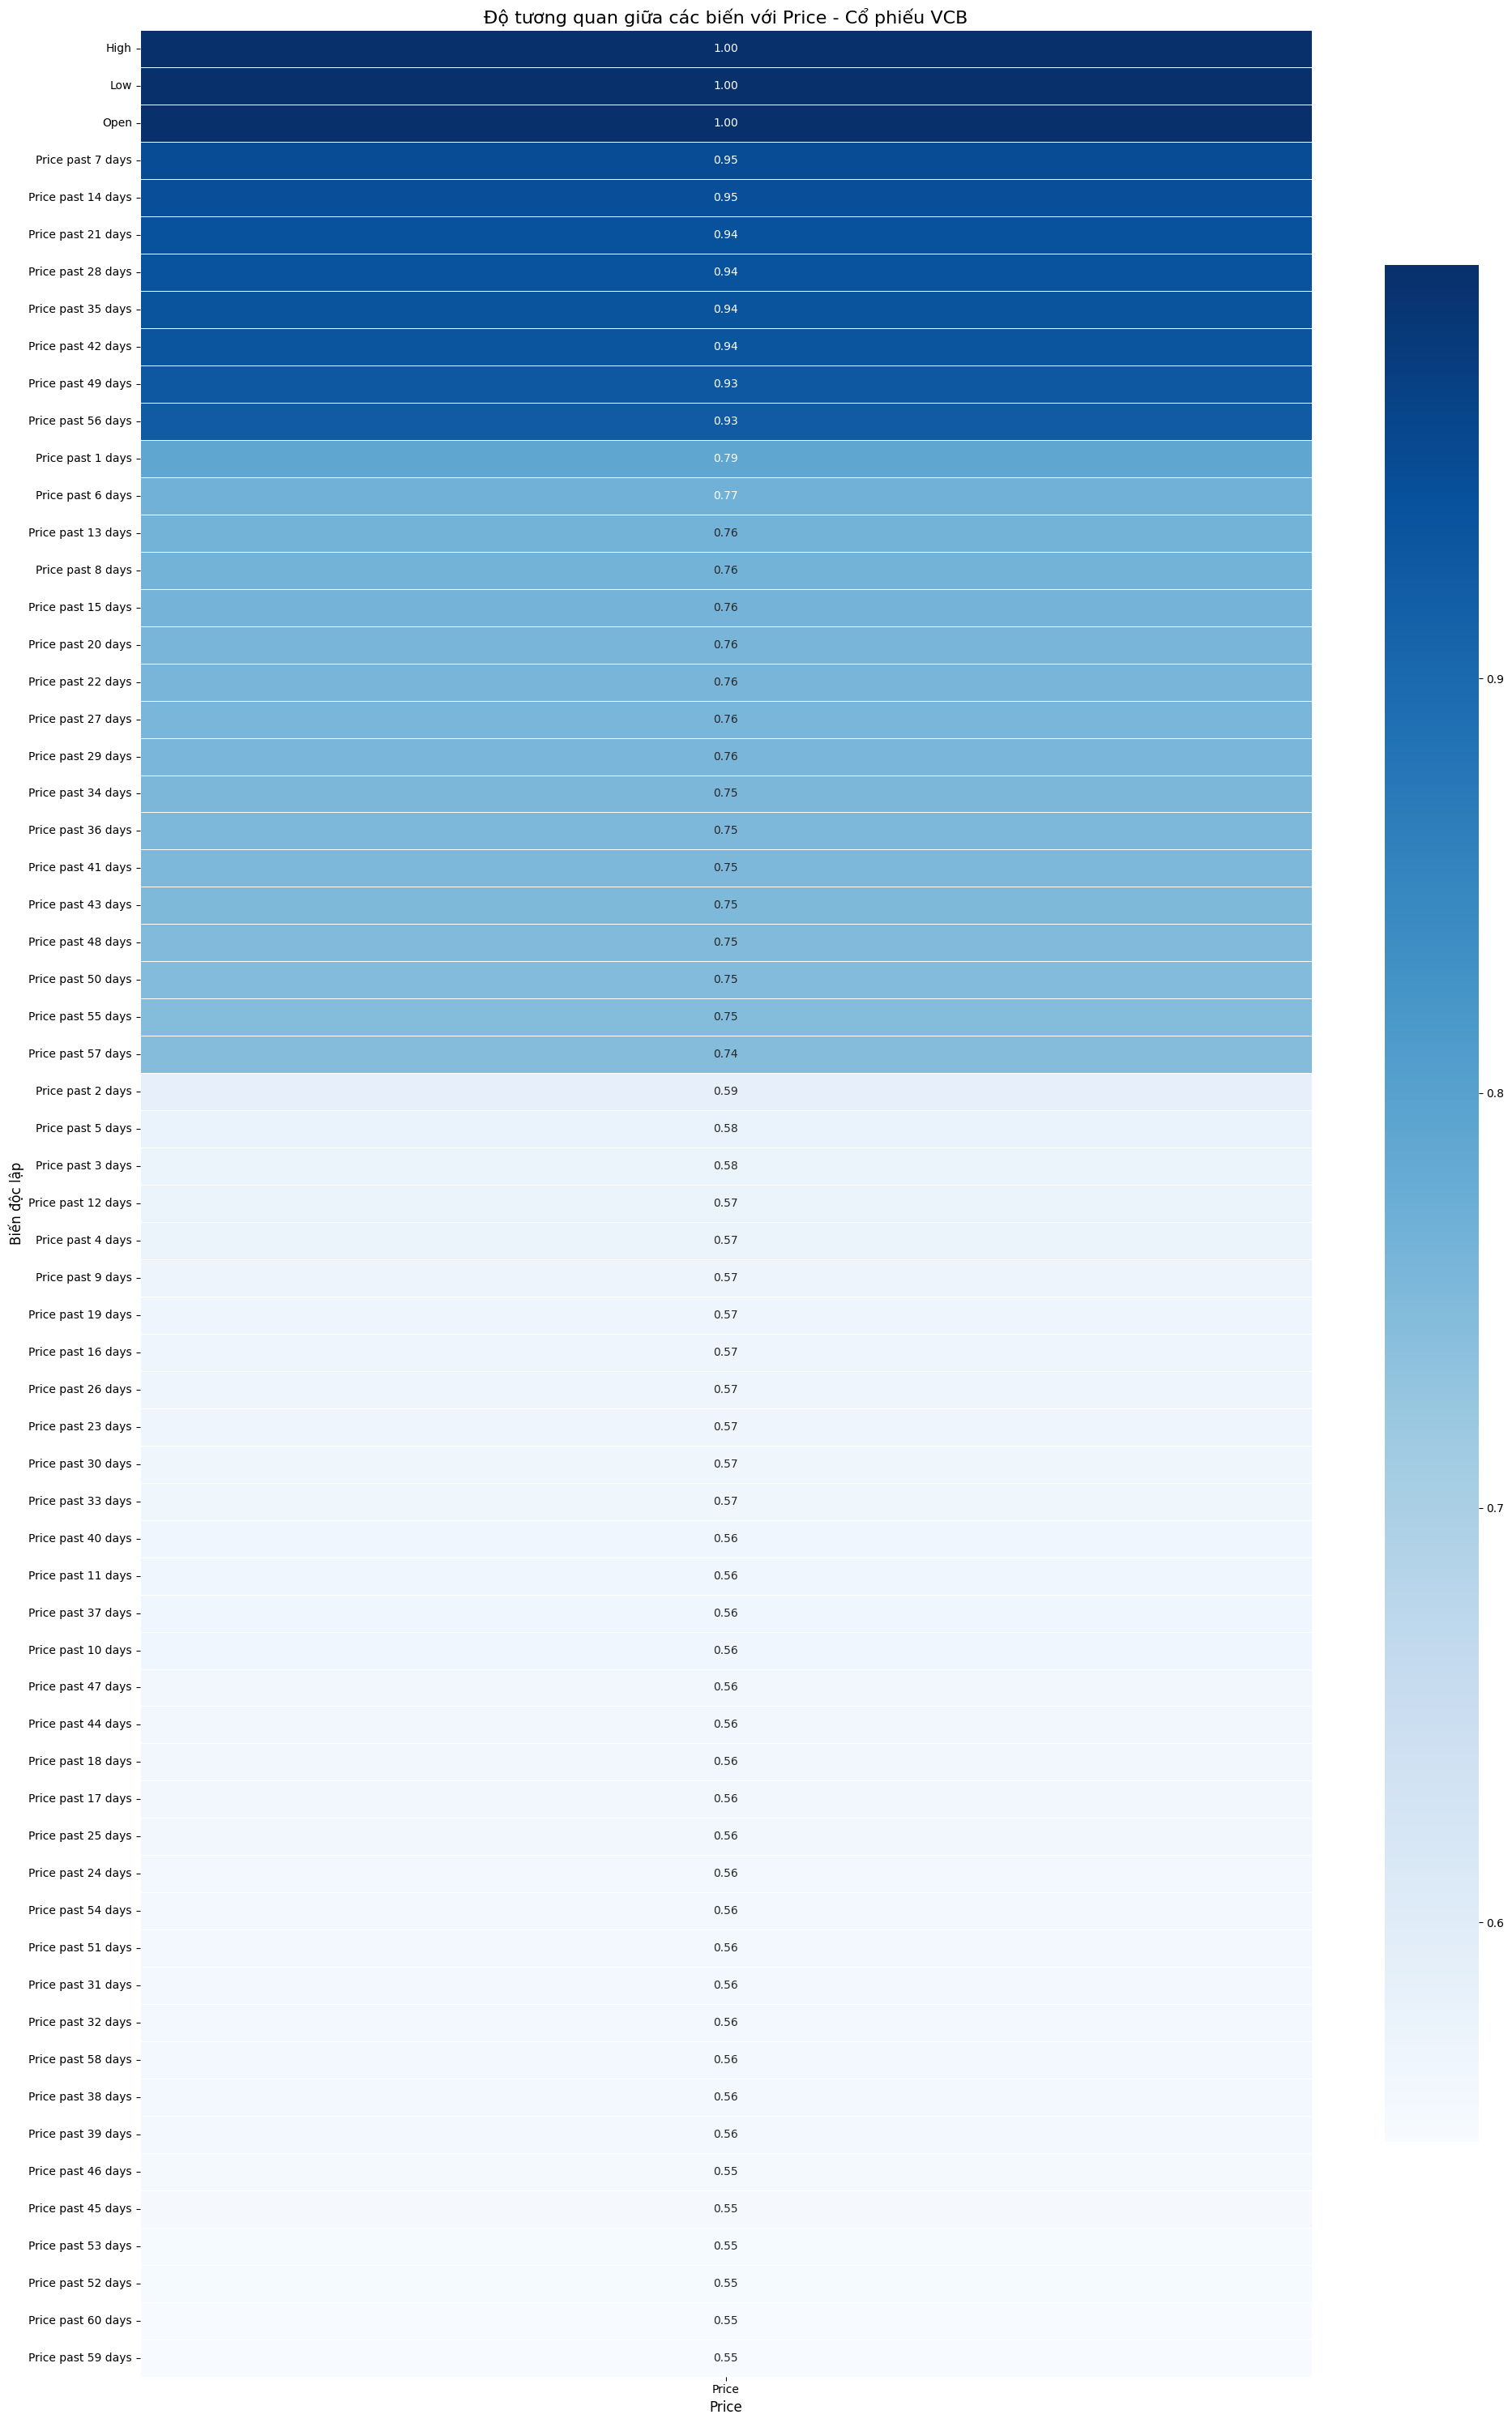

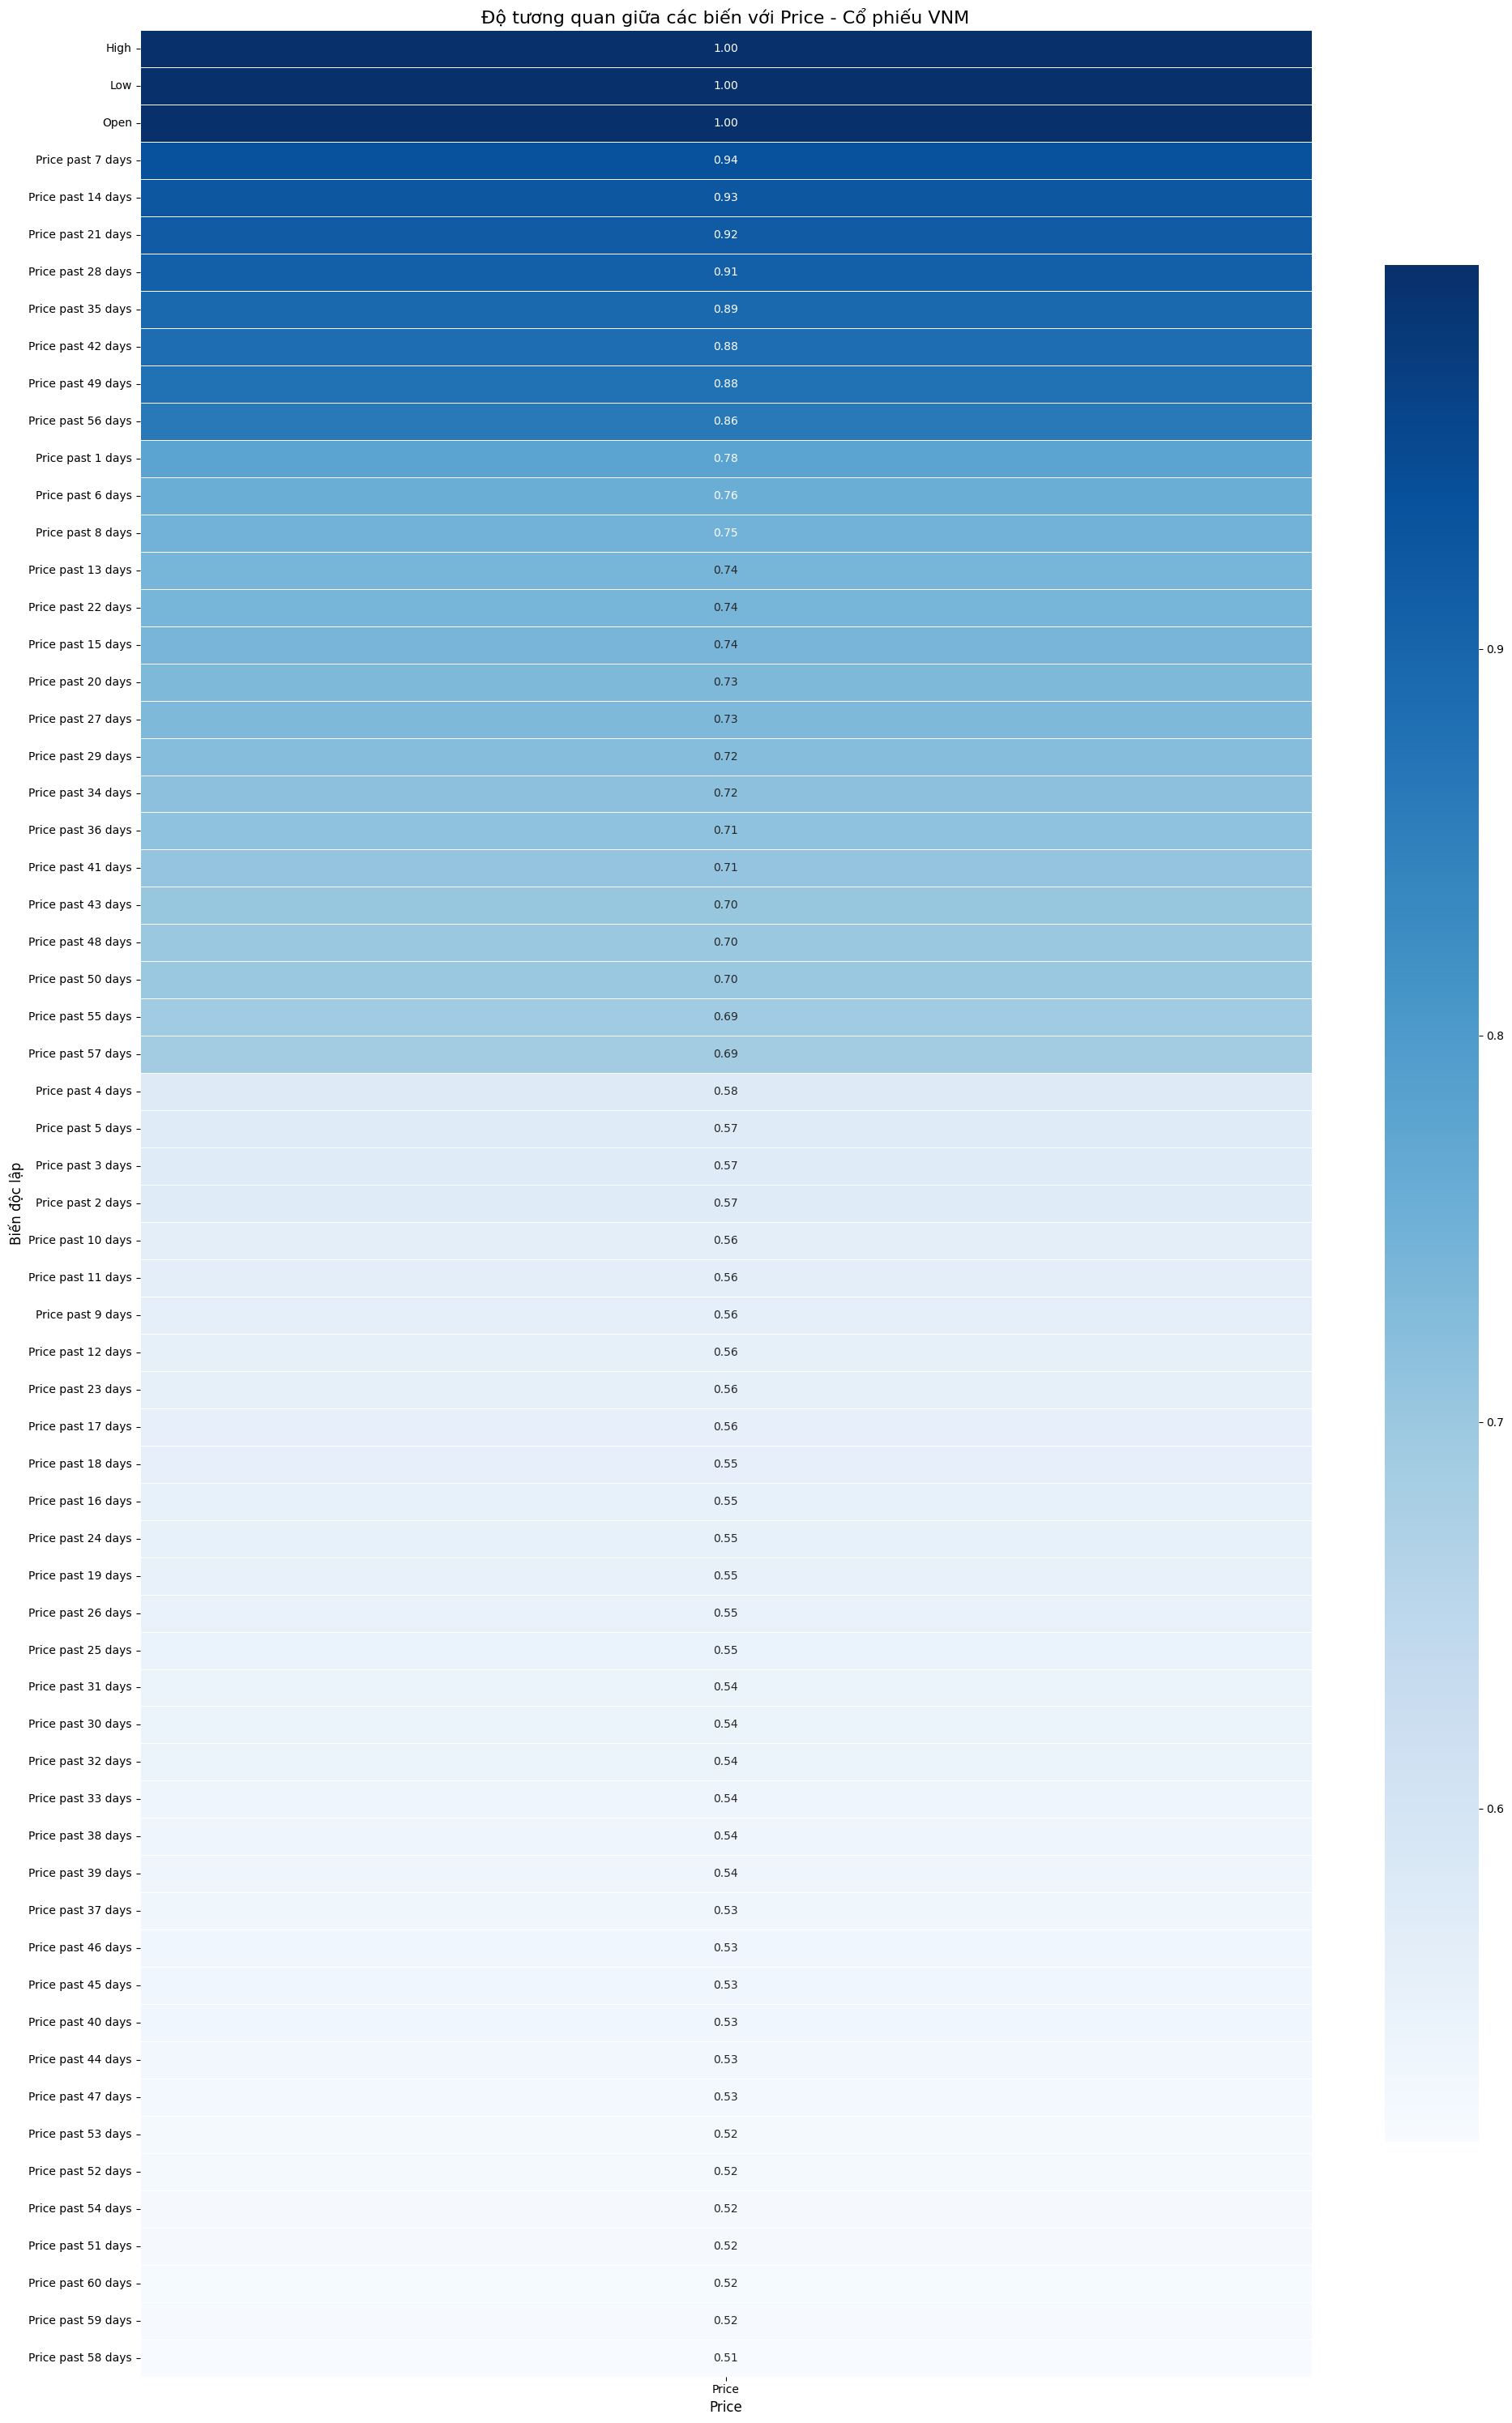

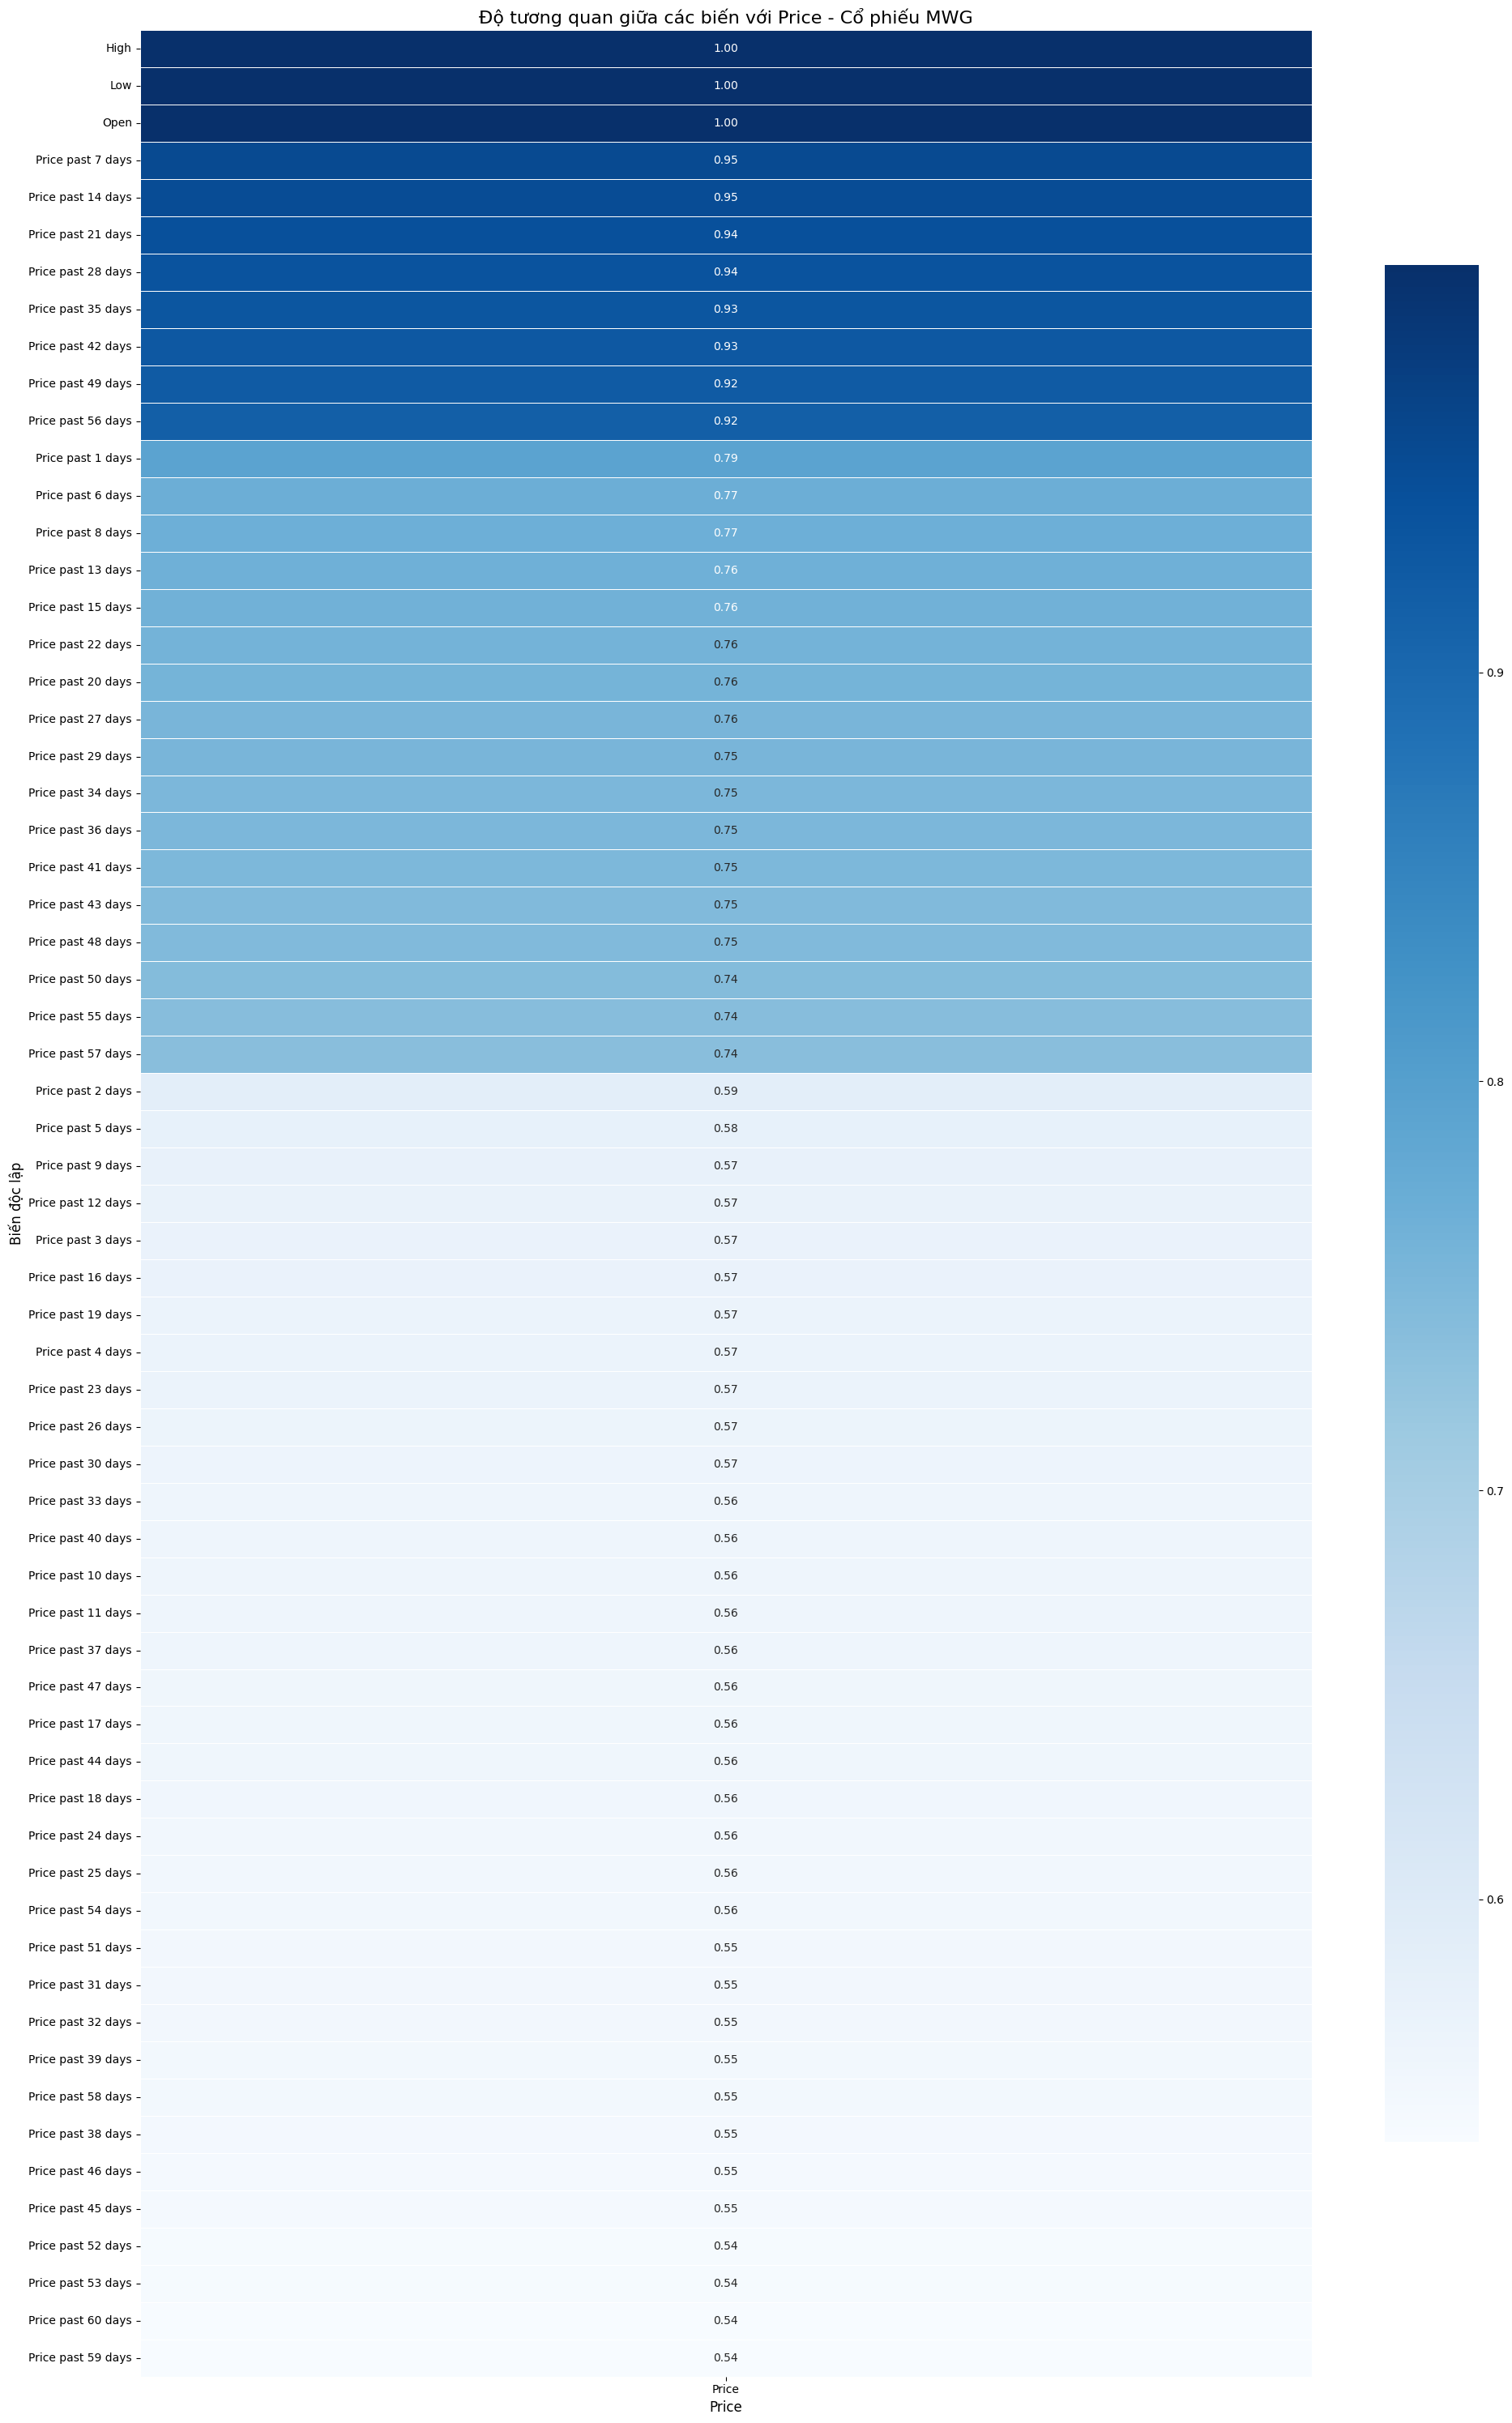

In [27]:
def corr_plot(stock, pic_name):
    for key, value in stock.items():
        value_corr = value.corr()
        if 'Price' not in value_corr.columns:
            continue
        price_corr = value_corr[['Price']].drop('Price')  # Loại bỏ dòng 'Price'

        # Sắp xếp độ tương quan theo thứ tự giảm dần
        price_corr = price_corr.sort_values(by='Price', ascending=False)

        # Vẽ heatmap
        plt.figure(figsize=(20,30))
        sns.heatmap(price_corr, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
        plt.title(f"Độ tương quan giữa các biến với Price - Cổ phiếu {key}", fontsize=16)
        plt.ylabel("Biến độc lập", fontsize=12)
        plt.xlabel("Price", fontsize=12)

        # Lưu biểu đồ
        plt.tight_layout()
        plt.savefig(f"{pic_name}_{key}.png", format="png", dpi=300)
        plt.show()

corr_plot(stock,"/content/drive/My Drive/Nhóm 8_KDTM_documents/Correlation")

Từ biểu đồ này có thể thấy các biến độc lập đều có độ tương quan rất cao đối với biến phụ thuộc là `Price`. Điều này có thể là một điều tốt, tuy nhiên, nó làm nổi lên 1 nghi vấn mới khi có thể xảy ra sự đa cộng tuyến giữa các biến độc lập với nhau và điều này làm ảnh hưởng đến chất lượng mô hình. Vì vậy, cần có 1 kiểm định để kiểm tra sự đa cộng tuyến

In [28]:
def VIF(stock):
    for key, value in stock.items():
      X = value.drop(columns=['Price'])
      X = X.bfill()
      X['Intercept'] = 1
      vif_data = pd.DataFrame()
      vif_data['Variable'] = X.columns
      vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
      vif_data = vif_data[vif_data['Variable'] != 'Intercept']
      print(f"Bảng độ đa cộng tuyến của các biến độc lập của cổ phiếu {key}:")
      print(vif_data.sort_values(by='VIF',ascending=False))
VIF(stock)

Bảng độ đa cộng tuyến của các biến độc lập của cổ phiếu FPT:
              Variable      VIF
0                 Open 4,356.54
1                 High 3,057.43
2                  Low 2,808.58
16  Price past 14 days    36.21
17  Price past 15 days    36.20
..                 ...      ...
56  Price past 54 days    33.15
57  Price past 55 days    33.14
60  Price past 58 days    32.86
61  Price past 59 days    32.29
62  Price past 60 days    24.10

[63 rows x 2 columns]
Bảng độ đa cộng tuyến của các biến độc lập của cổ phiếu HPG:
              Variable      VIF
0                 Open 2,780.65
2                  Low 2,138.32
1                 High 2,123.83
32  Price past 30 days    36.01
33  Price past 31 days    35.97
..                 ...      ...
60  Price past 58 days    30.82
61  Price past 59 days    30.66
4    Price past 2 days    30.63
3    Price past 1 days    30.47
62  Price past 60 days    23.19

[63 rows x 2 columns]
Bảng độ đa cộng tuyến của các biến độc lập của cổ phiếu VCB:
   

Từ bảng đa cộng tuyến trên, có thể thấy các giá trị thể hiện độ đa cộng tuyến của các biến `Open`, `High`, `Low` đều ở mức rất cao và chắc chắn cần được loại bỏ khỏi mô hình.

In [29]:
for key, value in stock.items():
    columns = []
    for i in list(range(1,60,7)) + list(range(7,60,7)) + list(range(6,60,7)):
        columns.append(f"Price past {i} days")
    stock[key] = value[columns+['Price']]
    print(f"Cổ phiếu {key}")
    print(stock[key].head())

Cổ phiếu FPT
            Price past 1 days  Price past 8 days  Price past 15 days  \
Date                                                                   
2014-09-03                NaN                NaN                 NaN   
2014-09-04          14,247.20                NaN                 NaN   
2014-09-05          14,247.20                NaN                 NaN   
2014-09-06          14,497.20                NaN                 NaN   
2014-09-07          45,896.54                NaN                 NaN   

            Price past 22 days  Price past 29 days  Price past 36 days  \
Date                                                                     
2014-09-03                 NaN                 NaN                 NaN   
2014-09-04                 NaN                 NaN                 NaN   
2014-09-05                 NaN                 NaN                 NaN   
2014-09-06                 NaN                 NaN                 NaN   
2014-09-07                 NaN        

Đánh giá lại

In [30]:
VIF(stock)

Bảng độ đa cộng tuyến của các biến độc lập của cổ phiếu FPT:
              Variable   VIF
10  Price past 14 days 33.68
12  Price past 28 days 33.63
11  Price past 21 days 33.49
9    Price past 7 days 33.45
13  Price past 35 days 33.31
14  Price past 42 days 32.58
15  Price past 49 days 32.08
16  Price past 56 days 31.30
3   Price past 22 days 26.64
2   Price past 15 days 26.59
4   Price past 29 days 26.57
20  Price past 27 days 26.44
19  Price past 20 days 26.29
1    Price past 8 days 26.24
21  Price past 34 days 26.17
5   Price past 36 days 26.15
18  Price past 13 days 26.02
6   Price past 43 days 25.60
22  Price past 41 days 25.53
17   Price past 6 days 25.36
23  Price past 48 days 24.84
7   Price past 50 days 24.76
24  Price past 55 days 23.91
8   Price past 57 days 23.56
0    Price past 1 days 18.59
Bảng độ đa cộng tuyến của các biến độc lập của cổ phiếu HPG:
              Variable   VIF
13  Price past 35 days 33.32
12  Price past 28 days 33.31
14  Price past 42 days 32.56
11  Pric

# Xây dựng các mô hình dự đoán

### Chuẩn bị dữ liệu cho mô hình

In [31]:
for key,value in stock.items():
    stock[key] = value.bfill()
    print(f"Cổ phiếu {key}")
    print(stock[key].head())

Cổ phiếu FPT
            Price past 1 days  Price past 8 days  Price past 15 days  \
Date                                                                   
2014-09-03          14,247.20          14,247.20           14,247.20   
2014-09-04          14,247.20          14,247.20           14,247.20   
2014-09-05          14,247.20          14,247.20           14,247.20   
2014-09-06          14,497.20          14,247.20           14,247.20   
2014-09-07          45,896.54          14,247.20           14,247.20   

            Price past 22 days  Price past 29 days  Price past 36 days  \
Date                                                                     
2014-09-03           14,247.20           14,247.20           14,247.20   
2014-09-04           14,247.20           14,247.20           14,247.20   
2014-09-05           14,247.20           14,247.20           14,247.20   
2014-09-06           14,247.20           14,247.20           14,247.20   
2014-09-07           14,247.20        

Việc cần làm tiếp theo là chia bộ dữ liệu thành bộ train và bộ test. Tuy nhiên, việc chia bộ dữ liệu không thể làm theo cách thông thường là lấy ngẫu nhiên bộ train và bộ test theo tỷ lệ nhất định (70-30) do đây là dữ liệu chuỗi thời gian. Thứ tự các bản ghi cần theo đúng thứ tự chuỗi thời gian đó. Chính vì vậy, nhóm sẽ để thực hiện chia bộ dữ liệu theo tuần tự xuất hiện nhằm đảm bảo tính toàn vẹn đó.

In [32]:
def train_linear(data, features, target, scaler):
    # Chia dữ liệu
    size = int(len(data) * 0.7)
    train, test = data[:size], data[size:]
    X_train, X_test = train[features], test[features]
    y_train, y_test = train[target], test[target]
    # Chuẩn hóa dữ liệu
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Khởi tạo mô hình Linear Regression
    model = LinearRegression()
    # Tìm kiếm thông số tối ưu bằng GridSearchCV
    param_grid = {
        "fit_intercept": [True, False],
         "copy_X": [True, False],
        "n_jobs": [None, 1, -1],
        "positive": [True, False]
    }
    if param_grid:
        grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
        grid_search.fit(X_train_scaled, y_train)
        model = grid_search.best_estimator_  # Lấy mô hình tốt nhất từ GridSearchCV
    # Huấn luyện mô hình
    model.fit(X_train_scaled, y_train)
    # Dự đoán
    y_pred = model.predict(X_test_scaled)
    # Các chỉ số đánh giá
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # Lấy hệ số chặn và coefficients
    intercept = model.intercept_
    coefficients = model.coef_
    # Kết quả
    results = {
        "model": model,
        "MSE": round(mse, 2),
        "MAE": round(mae, 2),
        "R2": round(r2, 2),
        "intercept": intercept,
        "coefficients": coefficients,
        "Prediction": y_pred,
        "Real price": y_test,
        "scaler": scaler
    }
    if param_grid:
        results["best_params"] = grid_search.best_params_

    return results

### Chuẩn hóa dữ liệu

In [33]:
def test_scaler(data):
    scalers = {
        'Standard Scaler': StandardScaler(),
        'MinMax Scaler': MinMaxScaler(),
        'Robust Scaler': RobustScaler()
    }
    results = {}
    for scaler_name, scaler in scalers.items():
        features = data.drop(columns=['Price']).columns.to_list()
        target = 'Price'
        metrics = train_linear(data, features, target, scaler)
        results[scaler_name] = [metrics['MSE'], metrics['MAE'], metrics['R2']]
    return results

In [34]:
stock_copy = stock.copy()
for key, value in stock_copy.items():
    print(f"Cổ phiếu {key}")
    result = test_scaler(value)
    result_df = pd.DataFrame(result, index=['MSE','MAE','R2']).T
    print(result_df)

Cổ phiếu FPT
                          MSE      MAE   R2
Standard Scaler 69,387,619.02 3,995.07 0.92
MinMax Scaler   69,387,619.02 3,995.07 0.92
Robust Scaler   69,387,619.02 3,995.07 0.92
Cổ phiếu HPG
                         MSE      MAE   R2
Standard Scaler 4,391,401.80 1,107.10 0.90
MinMax Scaler   4,391,401.80 1,107.10 0.90
Robust Scaler   4,391,401.80 1,107.10 0.90
Cổ phiếu VCB
                          MSE      MAE   R2
Standard Scaler 26,667,985.90 2,555.71 0.88
MinMax Scaler   26,667,985.90 2,555.71 0.88
Robust Scaler   26,667,985.90 2,555.71 0.88
Cổ phiếu VNM
                          MSE      MAE   R2
Standard Scaler 17,753,808.92 2,375.74 0.87
MinMax Scaler   17,753,808.92 2,375.74 0.87
Robust Scaler   17,753,808.92 2,375.74 0.87
Cổ phiếu MWG
                          MSE      MAE   R2
Standard Scaler 19,519,403.73 2,354.18 0.90
MinMax Scaler   19,519,403.73 2,354.18 0.90
Robust Scaler   19,519,403.73 2,354.18 0.90


Từ bảng kết quả trên cho thấy rằng các phương pháp chuẩn hóa dữ liệu khác nhau đều cho kết quả như nhau. Có thể kết luận là việc chọn phương pháp chuẩn hóa nào cũng sẽ không ảnh hưởng đến chất lượng mô hình. Vì vậy nhóm quyết định lựa chọn Standard Scaler do phương pháp này phổ biến hơn và dễ dàng cho việc biên dịch và sửa lỗi.

### Mô hình hồi quy tuyến tính (Linear Regression)

In [35]:
scaler = StandardScaler()
results_linear = {}
for key, value in stock.items():
    features = value.drop(columns = ['Price']).columns.to_list()
    target = 'Price'
    results_linear[key] = train_linear(value, features, target, scaler)

linear_result_df = pd.DataFrame(results_linear).T
print("Đánh giá mô hình:")
print(linear_result_df[['MSE','MAE','R2']])
print("Thông số mô hình:")
print(linear_result_df['model'].to_string())
for i in range(5):
  print(linear_result_df['best_params'].iloc[i])

Đánh giá mô hình:
              MSE      MAE   R2
FPT 69,387,619.02 3,995.07 0.92
HPG  4,391,401.80 1,107.10 0.90
VCB 26,667,985.90 2,555.71 0.88
VNM 17,753,808.92 2,375.74 0.87
MWG 19,519,403.73 2,354.18 0.90
Thông số mô hình:
FPT    LinearRegression()
HPG    LinearRegression()
VCB    LinearRegression()
VNM    LinearRegression()
MWG    LinearRegression()
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


Trích xuất trọng số của các biến độc lập

In [36]:
for key, value in results_linear.items():
    print(f"Cổ phiếu {key}")
    print(f"Hệ số chặn: {round(np.mean(value['intercept']),2)}")
    print("Hệ số: ")
    features = stock['FPT'].drop(columns = ['Price']).columns.to_list()
    weights = value['coefficients']
    sorted_features = sorted(zip(features, weights), key=lambda x: abs(x[1]), reverse=True)
    for feature, weight in sorted_features:
        print(f"{feature}: {round(weight, 2)}")

Cổ phiếu FPT
Hệ số chặn: 32847.71
Hệ số: 
Price past 1 days: 8338.57
Price past 14 days: 3500.88
Price past 7 days: 3122.5
Price past 28 days: 2200.34
Price past 21 days: 2072.08
Price past 8 days: -1981.97
Price past 15 days: -1452.65
Price past 35 days: 1394.96
Price past 49 days: 1351.19
Price past 42 days: 1268.3
Price past 29 days: -1234.75
Price past 43 days: -952.25
Price past 22 days: -701.17
Price past 6 days: 693.36
Price past 36 days: -677.81
Price past 50 days: -668.08
Price past 56 days: 584.88
Price past 13 days: -286.04
Price past 57 days: -252.98
Price past 55 days: -180.25
Price past 27 days: -158.9
Price past 34 days: 83.81
Price past 20 days: -52.57
Price past 41 days: 44.82
Price past 48 days: 17.93
Cổ phiếu HPG
Hệ số chặn: 13088.56
Hệ số: 
Price past 1 days: 3894.04
Price past 7 days: 2057.65
Price past 14 days: 1822.44
Price past 21 days: 1083.34
Price past 8 days: -938.33
Price past 28 days: 910.38
Price past 15 days: -755.19
Price past 29 days: -549.14
Price pas

Biểu diễn dự đoán và thực tế với 100 ngày giao dịch gần nhất

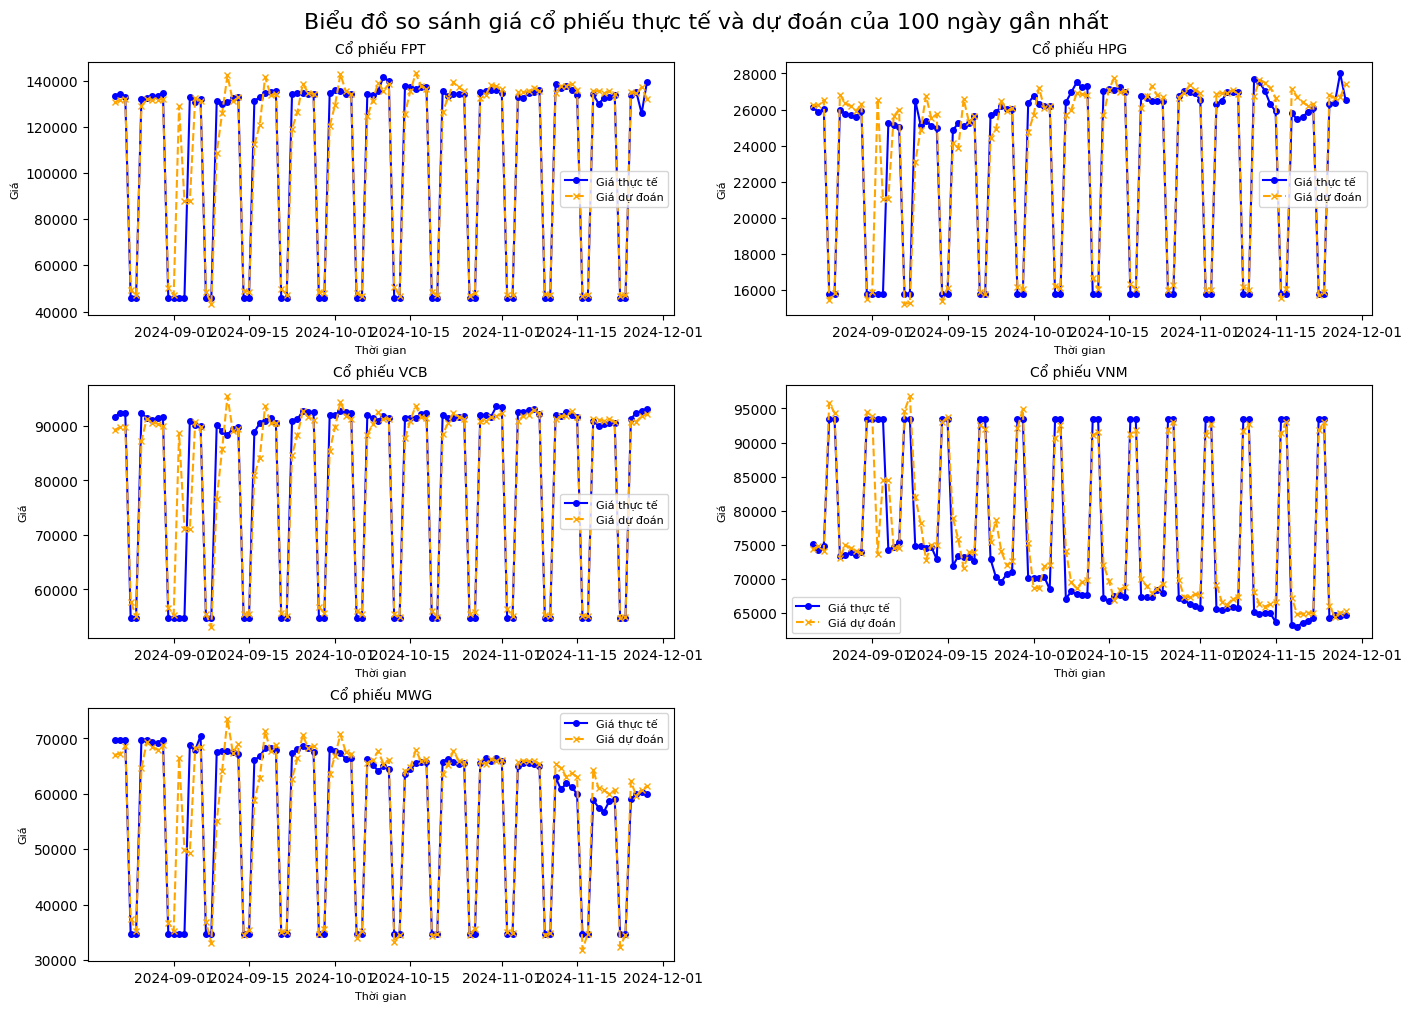

In [37]:
def plot_predictions_reals(result):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10), constrained_layout=True)
    axes = axes.flatten()

    for i, (key, value) in enumerate(result.items()):
        ax = axes[i]
        ax.plot(value['Real price'].index[-100:], value['Real price'][-100:], label='Giá thực tế', linestyle='-', marker='o', markersize=4, linewidth=1.5, color='blue')
        ax.plot(value['Real price'].index[-100:], value['Prediction'][-100:], label='Giá dự đoán', linestyle='--', marker='x', markersize=4, linewidth=1.5, color='orange')
        ax.set_title(f"Cổ phiếu {key}", fontsize=10)
        ax.set_xlabel('Thời gian', fontsize=8)
        ax.set_ylabel('Giá', fontsize=8)
        ax.legend(fontsize=8)

    for j in range(len(result), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Biểu đồ so sánh giá cổ phiếu thực tế và dự đoán của 100 ngày gần nhất", fontsize=16)
    plt.savefig("/content/drive/My Drive/Nhóm 8_KDTM_documents/Biểu đồ so sánh giá thực tế và dự đoán của mô hình Linear Regression.png", format="png", dpi=300)
    plt.show()

plot_predictions_reals(results_linear)

### Nhận xét:
***Sự phù hợp***: Các đường biểu diễn "Giá thực tế" (màu xanh) và "Giá dự đoán" (màu cam) có xu hướng song song nhau, cho thấy mô hình dự đoán hoạt động khá tốt.

***Sai lệch nhỏ***: Tuy nhiên, có một số điểm sai lệch nhỏ giữa giá thực tế và dự đoán, đặc biệt ở những vị trí giá biến động mạnh.

## Mô hình ARIMA

### Kiểm định tính dừng của dữ liệu

In [38]:
def adf_test(x):
    indices = ['Test statistic','p.value','# of Logs Used','# of Observations Used']
    adf_test = adfuller(x)
    results = pd.Series(adf_test[0:4], index=indices)
    for key,value in adf_test[4].items():
        results[f"Critical Value {key}"] = value
    return results
def kpss_test(x):
    indices = ['Test statistic','p.value','# of Lags Used']
    kpss_test = kpss(x)
    results = pd.Series(kpss_test[0:3],index=indices)
    for key,value in kpss_test[3].items():
        results[f"Critical Value {key}"] = value
    return results
def stationary_test(x):
  adf_result = adf_test(x)
  kpss_result = kpss_test(x)
  print(f"ADF test: \n{adf_result}")
  print(f"KPSS test: \n{kpss_result}")
  if (adf_result['p.value'] <= 0.05) & (kpss_result['p.value'] > 0.05):
      print("Kết luận: Chuỗi dừng")
  else:
      print("Kết luận: Chuỗi không dừng")

In [39]:
for key,value in stock.items():
    print(f"Cổ phiếu {key}")
    stationary_test(value['Price'])

Cổ phiếu FPT
ADF test: 
Test statistic               0.58
p.value                      0.99
# of Logs Used              29.00
# of Observations Used   3,710.00
Critical Value 1%           -3.43
Critical Value 5%           -2.86
Critical Value 10%          -2.57
dtype: float64
KPSS test: 
Test statistic         8.33
p.value                0.01
# of Lags Used        37.00
Critical Value 10%     0.35
Critical Value 5%      0.46
Critical Value 2.5%    0.57
Critical Value 1%      0.74
dtype: float64
Kết luận: Chuỗi không dừng
Cổ phiếu HPG
ADF test: 
Test statistic              -1.36
p.value                      0.60
# of Logs Used              30.00
# of Observations Used   3,709.00
Critical Value 1%           -3.43
Critical Value 5%           -2.86
Critical Value 10%          -2.57
dtype: float64
KPSS test: 
Test statistic         6.87
p.value                0.01
# of Lags Used        37.00
Critical Value 10%     0.35
Critical Value 5%      0.46
Critical Value 2.5%    0.57
Critical Value 1

Kiểm định tính dừng với dữ liệu giá cổ phiếu của cả 5 cổ phiếu đều cho ra kết quả là chuỗi không dừng. Điều này trái với giả định của mô hình ARIMA khi mô hình giả định rằng chuỗi dữ liệu là chuỗi dữ liệu dừng. Để sửa lỗi này, nhóm sử dụng sai phân bậc 1.

In [40]:
for key, value in stock.items():
    stock[key]['Price diff'] = value['Price'].diff(1)
    stock[key].dropna(inplace=True)
    print(f"Cổ phiếu {key}")
    print(stock[key].head())

Cổ phiếu FPT
            Price past 1 days  Price past 8 days  Price past 15 days  \
Date                                                                   
2014-09-04          14,247.20          14,247.20           14,247.20   
2014-09-05          14,247.20          14,247.20           14,247.20   
2014-09-06          14,497.20          14,247.20           14,247.20   
2014-09-07          45,896.54          14,247.20           14,247.20   
2014-09-08          45,896.54          14,247.20           14,247.20   

            Price past 22 days  Price past 29 days  Price past 36 days  \
Date                                                                     
2014-09-04           14,247.20           14,247.20           14,247.20   
2014-09-05           14,247.20           14,247.20           14,247.20   
2014-09-06           14,247.20           14,247.20           14,247.20   
2014-09-07           14,247.20           14,247.20           14,247.20   
2014-09-08           14,247.20        

Kiểm định lại

In [41]:
for key, value in stock.items():
    print(f"Cổ phiếu {key}")
    stationary_test(value['Price diff'])

Cổ phiếu FPT
ADF test: 
Test statistic             -17.41
p.value                      0.00
# of Logs Used              28.00
# of Observations Used   3,710.00
Critical Value 1%           -3.43
Critical Value 5%           -2.86
Critical Value 10%          -2.57
dtype: float64
KPSS test: 
Test statistic         0.04
p.value                0.10
# of Lags Used        66.00
Critical Value 10%     0.35
Critical Value 5%      0.46
Critical Value 2.5%    0.57
Critical Value 1%      0.74
dtype: float64
Kết luận: Chuỗi dừng
Cổ phiếu HPG
ADF test: 
Test statistic             -14.72
p.value                      0.00
# of Logs Used              29.00
# of Observations Used   3,709.00
Critical Value 1%           -3.43
Critical Value 5%           -2.86
Critical Value 10%          -2.57
dtype: float64
KPSS test: 
Test statistic         0.01
p.value                0.10
# of Lags Used        66.00
Critical Value 10%     0.35
Critical Value 5%      0.46
Critical Value 2.5%    0.57
Critical Value 1%     

Lúc này chuỗi dữ liệu ở cả 5 cổ phiếu đều đã là chuỗi dữ liệu dừng. Điều đó có nghĩa là bây giờ hoàn toàn có thể xây dựng mô hình ARIMA. Nhóm sử dụng AutoARIMA nhằm để mô hình tự lựa chọn tham số thích hợp nhất cho việc dự đoán

Cổ phiếu FPT


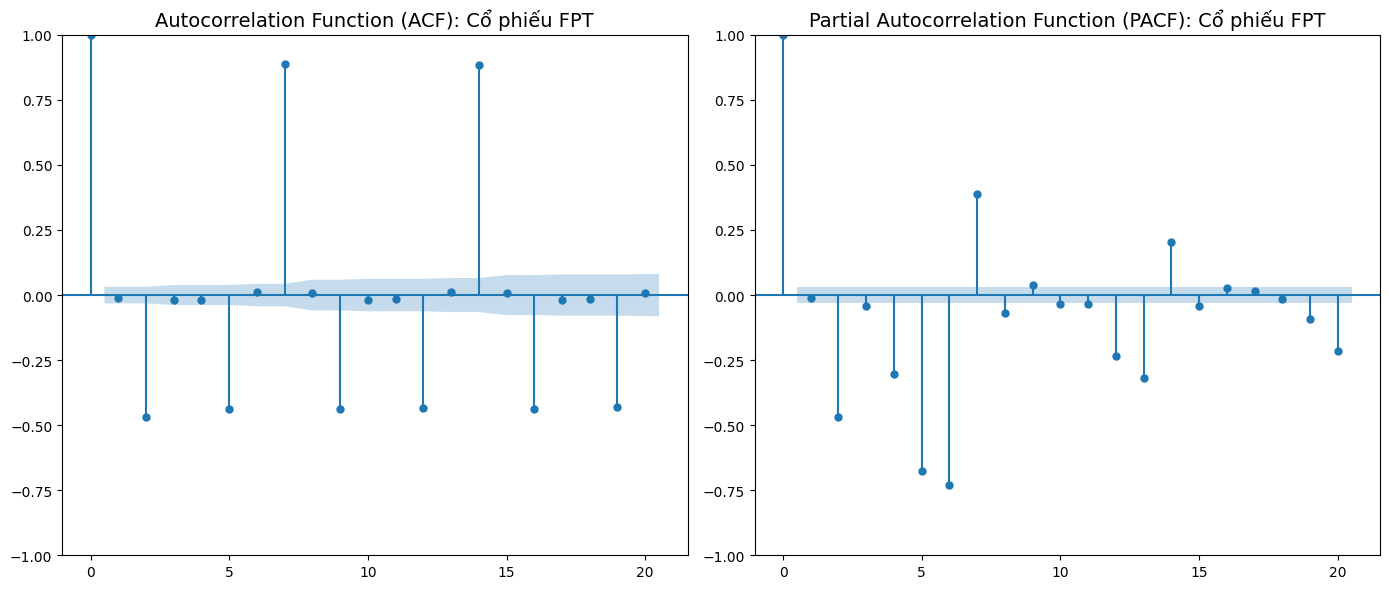

Cổ phiếu HPG


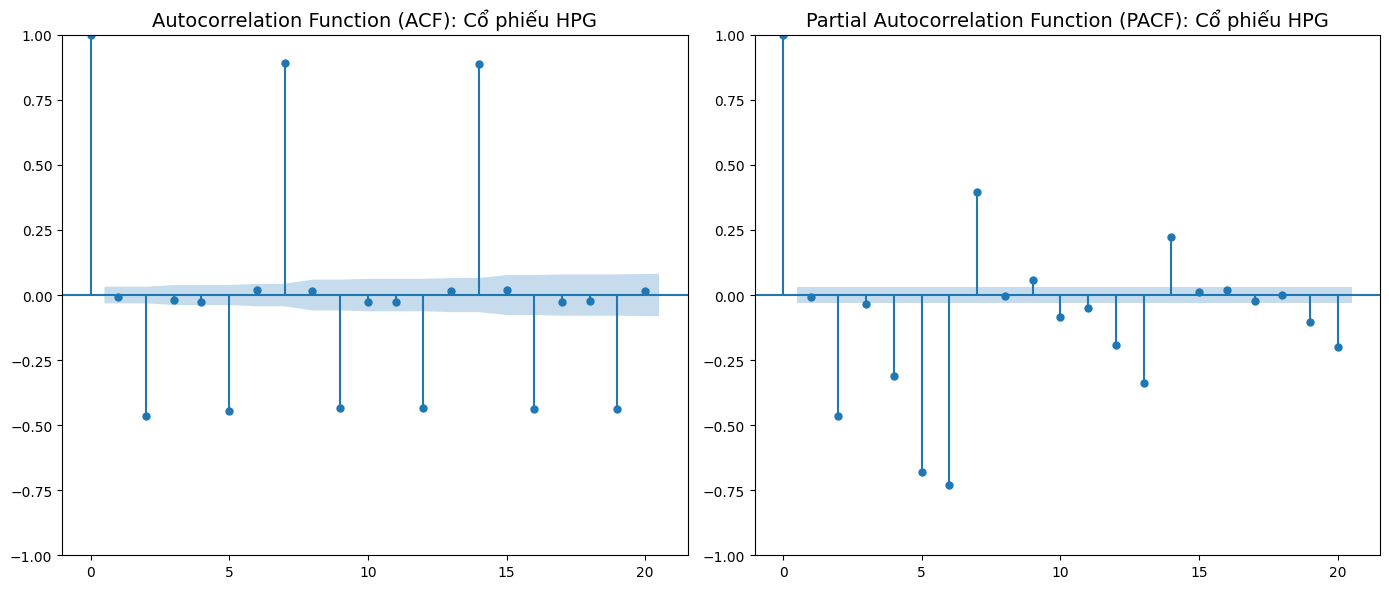

Cổ phiếu VCB


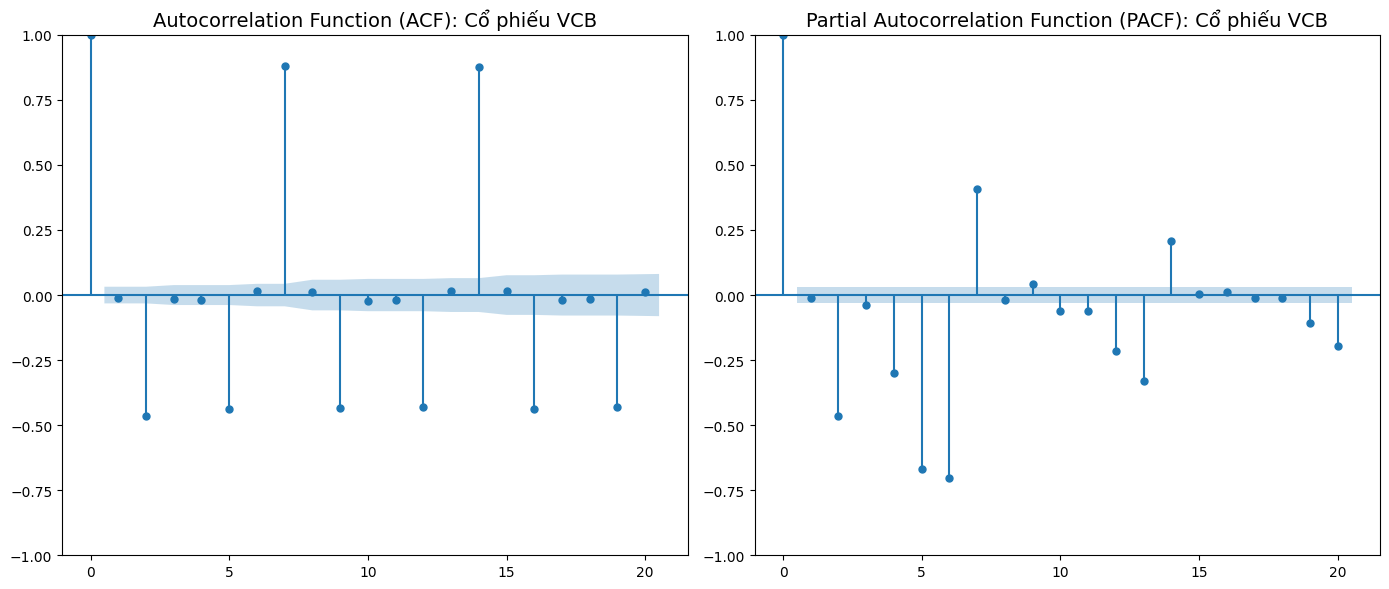

Cổ phiếu VNM


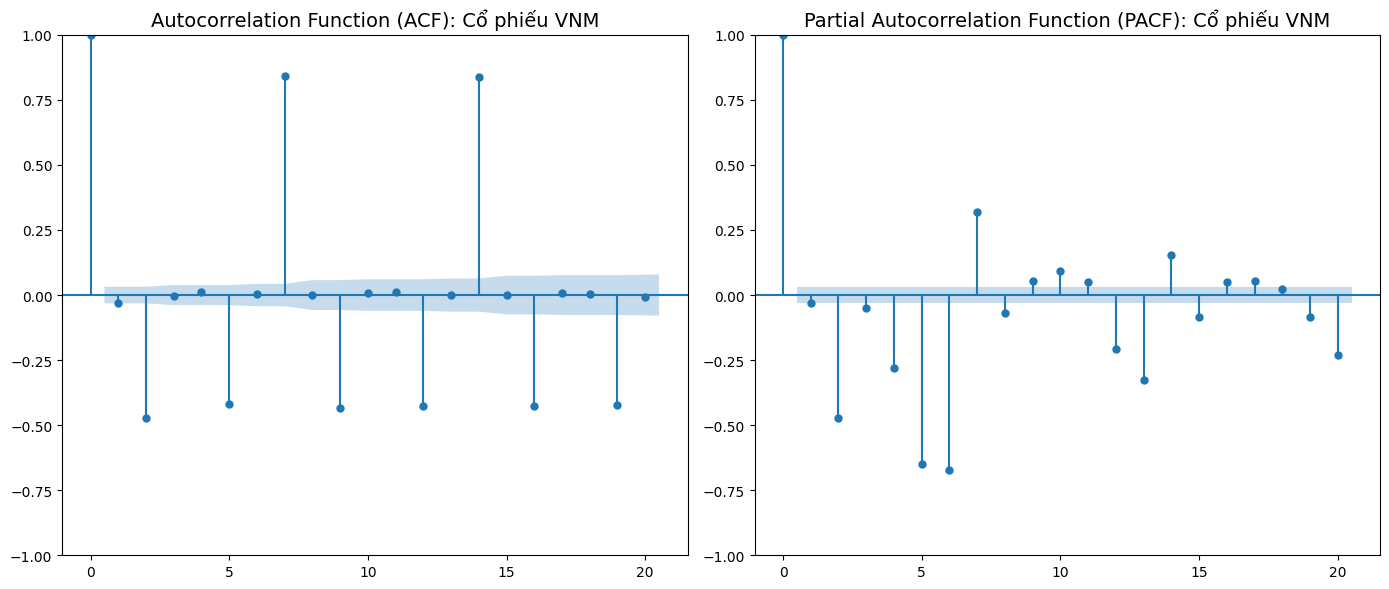

Cổ phiếu MWG


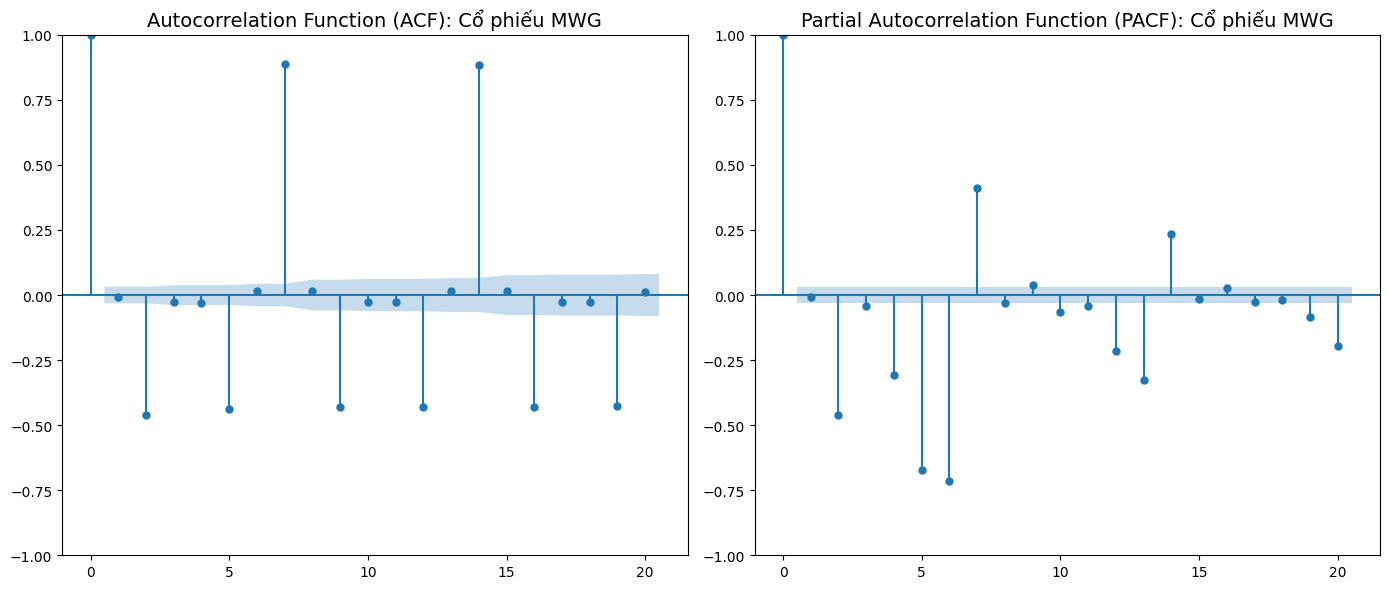

In [42]:
def acf_pacf(stock, n_lags, pic_name):
    for key, value in stock.items():
        print(f"Cổ phiếu {key}")
        price = value['Price diff']
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 hàng, 2 cột (ACF và PACF)
        # Vẽ ACF
        plot_acf(price, ax=axes[0], lags=n_lags)
        axes[0].set_title(f'Autocorrelation Function (ACF): Cổ phiếu {key}', fontsize=14)
        # Vẽ PACF
        plot_pacf(price, ax=axes[1], lags=n_lags)
        axes[1].set_title(f'Partial Autocorrelation Function (PACF): Cổ phiếu {key}', fontsize=14)

        plt.tight_layout()
        plt.savefig(f"{pic_name}_{key}.png", format="png", dpi=300)
        plt.show()

acf_pacf(stock, 20, "/content/drive/My Drive/Nhóm 8_KDTM_documents/Acf_pacf_price_diff")

Cổ phiếu FPT
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=55586.847, Time=3.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=57173.668, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=57175.227, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=56530.995, Time=1.35 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=55650.920, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=55551.532, Time=0.92 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=56202.132, Time=0.79 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=56529.109, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=55713.747, Time=0.73 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=56527.455, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=56030.554, Time=0.86 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=55708.003, Time=1.32 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 9.928 seconds
                               SARIMAX Results                 

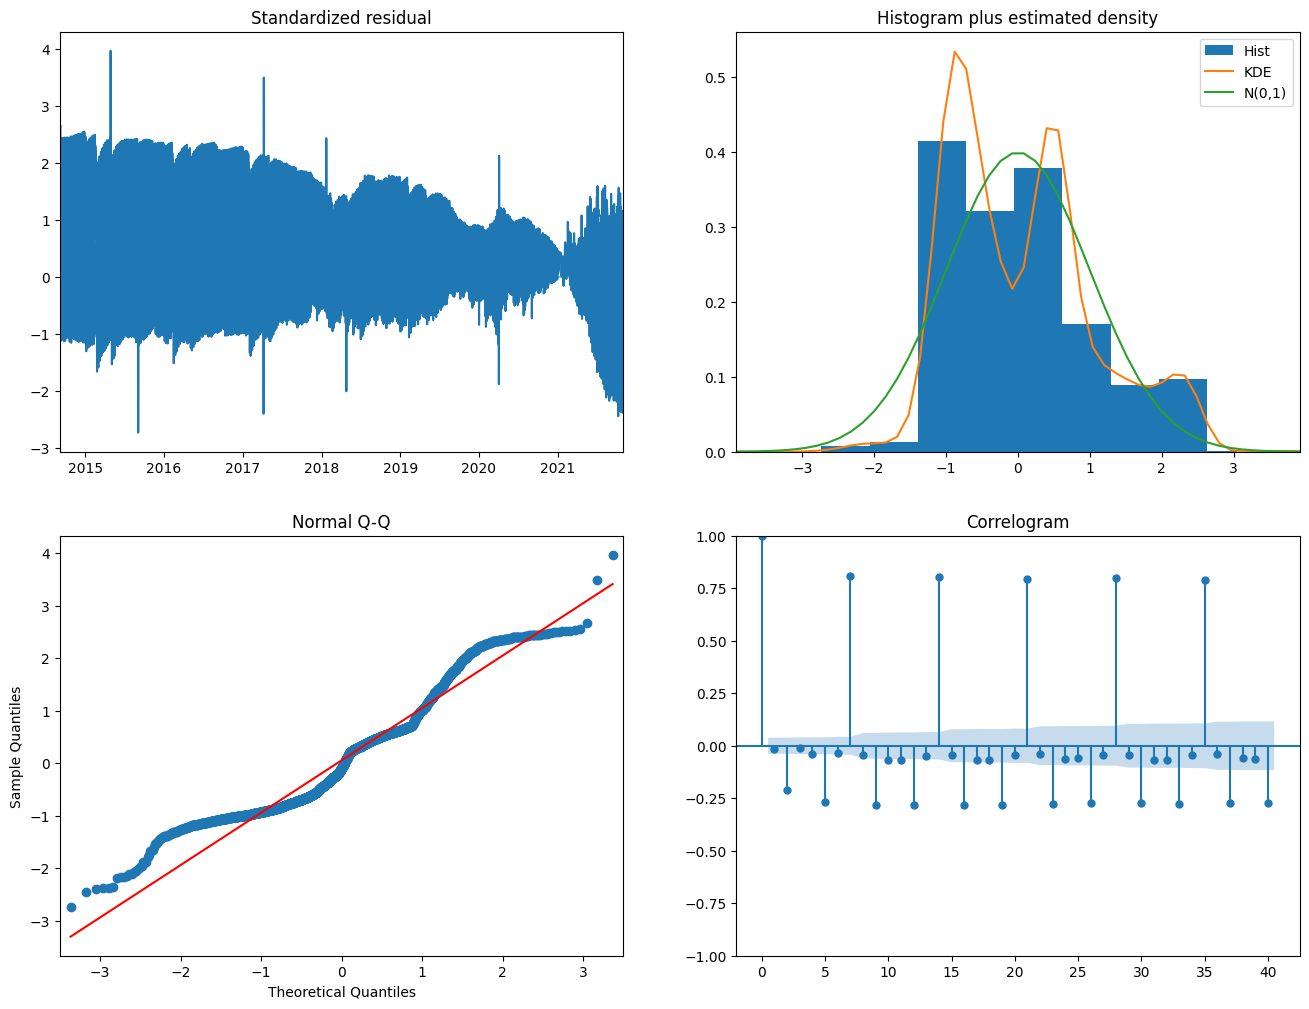

Cổ phiếu HPG
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=50798.090, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=52317.627, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=52319.286, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=51713.542, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=50745.285, Time=0.79 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=50815.760, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=51379.326, Time=0.62 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=50458.253, Time=5.69 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=50705.338, Time=1.04 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=50579.043, Time=1.20 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=50445.503, Time=2.47 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=50336.869, Time=2.13 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=50338.858, Time=2.20 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=50629.468, Time=7.03 sec
 ARIMA

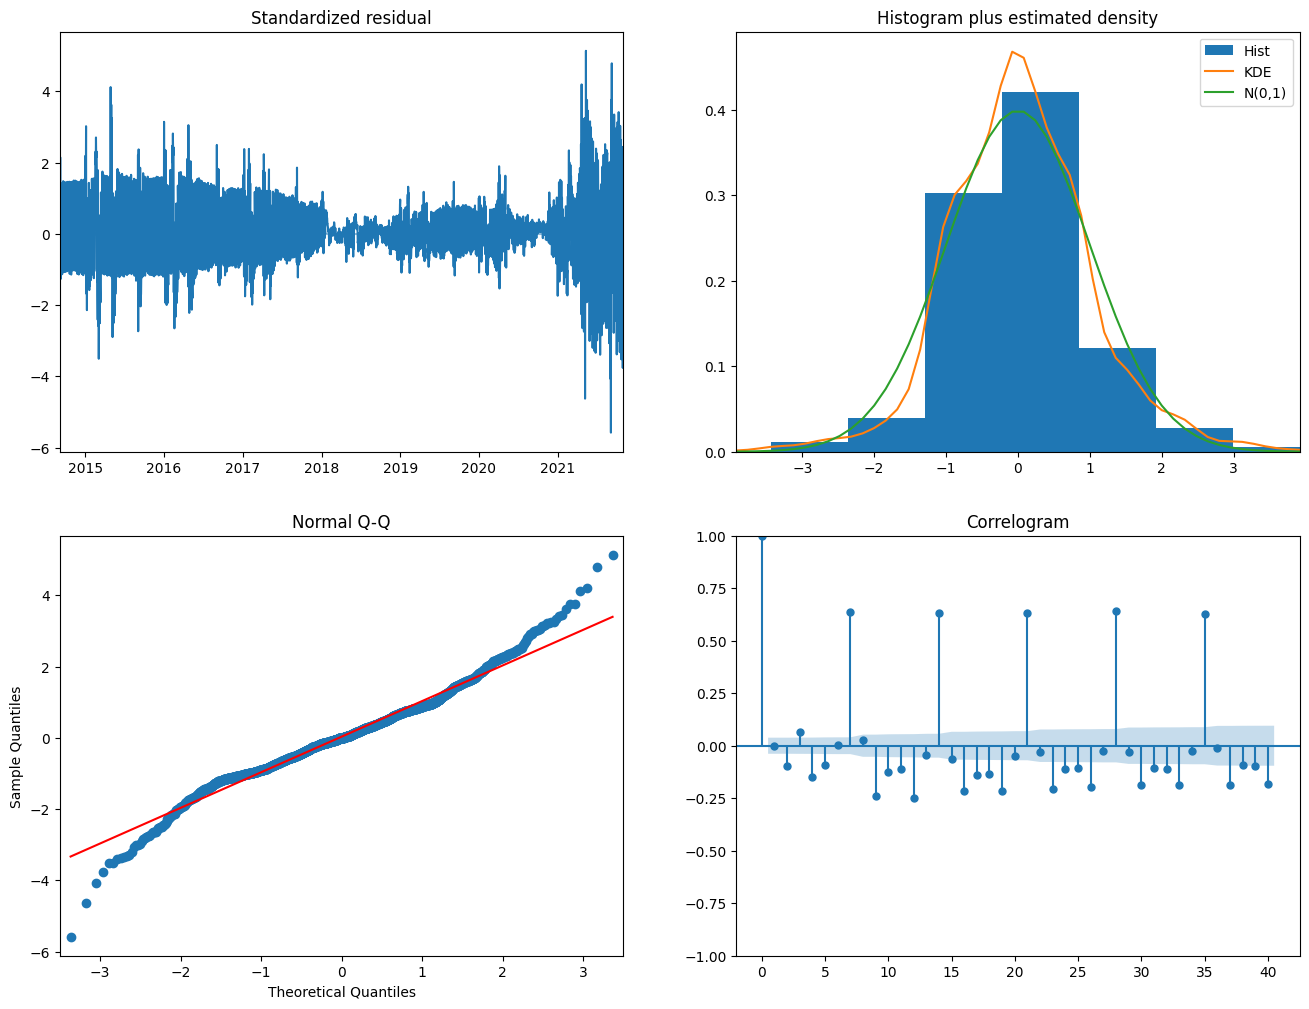

Cổ phiếu VCB
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=55232.797, Time=1.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=56748.084, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=56749.669, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=56163.290, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=55270.303, Time=0.38 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=55335.241, Time=0.42 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=55060.836, Time=1.76 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=55337.044, Time=0.68 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=54998.696, Time=4.69 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=54847.971, Time=1.79 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=55861.748, Time=0.29 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=53598.378, Time=1.21 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=54262.503, Time=0.41 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=52791.444, Time=3.57 sec
 ARIMA

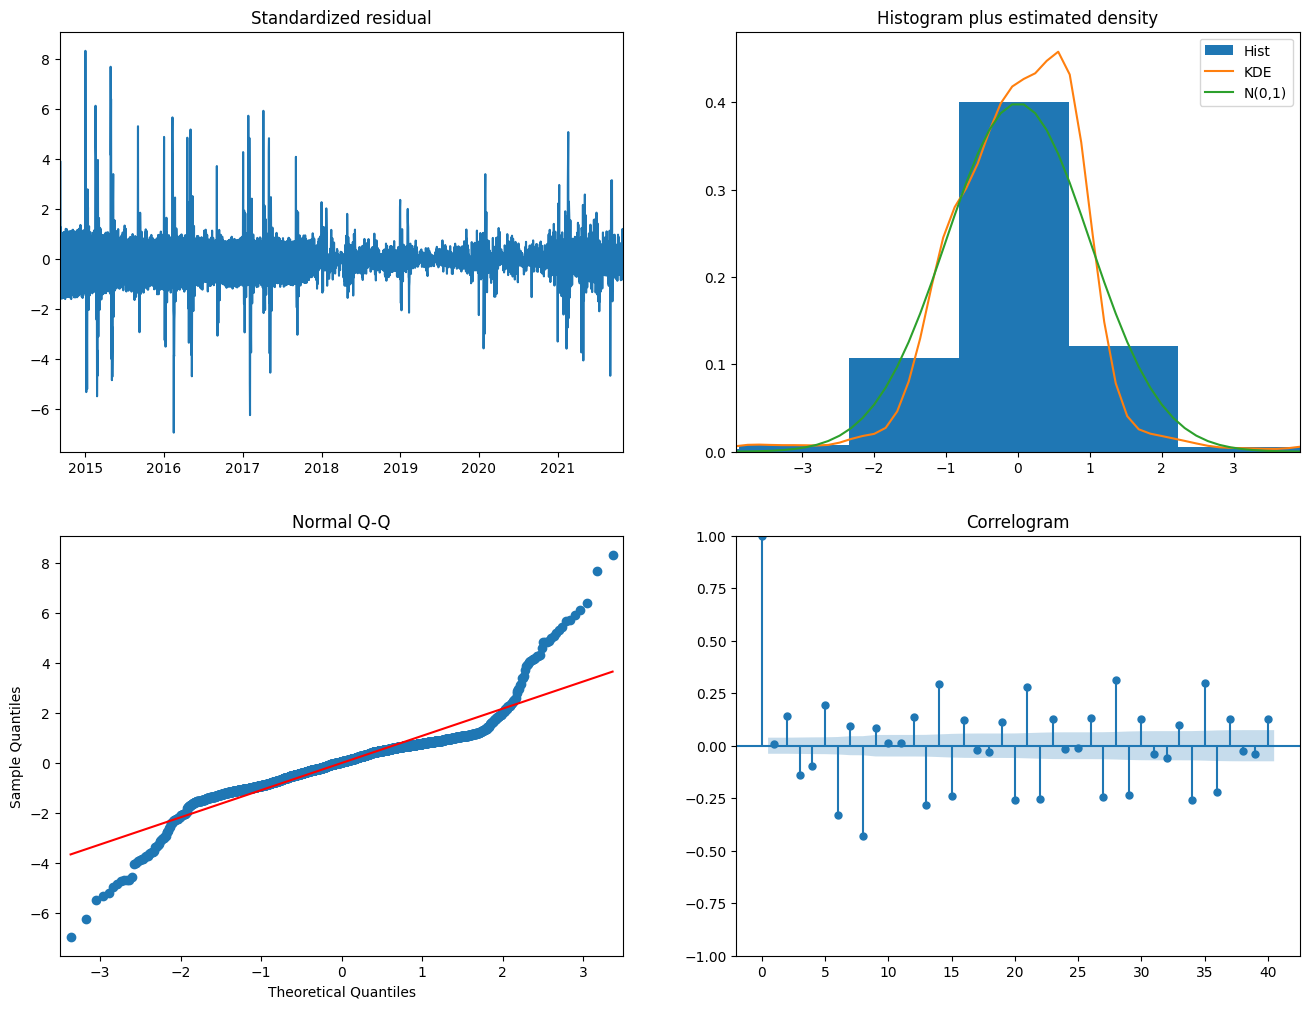

Cổ phiếu VNM
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=55740.588, Time=1.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=57363.951, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=57362.934, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=56860.678, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=55992.631, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=56020.736, Time=0.38 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=56165.412, Time=0.74 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=55703.926, Time=1.84 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=56073.359, Time=2.40 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=55502.362, Time=3.58 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=54882.074, Time=3.59 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=56915.783, Time=0.93 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=54071.548, Time=3.82 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=54065.188, Time=5.92 sec
 ARIMA

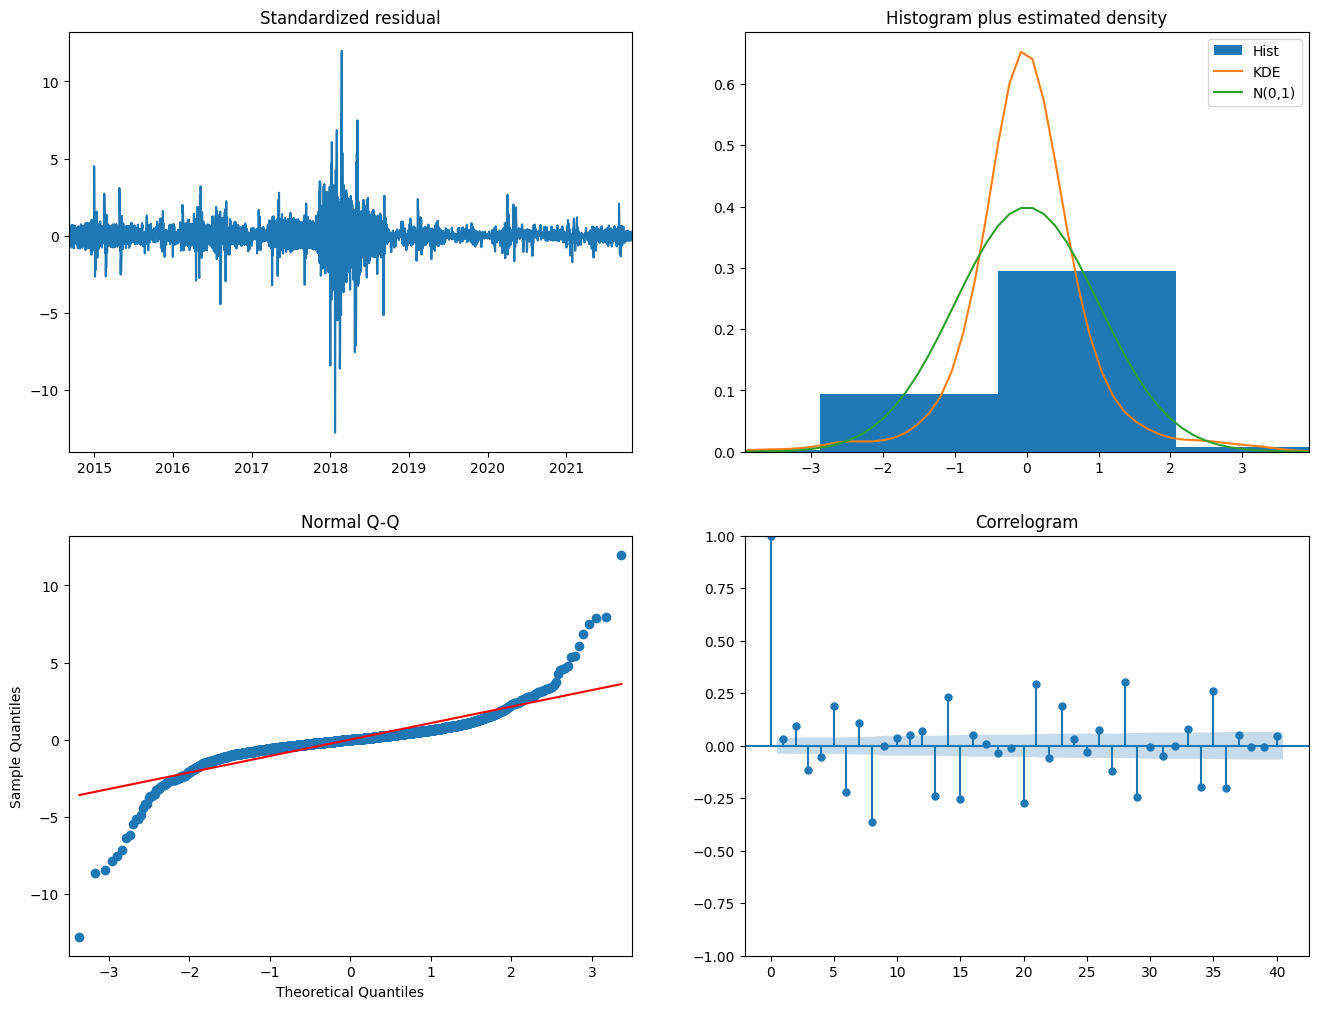

Cổ phiếu MWG
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=53353.182, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54848.566, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=54850.110, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=54260.093, Time=0.34 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=53358.410, Time=0.59 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=53429.112, Time=1.93 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=53149.045, Time=3.82 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=53430.949, Time=0.82 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=2.39 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=52884.479, Time=3.40 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=52676.269, Time=3.84 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=53101.356, Time=3.88 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=3.38 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=53085.934, Time=2.25 sec
 ARIMA(3,0,4)(0,0,

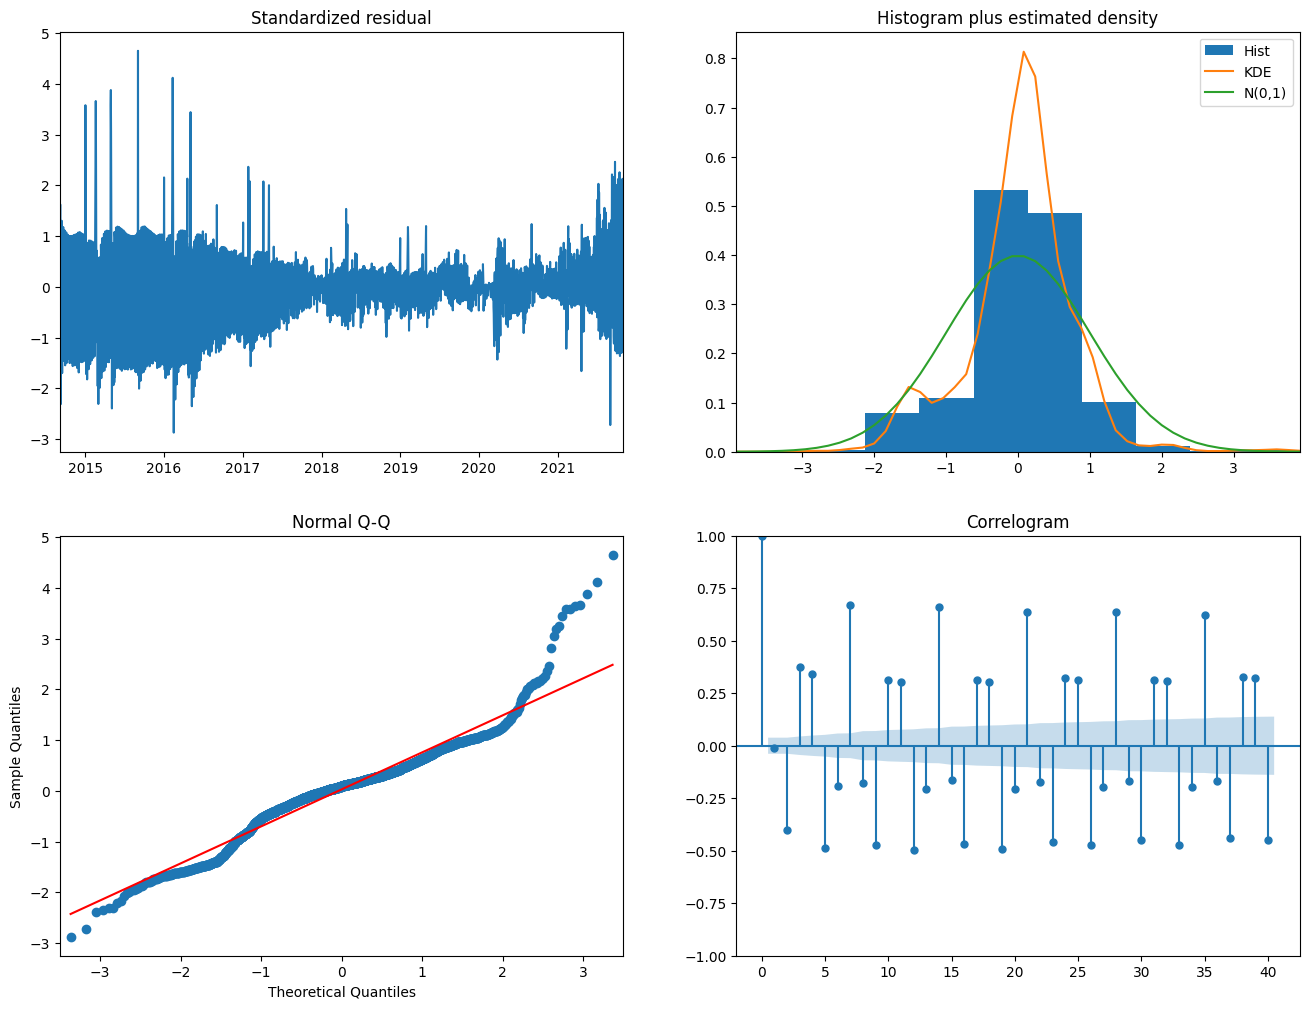


Đánh giá mô hình:
               MSE       MAE    R2
FPT 735,154,880.57 13,291.23 -0.00
HPG  33,528,421.58  2,856.66  0.00
VCB 208,233,592.99  7,811.08  0.07
VNM 158,773,791.26  7,010.47  0.02
MWG 129,565,424.67  8,998.19  0.21


In [43]:
def train_arima(x):
    size = int(len(x) * 0.7)
    train, test = x[:size], x[size:]
    # Huấn luyện mô hình
    auto_arima = pm.auto_arima(train, trace=1, error_action='ignore', suppress_warning=True, seasonal=False, stepwise=True, approximation=False, n_jobs=1,
                                   seasonal_test=None)
    print(auto_arima.summary())
    # Dự báo
    y_pred = auto_arima.predict(n_periods = len(test))
    fig = plt.figure(figsize=(16, 12))
    auto_arima.plot_diagnostics(fig=fig, lags=40)
    plt.show()

    # Đánh giá
    mae = mean_absolute_error(test, y_pred)
    mse = mean_squared_error(test, y_pred)
    r2 = r2_score(test, y_pred)

    return [auto_arima, round(mse,2), round(mae,2), round(r2,2)]
results_arima = {}
for key, value in stock.items():
    print(f"Cổ phiếu {key}")
    metrics = train_arima(value['Price diff'])
    results_arima[key] = {'Model':metrics[0],'MSE': metrics[1],'MAE':metrics[2],'R2':metrics[3]}
arima_result_df = pd.DataFrame(results_arima).T
print("\nĐánh giá mô hình:")
print(arima_result_df[['MSE','MAE','R2']])

### Kết luận:
Mô hình ARIMA dự đoán không hiệu quả

## Mô hình LSTM

In [49]:
# Tạo chuỗi dữ liệu dùng cho dự báo
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

def train_lstm(x):
    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_x = scaler.fit_transform(x.values.reshape(-1, 1))

    time_steps = 60  # Số ngày lùi
    X, y = create_sequences(scaled_x, time_steps)

    # Chia thành bộ train và bộ test
    size = int(0.7 * len(X))
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]

    # Dựng mô hình
    model = Sequential([
        LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=32, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Thêm Early Stop để tránh overfitting
    early_stop = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    )

    # Huấn luyện mô hình
    history = model.fit(
        X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
        callbacks=[early_stop]
    )

    # Đánh giá mô hình
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Dự đoán
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Đánh giá dự đoán
    mae = mean_absolute_error(y_test_unscaled, y_pred)
    mse = mean_squared_error(y_test_unscaled, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_unscaled, y_pred)
    return [model, round(mse,2), round(mae,2), round(r2,2), y_test_unscaled, y_pred]

In [50]:
results_lstm = {}
for key, value in stock.items():
    features = value.drop(columns = ['Price','Price diff']).columns.to_list()
    target = 'Price'
    metrics = train_lstm(value['Price'])
    results_lstm[key] = {'Model':metrics[0],'MSE': metrics[1],'MAE':metrics[2],'R2':metrics[3],'Real price':metrics[4],'Predictions':metrics[5]}

lstm_result_df = pd.DataFrame(results_lstm).T
print("Đánh giá mô hình:")
print(lstm_result_df[['MSE','MAE','R2']])

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0127 - val_loss: 0.0432
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0082 - val_loss: 0.0314
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0080 - val_loss: 0.0370
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0080 - val_loss: 0.0315
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0079 - val_loss: 0.0348
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0079 - val_loss: 0.0306
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0077 - val_loss: 0.0283
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0064 - val_loss: 0.0282
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0045 - val_loss: 0.0240
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0043 - val_loss: 0.0230
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033 - val_loss: 0.0308
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.

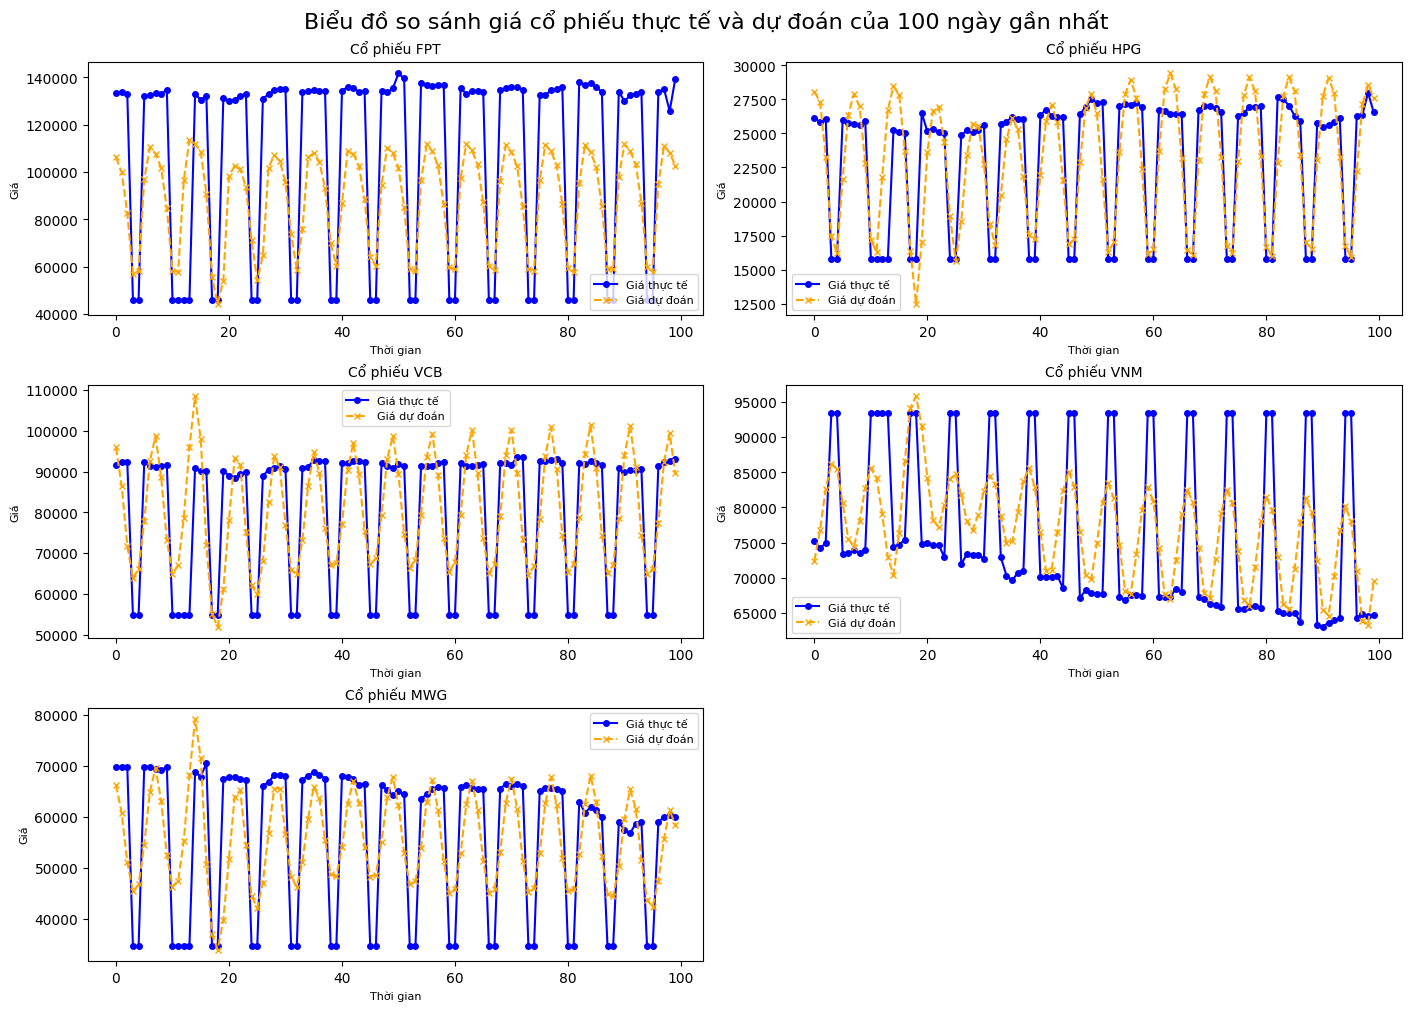

In [51]:
def plot_predictions_reals(result):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10), constrained_layout=True)
    axes = axes.flatten()

    for i, (key, value) in enumerate(result.items()):
        ax = axes[i]
        ax.plot(value['Real price'][-100:], label='Giá thực tế', linestyle='-', marker='o', markersize=4, linewidth=1.5, color='blue')
        ax.plot(value['Predictions'][-100:], label='Giá dự đoán', linestyle='--', marker='x', markersize=4, linewidth=1.5, color='orange')
        ax.set_title(f"Cổ phiếu {key}", fontsize=10)
        ax.set_xlabel('Thời gian', fontsize=8)
        ax.set_ylabel('Giá', fontsize=8)
        ax.legend(fontsize=8)

    for j in range(len(result), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Biểu đồ so sánh giá cổ phiếu thực tế và dự đoán của 100 ngày gần nhất", fontsize=16)
    plt.savefig("/content/drive/My Drive/Nhóm 8_KDTM_documents/Biểu đồ so sánh giá thực tế và dự đoán của mô hình LSTM.png", format="png", dpi=300)
    plt.show()

plot_predictions_reals(results_lstm)

In [52]:
total_result = {
    'Linear Regression': linear_result_df[['MSE','MAE','R2']],
    'ARIMA': arima_result_df[['MSE','MAE','R2']],
    'LSTM': lstm_result_df[['MSE','MAE','R2']]
}
for key, value in total_result.items():
  print(f"Kết quả mô hình {key}:")
  print(value)

Kết quả mô hình Linear Regression:
              MSE      MAE   R2
FPT 69,387,619.02 3,995.07 0.92
HPG  4,391,401.80 1,107.10 0.90
VCB 26,667,985.90 2,555.71 0.88
VNM 17,753,808.92 2,375.74 0.87
MWG 19,519,403.73 2,354.18 0.90
Kết quả mô hình ARIMA:
               MSE       MAE    R2
FPT 735,154,880.57 13,291.23 -0.00
HPG  33,528,421.58  2,856.66  0.00
VCB 208,233,592.99  7,811.08  0.07
VNM 158,773,791.26  7,010.47  0.02
MWG 129,565,424.67  8,998.19  0.21
Kết quả mô hình LSTM:
               MSE       MAE   R2
FPT 321,563,735.67 12,983.84 0.62
HPG   9,733,710.76  2,069.48 0.75
VCB 103,667,184.03  7,782.85 0.53
VNM  80,615,395.34  7,298.45 0.40
MWG  76,913,287.63  6,514.83 0.60


### Nhận xét:
Từ bảng so sánh trên, có thể thấy mô hình Linear Regression có chỉ số ***MSE*** và ***MAE*** của cả 5 cổ phiếu thấp nhất và đồng thời chỉ số ***R2*** cao nhất. Vậy nên mô hình Linear Regression được chọn để tạo phần mềm dự đoán giá cổ phiếu của cả 5 cổ phiếu

In [48]:
# Lưu các bộ chuẩn hóa dữ liệu
scalers = {}
for key, value in results_linear.items():
    scalers[key] = value['scaler']
jb.dump(scalers, '/content/drive/My Drive/Nhóm 8_KDTM_documents/Scaler fitted.pkl')
# Lưu tất cả các mô hình
models = {}
for key, value in results_linear.items():
    models[key] = value['model']

# Lưu models vào một file duy nhất
jb.dump(models, '/content/drive/My Drive/Nhóm 8_KDTM_documents/Linear model trained.pkl')

['/content/drive/My Drive/Nhóm 8_KDTM_documents/Linear model trained.pkl']